# Transfomer(年齢予測)

## import ライブラリー

In [1]:
"""%%bash
python3 -m pip install --user torch
python3 -m pip install --user scikit-learn"""

'%%bash\npython3 -m pip install --user torch\npython3 -m pip install --user scikit-learn'

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

from scipy.stats import pearsonr

import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.device_count()
#torch.set_default_tensor_type('torch.cuda.FloatTensor')

1

## Data定義

In [3]:
%%time
#6分ぐらいかかる
df_aal = pd.read_csv('../02_data_analysis/roi_timeseries/timeseries_aal.csv')
df_ho = pd.read_csv('../02_data_analysis/roi_timeseries/timeseries_ho.csv')

#df_dynamic_aal = pd.read_csv('../02_data_analysis/dynamic_FC/dynamic_aal.csv')
#df_dynamic_ho = pd.read_csv('../02_data_analysis/dynamic_FC/dynamic_ho.csv')

df_subjects_info = pd.read_csv('../02_data_analysis/subjects_info/subjects_info.csv')

CPU times: user 3.2 s, sys: 192 ms, total: 3.39 s
Wall time: 3.44 s


In [5]:
def make_info_data(df = df_subjects_info,col = ['Age',
                                                'Sex',
                                                'やる気スコア(Apathy scale)',
                                                'SDS（自己評価式抑うつ性尺度)',
                                                'Kohs(立方体組み合わせテスト)',
                                                'Height cm',
                                                'Weight kg',]):
    df = df.fillna(df.mean())
    subID = np.array(df.subID)
    subjects_info_list = []
    for ID in subID:
        data = np.array(df[df.subID == ID][col])[0]
        if 'Sex' in col:
            idx = col.index('Sex')
            if data[idx] == '男':
                data[idx] = 0
            else:
                data[idx] = 1
        subjects_info_list.append(data)
    subjects_info = np.array(subjects_info_list)
    
    for i in range(len(col)):
        if i == idx:
            continue
        else:
            subjects_info[:,i] = (subjects_info[:,i] - np.mean(subjects_info[:,i]))/\
                                                       np.std(subjects_info[:,i])
    return subjects_info.astype(np.float)

def make_data(df, subID = df_subjects_info.subID ,remove_list = ['time','subID']):
    data_list = []
    df_cols = list(df.columns)
    for r in remove_list:
        try:
            df_cols.remove(r)
        except:
            pass
    for ID in df_subjects_info.subID:
        data = df[df.subID == ID][df_cols]
        data = np.array(data)
        data_list.append(data)
    data = np.array(data_list)
    return data

In [6]:
%%time
data_label = make_info_data()
data_aal = make_data(df_aal)
data_ho = make_data(df_ho)

age_mean = df_subjects_info.Age.mean()
age_std = df_subjects_info.Age.std()

CPU times: user 10.2 s, sys: 32.4 ms, total: 10.3 s
Wall time: 10.3 s


In [7]:
data_label.shape
data_aal.shape
data_ho.shape

(615, 7)

(615, 140, 116)

(615, 140, 110)

In [8]:
#30秒ぐらいかかる
#data_dynamic_aal = make_data(df_dynamic_aal)
#data_dynamic_ho = make_data(df_dynamic_ho)

#data_dynamic_aal.shape
#data_dynamic_ho.shape

## Model作成

In [26]:
import math
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        self.dropout = nn.Dropout(p=dropout)
        # Not a parameter
        self.register_buffer('pe', self._pe_table(d_model, max_len))

    def _pe_table(self, d_model: int, max_len: int) -> torch.Tensor:
        pos = torch.arange(0, max_len).unsqueeze(1)
        pe_denominator = torch.exp(
            torch.arange(0, d_model, 2) * math.log(10000) / d_model
        )

        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(pos / pe_denominator)  # 偶数項にはsin
        pe[:, 1::2] = torch.cos(pos / pe_denominator)  # 奇数項にはcos

        pe = pe.unsqueeze(0)  # バッチに対応するため
        return pe

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.dropout(x + self.pe[:, :x.size(1)].clone().detach())

In [45]:
class Model(nn.Module):    
    def __init__(self,
                 input_dim,
                 d_model,
                 hidden_dim,
                 time_len,
                 nhead,
                 output_dim,
                 hidden_dim_transformer,
                 pos_drop,
                 trans_drop,
                 fc_drop
                ):
        super(Model, self).__init__()
        self.fc0  = nn.Linear(input_dim,d_model)
        self.pos  = PositionalEncoding(d_model = d_model,dropout=pos_drop)
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model,
                                                                    nhead,
                                                                    dropout=trans_drop,
                                                                    dim_feedforward=hidden_dim,
                                                                    batch_first=True)
        self.transformer_encoder       = nn.TransformerEncoder(self.transformer_encoder_layer,
                                                               num_layers=hidden_dim_transformer)
        self.fc_age1  = nn.Linear(d_model,1)
        self.fc_sex1  = nn.Linear(d_model,1)
        self.fc_age2  = nn.Linear(time_len,1)
        self.fc_sex2  = nn.Linear(time_len,1)
        self.drop  = nn.Dropout(fc_drop)
        self.time_len = time_len
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        x = self.fc0(x)
        x = self.pos(x)
        x = self.transformer_encoder(x)
        age = self.fc_age1(x)
        sex = self.fc_sex1(x)
        
        age = self.drop(age)
        sex = self.drop(sex)
        
        age = torch.reshape(age, (-1, self.time_len))
        sex = torch.reshape(sex, (-1, self.time_len))
        
        age = self.fc_age2(age)
        sex = self.fc_sex2(sex)
        sex = self.sigmoid(sex)
        return age,sex

In [38]:
class Model(nn.Module):    
    def __init__(self,
                 input_dim,
                 d_model,
                 hidden_dim,
                 time_len,
                 nhead,
                 output_dim,
                 hidden_dim_transformer,
                 pos_drop,
                 trans_drop,
                 fc_drop
                ):
        super(Model, self).__init__()
        self.fc0  = nn.Linear(input_dim,d_model)
        self.pos  = PositionalEncoding(d_model = d_model,dropout=pos_drop)
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model,
                                                                    nhead,
                                                                    dropout=trans_drop,
                                                                    dim_feedforward=hidden_dim,
                                                                    batch_first=True)
        self.transformer_encoder       = nn.TransformerEncoder(self.transformer_encoder_layer,
                                                               num_layers=hidden_dim_transformer)
        self.fc_age1  = nn.Linear(d_model,1)
        #self.fc_sex1  = nn.Linear(d_model,1)
        self.fc_age2  = nn.Linear(time_len,1)
        #self.fc_sex2  = nn.Linear(time_len,1)
        self.drop  = nn.Dropout(fc_drop)
        self.time_len = time_len
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        x = self.fc0(x)
        x = self.pos(x)
        x = self.transformer_encoder(x)
        age = self.fc_age1(x)
        sex = self.fc_age1(x)
        age = self.drop(age)
        
        age = torch.reshape(age, (-1, self.time_len))
        sex = torch.reshape(sex, (-1, self.time_len))
        
        age = self.fc_age2(age)
        sex = torch.mean(sex,axis=1)
        sex = torch.reshape(sex, (-1, 1))
        sex = self.sigmoid(sex)
        return age,sex

In [46]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, label=None):
        self.data = data
        self.label = label
        self.test = label is None
        self.length = data.shape[0]
    def __len__(self):
        return self.length
    def __getitem__(self,idx):
        if self.test:
            data = torch.tensor(self.data[idx])
            return data
        else:
            data = torch.tensor(self.data[idx])
            label = torch.tensor(self.label[idx])
            return data, label

In [47]:
def compute_loss_age(y, t):
    criterion = nn.MSELoss()
    return criterion(y, t)

def compute_loss_sex(y, t):
    criterion = nn.BCELoss()
    return criterion(y, t)

def train_step(x,t,model,optimizer):
    model.train()
    preds_age,preds_sex = model(x)
    age = t[:,0:1]
    sex = t[:,1:]
    loss_age = compute_loss_age(preds_age, age)
    loss_sex = compute_loss_sex(preds_sex, sex)
    loss = (9/10) * loss_age + (1/10) * loss_sex
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, preds_age, preds_sex

def val_step(x,t,model):
    model.eval()
    preds_age,preds_sex = model(x)
    age = t[:,0:1]
    sex = t[:,1:]
    loss_age = compute_loss_age(preds_age, age)
    loss_sex = compute_loss_sex(preds_sex, sex)
    loss = (9/10) * loss_age + (1/10) * loss_sex
    return loss, preds_age, preds_sex

def test_step(x,model):
    model.eval()
    preds_age,preds_sex = model(x)
    return preds_age, preds_sex

def seed_worker(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [48]:
def train_model(data,
                label,
                train_idx,
                test_idx,
                n_splits,
                epochs     = 750,
                d_model    = 128,
                hidden_dim = 512,
                nhead      = 32,
                hidden_dim_transformer = 2,
                pos_drop    = 0.1,
                trans_drop = 0.1,
                fc_drop = 0.1
                ):
    
    epochs = epochs
    seed_worker()
    label = label[:,0:2]
    
    train_all = data[train_idx]
    test  = data[test_idx]
    
    train_label_all = label[train_idx]
    test_label  = label[test_idx]
    
    input_dim  = data.shape[2]
    time_len   = data.shape[1]
    output_dim = data_label.shape[1]
    d_model    = d_model
    hidden_dim = hidden_dim
    nhead      = nhead
    hidden_dim_transformer = hidden_dim_transformer
    pos_drop    = pos_drop
    trans_drop = trans_drop
    fc_drop = fc_drop
    
    test_dataset = MyDataset(test)
    test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=32)
    
    kf = KFold(n_splits=n_splits,shuffle=False)
    test_pred_all = []
    
    for i, (train_index, val_index) in enumerate(kf.split(train_all)):
        
        early_stopping = 1e5
        save_epochs = 0
        
        train_loss_plot = []
        val_loss_plot = []
        
        train, train_label = train_all[train_index], train_label_all[train_index]
        val,   val_label   = train_all[val_index],   train_label_all[val_index]
        
        train_dataset    = MyDataset(train,train_label)
        train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)

        val_dataset      = MyDataset(val,val_label)
        val_dataloader   = torch.utils.data.DataLoader(val_dataset,batch_size=32)
        
        model= Model(input_dim = input_dim,
                      d_model  = d_model,
                      hidden_dim = hidden_dim,
                      time_len = time_len,
                      nhead = nhead,
                      output_dim = output_dim,
                      hidden_dim_transformer = hidden_dim_transformer,
                      pos_drop = pos_drop,
                      trans_drop = trans_drop,
                      fc_drop = fc_drop
                     ).to(device)

        optimizer = torch.optim.AdamW(model.parameters(),lr=1e-5)
        for epoch in range(epochs):
            train_loss = 0.
            val_loss = 0.

            for (x, t) in train_dataloader:
                x, t = x.to(device), t.to(device)
                x = x.float()
                t = t.float()
                loss, preds_age, preds_sex = train_step(x,t,model,optimizer)
                train_loss += loss.item()
            train_loss /= len(train_dataloader)
            
            for (x, t) in val_dataloader:
                x, t = x.to(device), t.to(device)
                x = x.float()
                t = t.float()
                loss, preds_age, preds_sex = val_step(x,t,model)
                val_loss += loss.item()
            val_loss /= len(val_dataloader)
            
            if (epoch+1) % 100 == 0:
                print(f'Kfold: {i+1} ::: epoch: {epoch+1}, loss: {train_loss}, val loss: {val_loss}')
            
            if epoch+1 >= 250:
                if early_stopping >= val_loss:
                    early_stopping = val_loss
                    model_path = '../02_data_analysis/model/model_.pth'
                    torch.save(model.state_dict(), model_path)
                    save_epochs = epoch+1
        
            train_loss_plot.append(train_loss)
            val_loss_plot.append(val_loss)
        
        model.load_state_dict(torch.load(model_path))
        print(f'save_epochs:{save_epochs}')
        
        train_loss_plot = np.array(train_loss_plot)
        val_loss_plot   = np.array(val_loss_plot)
        x               = np.linspace(0, len(train_loss_plot), len(train_loss_plot))
        
        plt.figure(figsize=(6, 4), dpi=80)
        plt.plot(x, train_loss_plot, label="train loss")
        plt.plot(x, val_loss_plot, label="val loss")
        plt.legend()
        plt.grid()
        plt.show()
        
        train_pred_age = []
        train_pred_sex = []
        train_label = []
        
        for (x, t) in train_dataloader:
            x, t = x.to(device), t.to(device)
            x = x.float()
            t = t.float()
            loss, preds_age, preds_sex= val_step(x,t,model)
            train_pred_age.append(preds_age)
            train_pred_sex.append(preds_sex)
            train_label.append(t)
        
        val_pred_age = []
        val_pred_sex = []
        for (x, t) in val_dataloader:
            x, t = x.to(device), t.to(device)
            x = x.float()
            t = t.float()
            loss, preds_age, preds_sex= val_step(x,t,model)
            val_pred_age.append(preds_age)
            val_pred_sex.append(preds_sex)
        
        train_pred_age = torch.cat(train_pred_age)
        train_pred_age = train_pred_age.to('cpu').detach().numpy().copy()
        train_pred_sex = torch.cat(train_pred_sex)
        train_pred_sex = train_pred_sex.to('cpu').detach().numpy().copy()
        
        train_label = torch.cat(train_label)
        train_label = train_label.to('cpu').detach().numpy().copy()
        
        val_pred_age = torch.cat(val_pred_age)
        val_pred_age = val_pred_age.to('cpu').detach().numpy().copy()
        val_pred_sex = torch.cat(val_pred_sex)
        val_pred_sex = val_pred_sex.to('cpu').detach().numpy().copy()
        
        plt.figure(figsize=(6, 6), dpi=80)
        plt.scatter((train_label[:,0]*age_std)+age_mean,(np.array(train_pred_age[:,0])*age_std)+age_mean)
        plt.xlabel('chronological age') # x軸のラベル
        plt.ylabel('predicted age') # y軸のラベル
        #plt.legend()
        plt.grid()
        plt.show()
        print(np.corrcoef(train_label[:,0],np.array(train_pred_age[:,0])))
        print('r^2 train data: ', r2_score(train_label[:,0],np.array(train_pred_age[:,0])))
        
        plt.figure(figsize=(6, 6), dpi=80)
        plt.scatter((val_label[:,0]*age_std)+age_mean,(np.array(val_pred_age[:,0])*age_std)+age_mean)
        plt.xlabel('chronological age') # x軸のラベル
        plt.ylabel('predicted age') # y軸のラベル
        #plt.legend()
        plt.grid()
        plt.show()
        print(np.corrcoef(val_label[:,0],np.array(val_pred_age[:,0])))
        print('r^2 val data: ', r2_score(val_label[:,0],np.array(val_pred_age[:,0])))
        
        #####
        plt.figure(figsize=(6, 6), dpi=80)
        plt.scatter(train_label[:,1],train_pred_sex[:,0])
        plt.xlabel('chronological age') # x軸のラベル
        plt.ylabel('predicted age') # y軸のラベル
        #plt.legend()
        plt.grid()
        plt.show()
        print(np.corrcoef(train_label[:,1],train_pred_sex[:,0]))
        print('r^2 train data: ', r2_score(train_label[:,1],train_pred_sex[:,0]))
        
        plt.figure(figsize=(6, 6), dpi=80)
        plt.scatter(val_label[:,1],val_pred_sex[:,0])
        plt.xlabel('chronological age') # x軸のラベル
        plt.ylabel('predicted age') # y軸のラベル
        #plt.legend()
        plt.grid()
        plt.show()
        print(np.corrcoef(val_label[:,1],val_pred_sex[:,0]))
        print('r^2 val data: ', r2_score(val_label[:,1],val_pred_sex[:,0]))
        #####
        
        lr = LinearRegression()
        lr.fit(val_label[:,0:1]*age_std+age_mean,val_pred_age[:,0]*age_std+age_mean)
        
        plt.figure(figsize=(6, 6), dpi=80)
        plt.scatter(val_label[:,0]*age_std+age_mean,val_pred_age[:,0]*age_std+age_mean)#散布図をプロット
        plt.plot(val_label[:,0]*age_std + age_mean,
                 lr.predict(val_label[:,0:1]*age_std+age_mean), color = 'red')#回帰直線をプロット
        
        plt.title('Regression Line') # 図のタイトル
        plt.xlabel('chronological age') # x軸のラベル
        plt.ylabel('predicted age') # y軸のラベル
        #plt.legend()# 説明
        plt.grid()  # グリッド線を表示
        plt.show()  # 図の表示
        print('切片:', lr.intercept_)
        print('傾き:', lr.coef_[0])
                
        test_pred_age = []
        test_pred_sex = []
        for x in test_dataloader:
            x = x.to(device)
            x = x.float()
            preds_age, preds_sex = test_step(x,model)
            test_pred_age.append(preds_age)
            test_pred_sex.append(preds_sex)
        test_pred_age = torch.cat(test_pred_age)
        test_pred_sex = torch.cat(test_pred_sex)
        test_pred_age = test_pred_age.to('cpu').detach().numpy().copy()
        test_pred_sex = test_pred_sex.to('cpu').detach().numpy().copy()
        test_pred     = np.concatenate([test_pred_age, test_pred_sex],1)
        test_pred_all.append(test_pred_age)
    return np.array(test_pred_all),test_label

In [49]:
n_splits = 5

### 学習 bold 1

Nested Kfold ::: 1
Kfold: 1 ::: epoch: 100, loss: 0.46872645501907056, val loss: 0.7255808040499687
Kfold: 1 ::: epoch: 400, loss: 0.120891544681329, val loss: 0.6484016254544258
Kfold: 1 ::: epoch: 500, loss: 0.1027742584164326, val loss: 0.7102712392807007
Kfold: 1 ::: epoch: 600, loss: 0.08658225117967679, val loss: 0.6346091628074646
Kfold: 1 ::: epoch: 700, loss: 0.07747234747960018, val loss: 0.6764355003833771
save_epochs:592


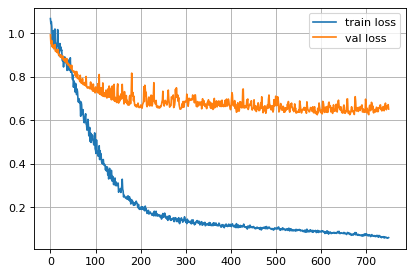

[[1.         0.99918852]
 [0.99918852 1.        ]]
r^2 train data:  0.9634301102922805


[[1.         0.59599745]
 [0.59599745 1.        ]]
r^2 val data:  0.33667174468716676


[[1.         0.69773382]
 [0.69773382 1.        ]]
r^2 train data:  0.3495471119937952


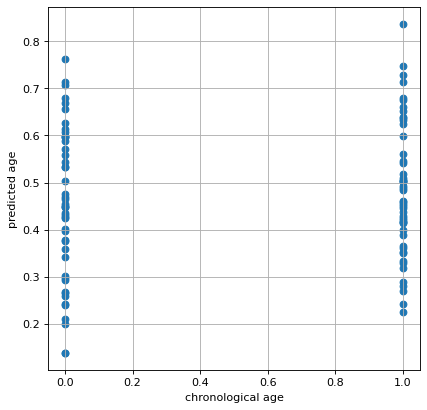

[[1.        0.1084153]
 [0.1084153 1.       ]]
r^2 val data:  -0.03385196688685799


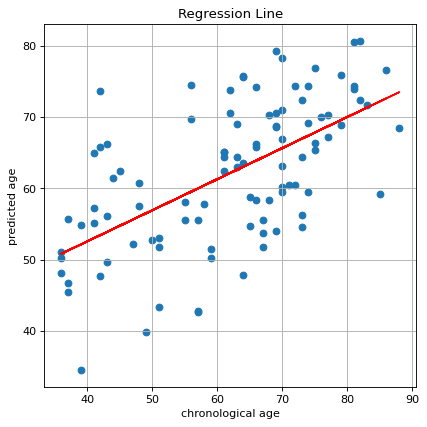

切片: 35.153092868116396
傾き: 0.43576446460274165
Kfold: 2 ::: epoch: 100, loss: 0.5945436839873974, val loss: 0.7149120420217514
Kfold: 2 ::: epoch: 200, loss: 0.22044978118859804, val loss: 0.6097668558359146
Kfold: 2 ::: epoch: 300, loss: 0.15499565922296965, val loss: 0.6208576560020447
Kfold: 2 ::: epoch: 400, loss: 0.12658430406680474, val loss: 0.6058080568909645
Kfold: 2 ::: epoch: 500, loss: 0.11273611336946487, val loss: 0.5804316401481628
Kfold: 2 ::: epoch: 600, loss: 0.09803673051870786, val loss: 0.5640835389494896
Kfold: 2 ::: epoch: 700, loss: 0.08671802626206325, val loss: 0.5532326996326447
save_epochs:716


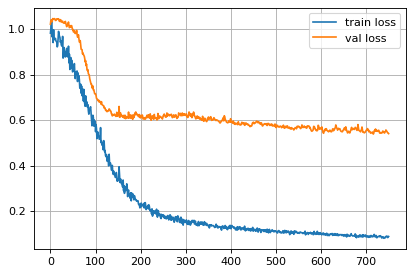

[[1.         0.99904423]
 [0.99904423 1.        ]]
r^2 train data:  0.9668990655706057


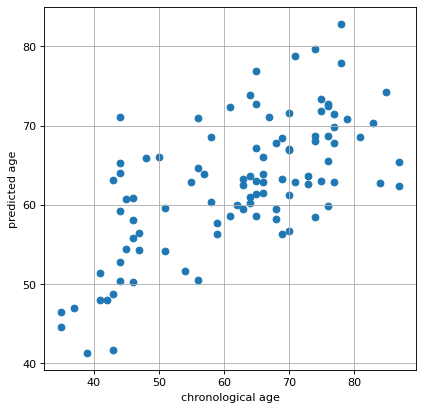

[[1.         0.66534907]
 [0.66534907 1.        ]]
r^2 val data:  0.43936177800885556


[[1.         0.65820735]
 [0.65820735 1.        ]]
r^2 train data:  0.37204821064167426


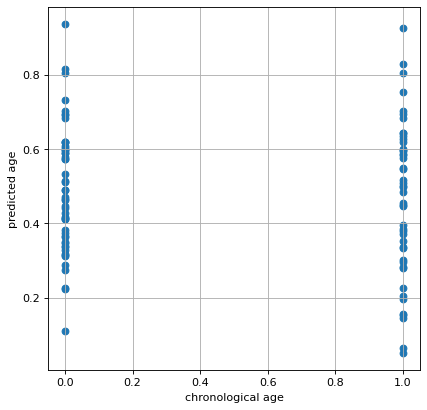

[[ 1.         -0.05650172]
 [-0.05650172  1.        ]]
r^2 val data:  -0.18065568217694694


切片: 36.88049532497041
傾き: 0.414774251524239
Kfold: 3 ::: epoch: 100, loss: 0.47249013070876783, val loss: 0.8032246381044388
Kfold: 3 ::: epoch: 200, loss: 0.2074472434245623, val loss: 0.7835610061883926
Kfold: 3 ::: epoch: 300, loss: 0.1333935260772705, val loss: 0.7727402523159981
Kfold: 3 ::: epoch: 400, loss: 0.12418046135168809, val loss: 0.7713289707899094
Kfold: 3 ::: epoch: 500, loss: 0.10967320031844653, val loss: 0.762161523103714
Kfold: 3 ::: epoch: 600, loss: 0.09580382704734802, val loss: 0.7519359439611435
Kfold: 3 ::: epoch: 700, loss: 0.09176271867293578, val loss: 0.7489066421985626
save_epochs:660


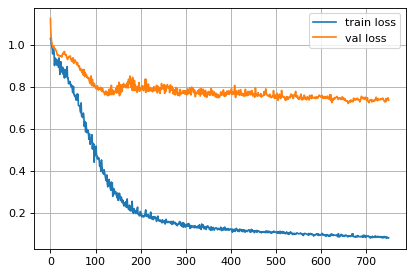

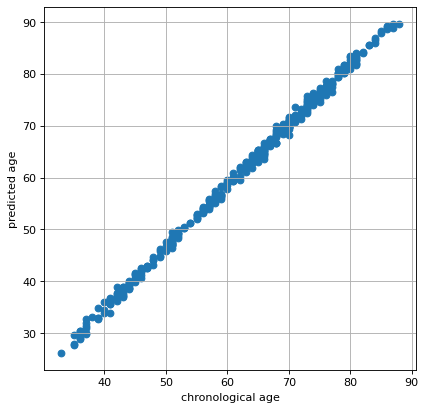

[[1.         0.99893578]
 [0.99893578 1.        ]]
r^2 train data:  0.9570693419758449


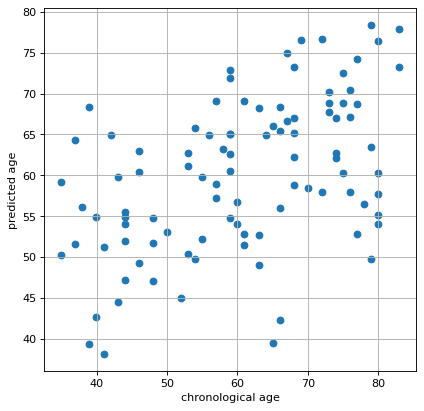

[[1.         0.48588133]
 [0.48588133 1.        ]]
r^2 val data:  0.19409276892775618


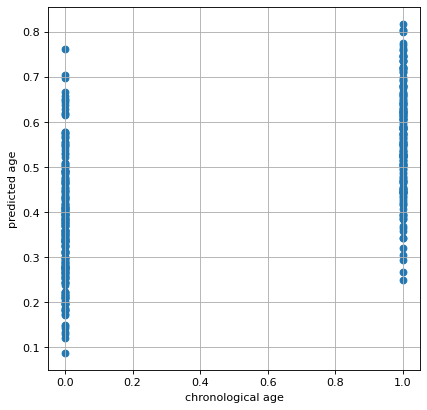

[[1.         0.60649366]
 [0.60649366 1.        ]]
r^2 train data:  0.28303321641119283


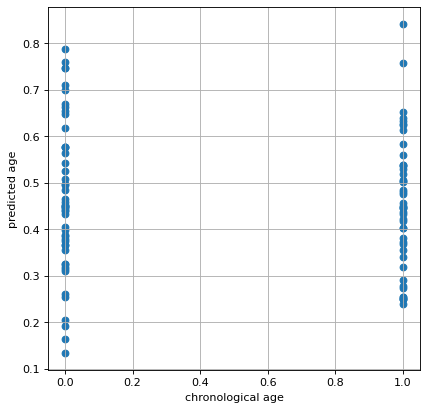

[[ 1.         -0.03540283]
 [-0.03540283  1.        ]]
r^2 val data:  -0.11363267117083464


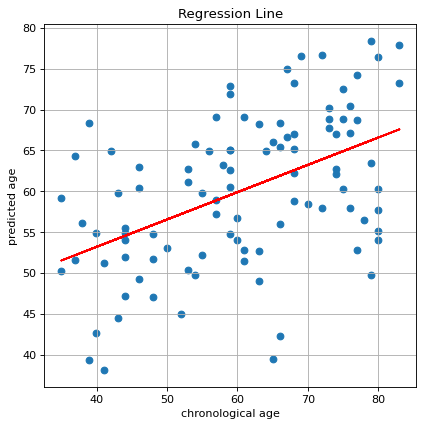

切片: 39.8659062076413
傾き: 0.333839469112821
Kfold: 4 ::: epoch: 100, loss: 0.43704344905339754, val loss: 1.4490709453821182
Kfold: 4 ::: epoch: 200, loss: 0.19913748365182143, val loss: 1.4196428805589676
Kfold: 4 ::: epoch: 300, loss: 0.13351202354981348, val loss: 1.353127345442772


KeyboardInterrupt: 

In [50]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_all_1  = []
test_label_all_1 = []

test_idx_all_1   = []
train_idx_all_1  = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_aal)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_label = train_model(data_aal,
                                       data_label,
                                       train_idx  = train_idx,
                                       test_idx   = test_idx,
                                       epochs     = 750,
                                       d_model    = 256,
                                       n_splits   = n_splits,
                                       hidden_dim = 1048,
                                       nhead      = 32,
                                       hidden_dim_transformer = 2,
                                       pos_drop    = 0.1,
                                       trans_drop = 0.2,
                                       fc_drop = 0.1
                                      )
    test_pred_all_1.append(test_pred)
    test_label_all_1.append(test_label)
    test_idx_all_1.append(test_idx)
    train_idx_all_1.append(train_idx)

LinearRegression()

<Figure size 480x480 with 0 Axes>

Text(0.5, 1.0, 'Regression Line')

Text(0.5, 0, 'chronological age')

Text(0, 0.5, 'predicted age')

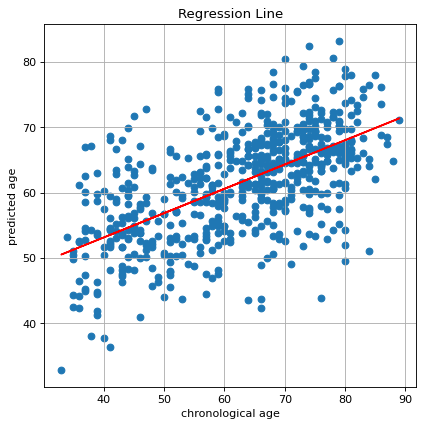

相関係数:  0.5976849543685522
r^2 test data:  0.3520957226671383
切片:  38.24666780351893
傾き:  0.37255207472637786


In [222]:
for i in range(n_splits):
    if not i:
        test_label = test_label_all_1[i]
    else:
        test_label = np.concatenate([test_label,test_label_all_1[i]])
        
for i in range(n_splits):
    if not i:
        test_pred = test_pred_all_1[i].mean(axis=0)
    else:
        test_pred = np.concatenate([test_pred,test_pred_all_1[i].mean(axis=0)])

lr = LinearRegression()
lr.fit(test_label[:,0:1]*age_std+age_mean,test_pred[:,0]*age_std+age_mean)

plt.figure(figsize=(6, 6), dpi=80)
plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[:,0]*age_std+age_mean)#散布図をプロット
plt.plot(test_label[:,0]*age_std+age_mean,
         lr.predict(test_label[:,0:1]*age_std+age_mean), color = 'red')#回帰直線をプロット

plt.title('Regression Line')   # 図のタイトル
plt.xlabel('chronological age')# x軸のラベル
plt.ylabel('predicted age')    # y軸のラベル
plt.grid()                     # グリッド線を表示
plt.show()                     # 図の表示

print('相関係数: ', np.corrcoef(test_label[:,0],test_pred[:,0])[0,1])
print('r^2 test data: ', r2_score(test_label[:,0],test_pred[:,0]))
print('切片: ', lr.intercept_)
print('傾き: ', lr.coef_[0])

<Figure size 480x480 with 0 Axes>

相関係数: 0.03651394771037153
p値: 0.366008275798656


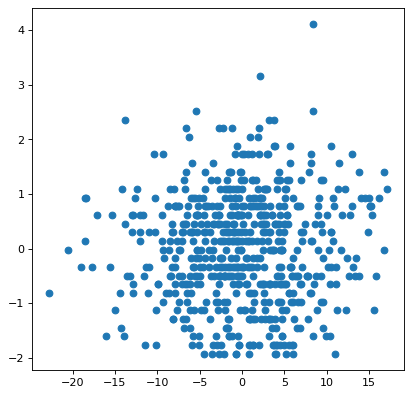

In [306]:
diff = test_pred[:,0]*age_std + age_mean - lr.predict(test_label[:,0:1]*age_std+age_mean)

plt.figure(figsize=(6, 6), dpi=80)
plt.scatter(diff,data_label[:,2])

corr,p = pearsonr(diff,data_label[:,2])
print("相関係数:", corr)
print("p値:", p)

### 学習 bold 2

Nested Kfold ::: 1
Kfold: 1 ::: epoch: 100, loss: 0.8832216125268203, val loss: 0.9083590358495712
Kfold: 1 ::: epoch: 200, loss: 0.6509078167952024, val loss: 0.8226158767938614
Kfold: 1 ::: epoch: 300, loss: 0.4294308378146245, val loss: 0.7517311722040176
Kfold: 1 ::: epoch: 400, loss: 0.29265681023781115, val loss: 0.7292892038822174
Kfold: 1 ::: epoch: 500, loss: 0.2438480590398495, val loss: 0.7281181961297989
Kfold: 1 ::: epoch: 600, loss: 0.21132550675135392, val loss: 0.7111282795667648
Kfold: 1 ::: epoch: 700, loss: 0.18584201427606437, val loss: 0.6998592168092728
save_epochs:725


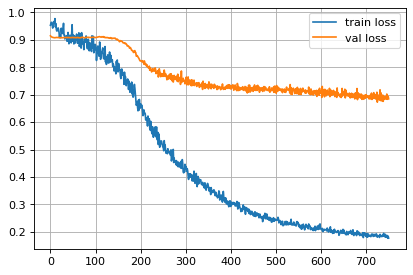

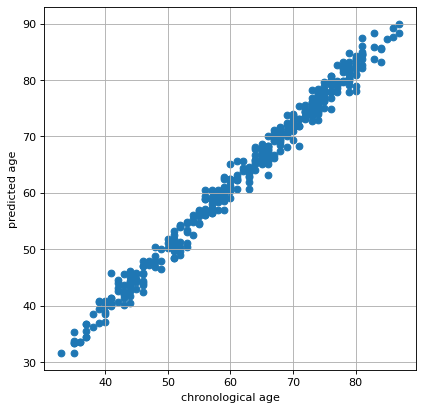

[[1.         0.99406542]
 [0.99406542 1.        ]]
r^2 train data:  0.9697856958025839


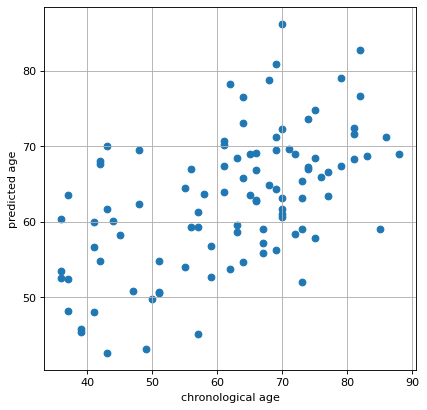

[[1.         0.55311144]
 [0.55311144 1.        ]]
r^2 val data:  0.29012536506577824


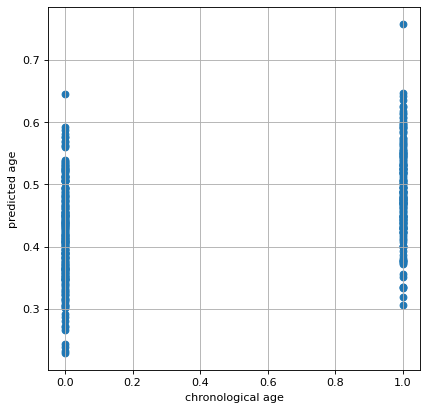

[[1.         0.41078127]
 [0.41078127 1.        ]]
r^2 train data:  0.10973048051388368


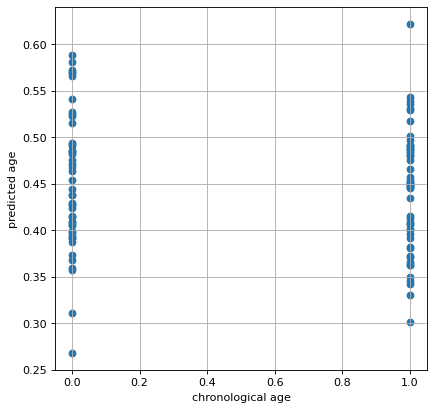

[[ 1.         -0.07749464]
 [-0.07749464  1.        ]]
r^2 val data:  -0.05895477560709361


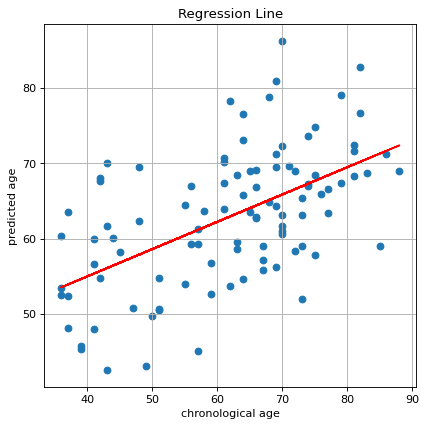

切片: 40.53310913762461
傾き: 0.3617931801945621


AxisError: axis 2 is out of bounds for array of dimension 2

In [328]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_all_2  = []
test_label_all_2 = []

test_idx_all_2   = []
train_idx_all_2  = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_aal)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_label = train_model(data_aal,
                                       data_label,
                                       train_idx  = train_idx,
                                       test_idx   = test_idx,
                                       epochs     = 750,
                                       d_model    = 128,
                                       n_splits   = n_splits,
                                       hidden_dim = 128,
                                       nhead      = 32,
                                       hidden_dim_transformer = 2,
                                       pos_drop    = 0.1,
                                       trans_drop = 0.1,
                                       fc_drop = 0.1
                                      )
    test_pred_all_2.append(test_pred)
    test_label_all_2.append(test_label)
    test_idx_all_2.append(test_idx)
    train_idx_all_2.append(train_idx)

Nested Kfold ::: 1
Kfold: 1 ::: epoch: 100, loss: 0.01648865074205857, val loss: 0.6819419264793396
Kfold: 1 ::: epoch: 200, loss: 0.011366816165928658, val loss: 0.6209666654467583
Kfold: 1 ::: epoch: 300, loss: 0.010645865319439998, val loss: 0.6106001138687134
Kfold: 1 ::: epoch: 400, loss: 0.006808657234964462, val loss: 0.5707999616861343
Kfold: 1 ::: epoch: 500, loss: 0.007969459572520394, val loss: 0.5666797235608101
Kfold: 1 ::: epoch: 600, loss: 0.007290500287826245, val loss: 0.5645884126424789
Kfold: 1 ::: epoch: 700, loss: 0.0064370062273855395, val loss: 0.5757810920476913
save_epochs:707


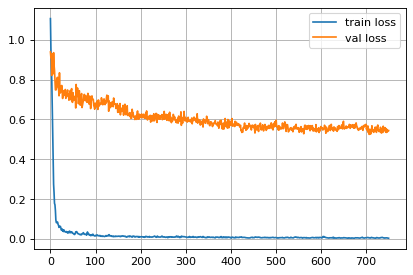

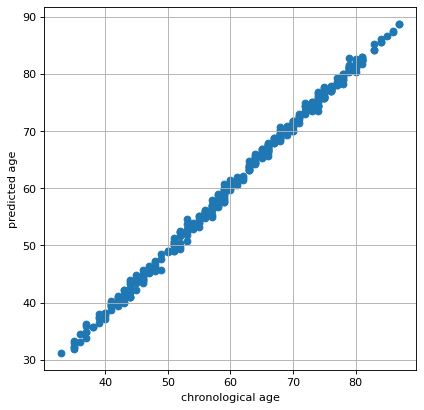

[[1.       0.998739]
 [0.998739 1.      ]]
r^2 train data:  0.9878866064332709


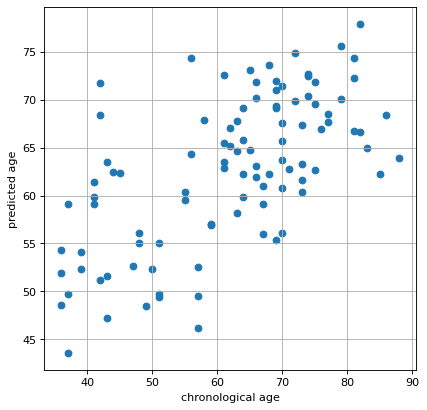

[[1.         0.63411112]
 [0.63411112 1.        ]]
r^2 val data:  0.39411477090605096


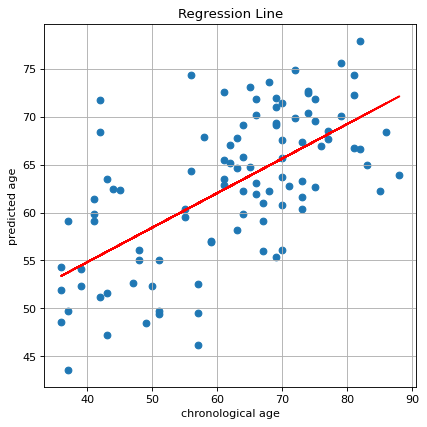

切片: 40.44496858607112
傾き: 0.3597815089365687
Kfold: 2 ::: epoch: 100, loss: 0.02010207587423233, val loss: 0.5249716266989708
Kfold: 2 ::: epoch: 200, loss: 0.012931719923821779, val loss: 0.48939015716314316
Kfold: 2 ::: epoch: 300, loss: 0.009556453316830672, val loss: 0.45021310076117516
Kfold: 2 ::: epoch: 400, loss: 0.00936319070080152, val loss: 0.41103545576334
Kfold: 2 ::: epoch: 500, loss: 0.006150419931285656, val loss: 0.4373067691922188
Kfold: 2 ::: epoch: 600, loss: 0.005427950491698889, val loss: 0.37813155353069305
Kfold: 2 ::: epoch: 700, loss: 0.006228629284753249, val loss: 0.43910420686006546
save_epochs:600


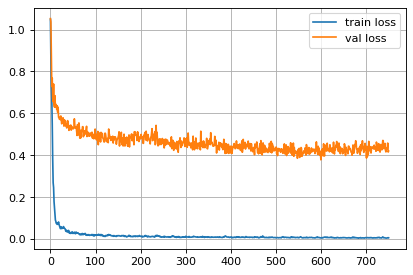

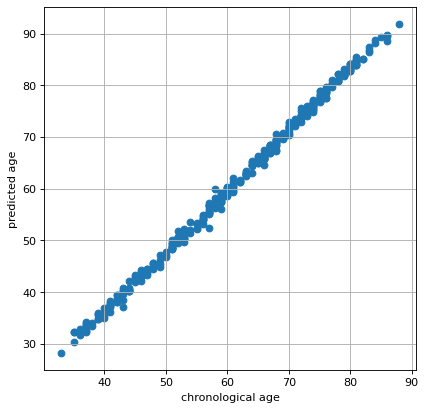

[[1.         0.99881517]
 [0.99881517 1.        ]]
r^2 train data:  0.9645498988214983


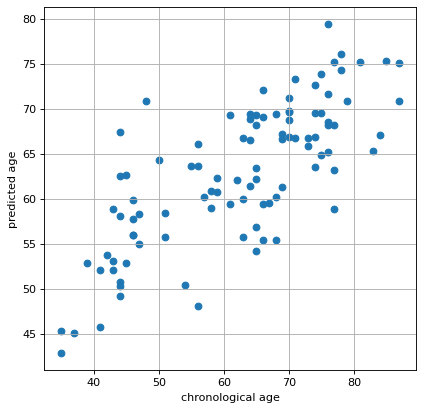

[[1.         0.75997076]
 [0.75997076 1.        ]]
r^2 val data:  0.545634067443882


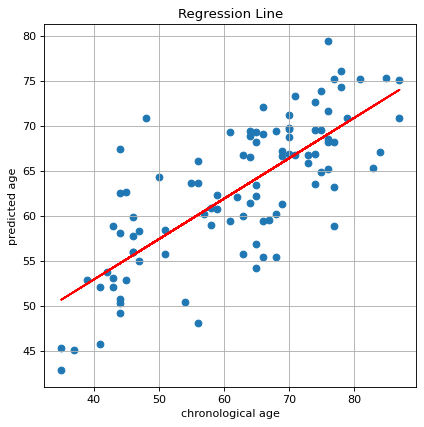

切片: 35.00416140923086
傾き: 0.4478439026065646
Kfold: 3 ::: epoch: 100, loss: 0.020576837974099014, val loss: 0.8776939809322357
Kfold: 3 ::: epoch: 200, loss: 0.012551181806394687, val loss: 0.7638544142246246
Kfold: 3 ::: epoch: 300, loss: 0.011966669770817343, val loss: 0.7158542573451996
Kfold: 3 ::: epoch: 400, loss: 0.007378073874861002, val loss: 0.7013250589370728
Kfold: 3 ::: epoch: 500, loss: 0.00664638951778985, val loss: 0.6884183287620544
Kfold: 3 ::: epoch: 600, loss: 0.011445659320228375, val loss: 0.6544141471385956
Kfold: 3 ::: epoch: 700, loss: 0.0049061722551973965, val loss: 0.6677281856536865
save_epochs:748


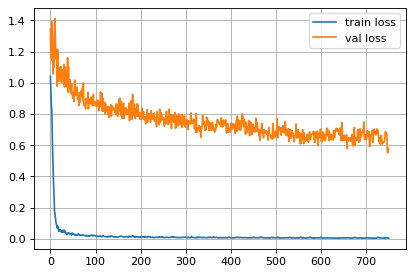

[[1.         0.99846129]
 [0.99846129 1.        ]]
r^2 train data:  0.9874694737710786


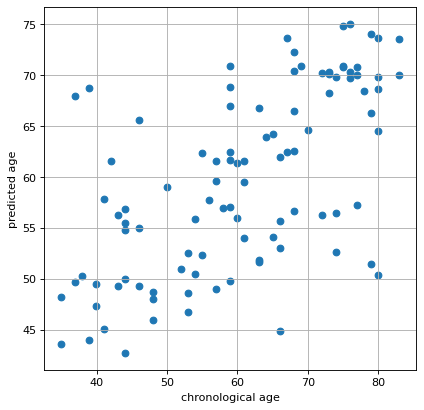

[[1.         0.62711472]
 [0.62711472 1.        ]]
r^2 val data:  0.386772087624469


切片: 34.38860893998286
傾き: 0.416957387844682
Kfold: 4 ::: epoch: 100, loss: 0.020626733294473246, val loss: 1.055897444486618
Kfold: 4 ::: epoch: 200, loss: 0.015785708020512875, val loss: 1.0101043730974197
Kfold: 4 ::: epoch: 300, loss: 0.00996706523717596, val loss: 1.0743573009967804
Kfold: 4 ::: epoch: 400, loss: 0.0086621016335602, val loss: 0.9659676998853683
Kfold: 4 ::: epoch: 500, loss: 0.007578668542779409, val loss: 0.9914730042219162
Kfold: 4 ::: epoch: 600, loss: 0.007610380506286254, val loss: 0.9596325904130936
Kfold: 4 ::: epoch: 700, loss: 0.005339934705541684, val loss: 0.9796569347381592
save_epochs:655


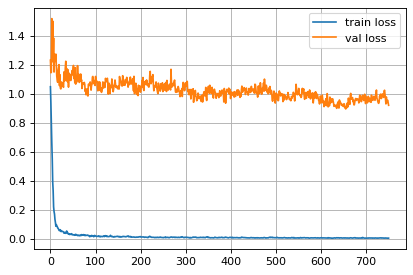

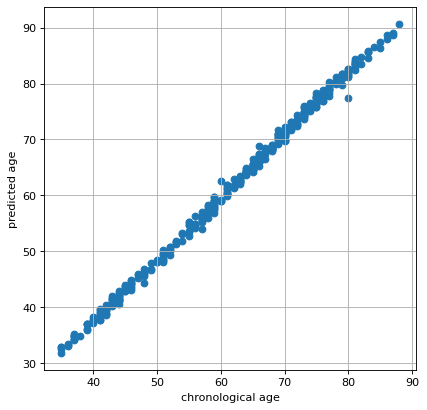

[[1.         0.99877683]
 [0.99877683 1.        ]]
r^2 train data:  0.9826750319219877


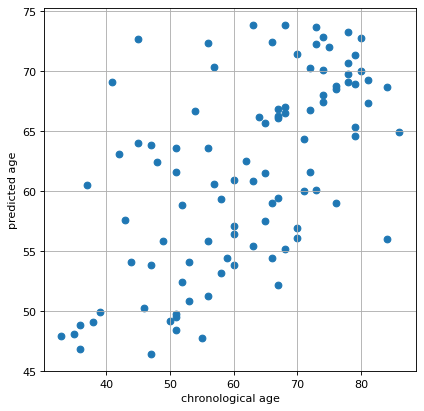

[[1.         0.60714624]
 [0.60714624 1.        ]]
r^2 val data:  0.36698817798390115


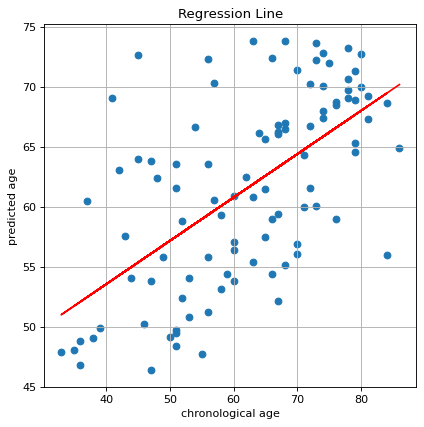

切片: 39.07338541316459
傾き: 0.3618512586056697
Kfold: 5 ::: epoch: 100, loss: 0.017694042852291696, val loss: 0.717902883887291
Kfold: 5 ::: epoch: 200, loss: 0.011119238136766048, val loss: 0.7313244193792343
Kfold: 5 ::: epoch: 300, loss: 0.010221791740220327, val loss: 0.7211310639977455
Kfold: 5 ::: epoch: 400, loss: 0.008728094757176362, val loss: 0.6976199448108673
Kfold: 5 ::: epoch: 500, loss: 0.008340189484162973, val loss: 0.6793835461139679
Kfold: 5 ::: epoch: 600, loss: 0.006158690577229628, val loss: 0.6970899105072021
Kfold: 5 ::: epoch: 700, loss: 0.006508676388945717, val loss: 0.7022177428007126
save_epochs:745


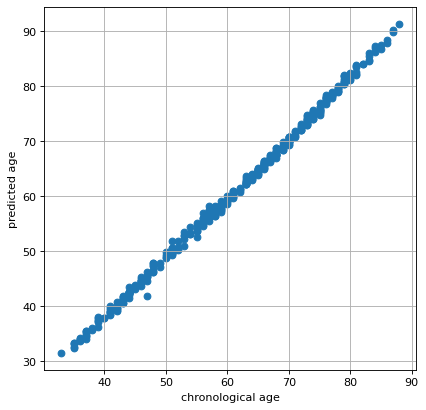

[[1.         0.99896961]
 [0.99896961 1.        ]]
r^2 train data:  0.9896413971810092


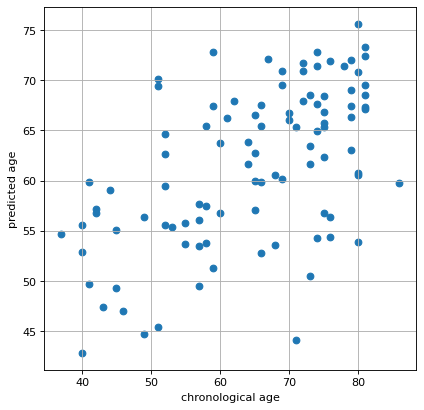

[[1.         0.56226881]
 [0.56226881 1.        ]]
r^2 val data:  0.25383469629004174


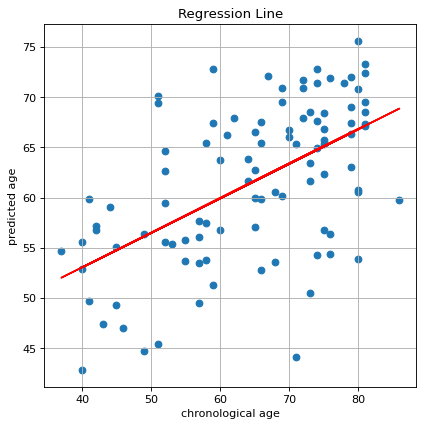

切片: 39.30866668009806
傾き: 0.3437081324723663
Nested Kfold ::: 2
Kfold: 1 ::: epoch: 100, loss: 0.016937615421529, val loss: 0.7433678805828094
Kfold: 1 ::: epoch: 200, loss: 0.013996958302763792, val loss: 0.6465540677309036
Kfold: 1 ::: epoch: 300, loss: 0.00918468707599319, val loss: 0.6454527825117111
Kfold: 1 ::: epoch: 400, loss: 0.00731733525530077, val loss: 0.6118959039449692
Kfold: 1 ::: epoch: 500, loss: 0.007670014344442349, val loss: 0.6145090758800507
Kfold: 1 ::: epoch: 600, loss: 0.007471613335208251, val loss: 0.6039722338318825
Kfold: 1 ::: epoch: 700, loss: 0.005797738119816551, val loss: 0.5958001613616943
save_epochs:671


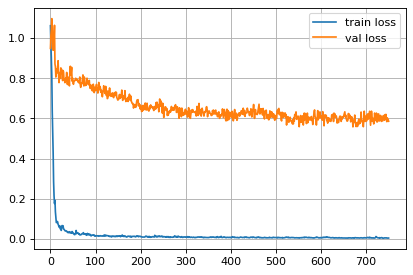

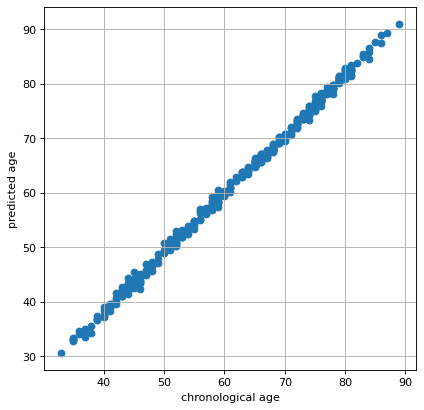

[[1.         0.99907167]
 [0.99907167 1.        ]]
r^2 train data:  0.9905624351923434


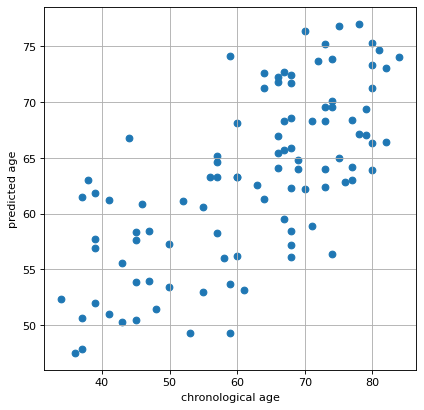

[[1.         0.69166555]
 [0.69166555 1.        ]]
r^2 val data:  0.45309633048160924


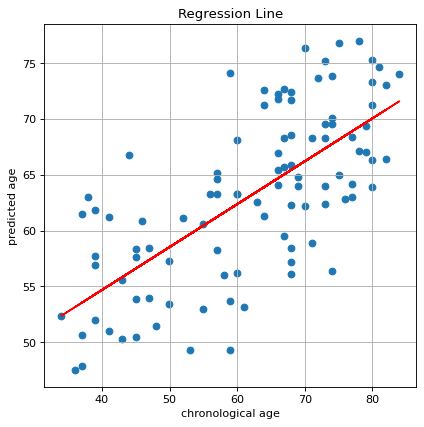

切片: 39.31115662000902
傾き: 0.38436687706500267
Kfold: 2 ::: epoch: 100, loss: 0.015814373806978647, val loss: 0.6046889647841454
Kfold: 2 ::: epoch: 200, loss: 0.012011424960711828, val loss: 0.5291043072938919
Kfold: 2 ::: epoch: 300, loss: 0.01217422577051016, val loss: 0.5509745702147484
Kfold: 2 ::: epoch: 400, loss: 0.008513751368109997, val loss: 0.516597680747509
Kfold: 2 ::: epoch: 500, loss: 0.00896343531516882, val loss: 0.5184531286358833
Kfold: 2 ::: epoch: 600, loss: 0.006395347380580811, val loss: 0.5234044194221497
Kfold: 2 ::: epoch: 700, loss: 0.004806262405159382, val loss: 0.5398425757884979
save_epochs:720


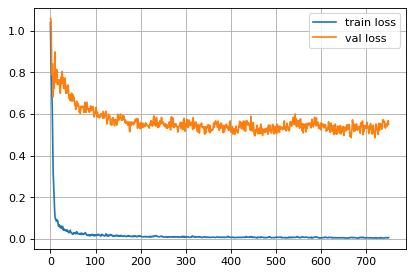

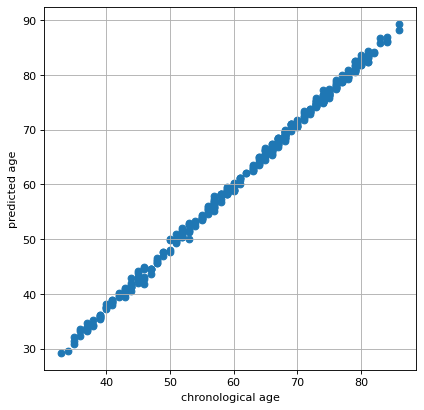

[[1.        0.9992372]
 [0.9992372 1.       ]]
r^2 train data:  0.9808764233404969


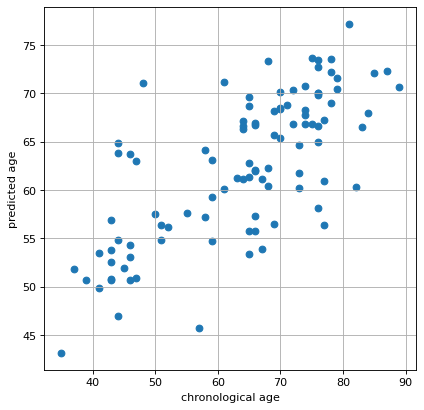

[[1.         0.72762292]
 [0.72762292 1.        ]]
r^2 val data:  0.4916291210548044


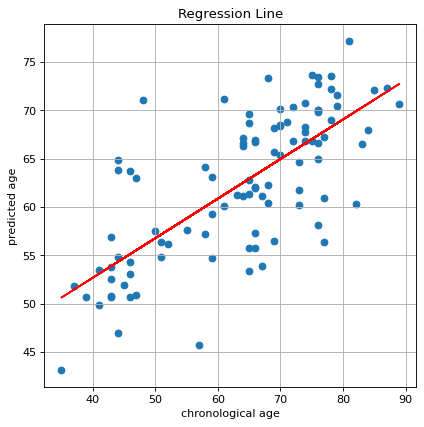

切片: 36.29648249121114
傾き: 0.4096511010397155
Kfold: 3 ::: epoch: 100, loss: 0.020622608036949083, val loss: 0.667627640068531
Kfold: 3 ::: epoch: 200, loss: 0.011493986902328638, val loss: 0.6490528434514999
Kfold: 3 ::: epoch: 300, loss: 0.00937700798161901, val loss: 0.6387455612421036
Kfold: 3 ::: epoch: 400, loss: 0.006186015975589936, val loss: 0.612667478621006
Kfold: 3 ::: epoch: 500, loss: 0.0057573349824031955, val loss: 0.6016354709863663
Kfold: 3 ::: epoch: 600, loss: 0.005573464485888298, val loss: 0.6148741617798805
Kfold: 3 ::: epoch: 700, loss: 0.005159155017911241, val loss: 0.6423318386077881
save_epochs:454


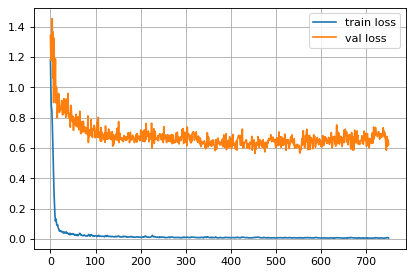

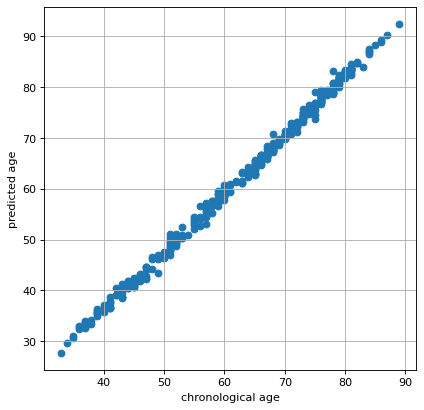

[[1.         0.99849474]
 [0.99849474 1.        ]]
r^2 train data:  0.9723729606354805


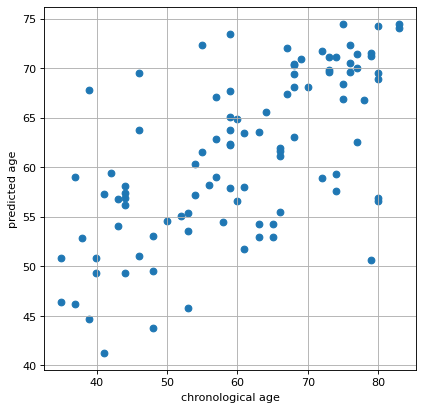

[[1.         0.65283078]
 [0.65283078 1.        ]]
r^2 val data:  0.4223094355100748


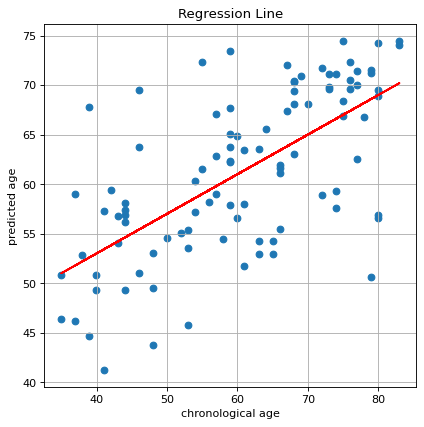

切片: 37.04348654876129
傾き: 0.39950068004964756
Kfold: 4 ::: epoch: 100, loss: 0.019973862629670363, val loss: 1.0278527587652206
Kfold: 4 ::: epoch: 200, loss: 0.015152963845489116, val loss: 1.00695039331913
Kfold: 4 ::: epoch: 300, loss: 0.012289314817350645, val loss: 1.0558684021234512
Kfold: 4 ::: epoch: 400, loss: 0.007752850974121919, val loss: 1.0200619995594025
Kfold: 4 ::: epoch: 500, loss: 0.0072575858077750756, val loss: 1.1161905974149704
Kfold: 4 ::: epoch: 600, loss: 0.005655372282490134, val loss: 1.0992033779621124
Kfold: 4 ::: epoch: 700, loss: 0.006020090381543224, val loss: 1.0473344326019287
save_epochs:745


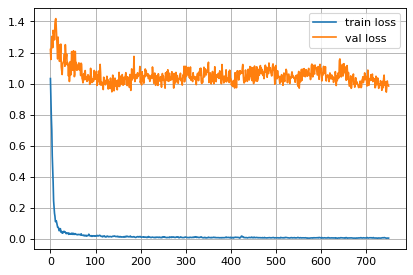

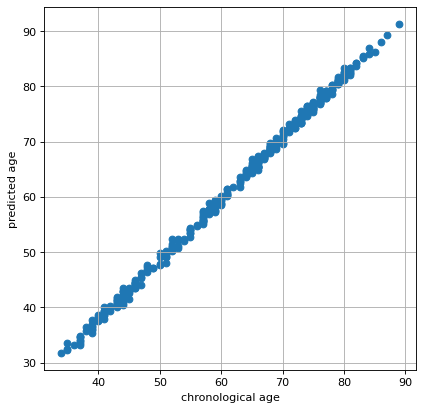

[[1.         0.99911578]
 [0.99911578 1.        ]]
r^2 train data:  0.9864535904714921


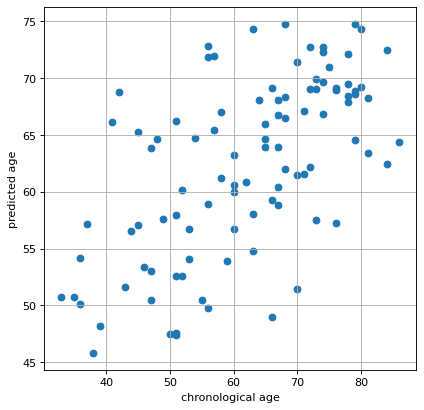

[[1.         0.61896651]
 [0.61896651 1.        ]]
r^2 val data:  0.38129771318629957


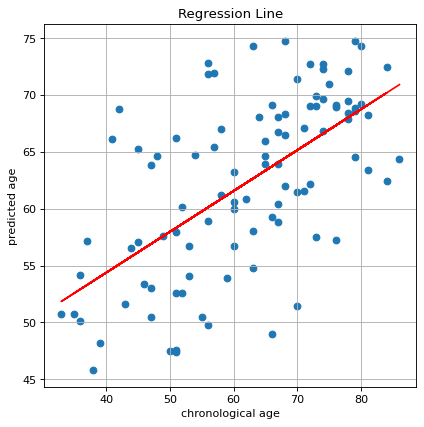

切片: 39.986918835391165
傾き: 0.35972254926436514
Kfold: 5 ::: epoch: 100, loss: 0.01728348885304653, val loss: 0.8073070496320724
Kfold: 5 ::: epoch: 200, loss: 0.014332917268173052, val loss: 0.8080984503030777
Kfold: 5 ::: epoch: 300, loss: 0.008602728243344106, val loss: 0.8128044009208679
Kfold: 5 ::: epoch: 400, loss: 0.007531162673750749, val loss: 0.7775125056505203
Kfold: 5 ::: epoch: 500, loss: 0.0061570859442536645, val loss: 0.7370339184999466
Kfold: 5 ::: epoch: 600, loss: 0.0062979086517141415, val loss: 0.7582692503929138
Kfold: 5 ::: epoch: 700, loss: 0.005634113501470823, val loss: 0.837224930524826
save_epochs:593


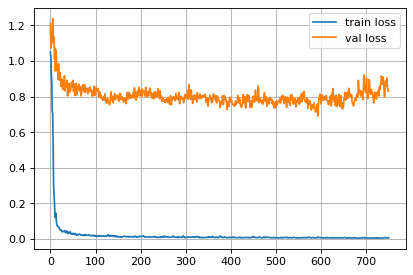

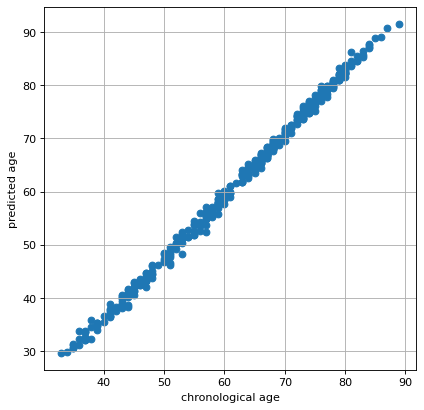

[[1.         0.99860129]
 [0.99860129 1.        ]]
r^2 train data:  0.9673330236389198


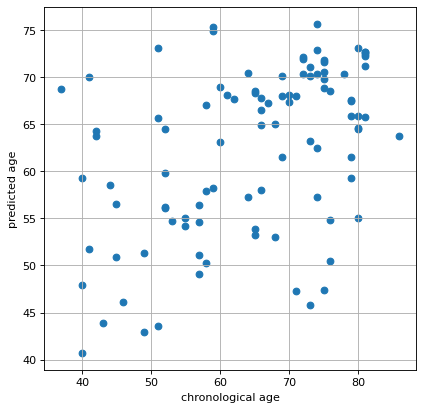

[[1.         0.45373259]
 [0.45373259 1.        ]]
r^2 val data:  0.11764113869352288


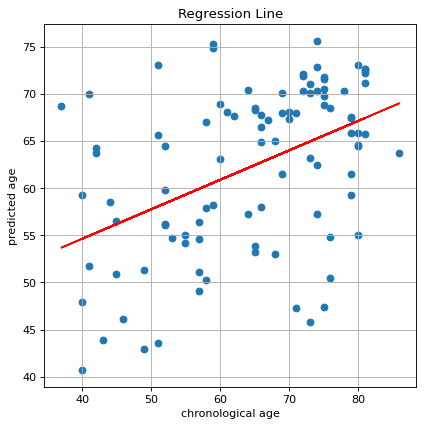

切片: 42.12433415596779
傾き: 0.3126821245412677
Nested Kfold ::: 3
Kfold: 1 ::: epoch: 100, loss: 0.014535532118036197, val loss: 0.6802345514297485
Kfold: 1 ::: epoch: 200, loss: 0.010040932908081092, val loss: 0.6387515366077423
Kfold: 1 ::: epoch: 300, loss: 0.012474754825234413, val loss: 0.5874455124139786
Kfold: 1 ::: epoch: 400, loss: 0.008421575005810995, val loss: 0.6021526455879211
Kfold: 1 ::: epoch: 500, loss: 0.007389278867496894, val loss: 0.5943408161401749
Kfold: 1 ::: epoch: 600, loss: 0.006655737686042602, val loss: 0.5588973164558411
Kfold: 1 ::: epoch: 700, loss: 0.0073933804121155, val loss: 0.596182569861412
save_epochs:569


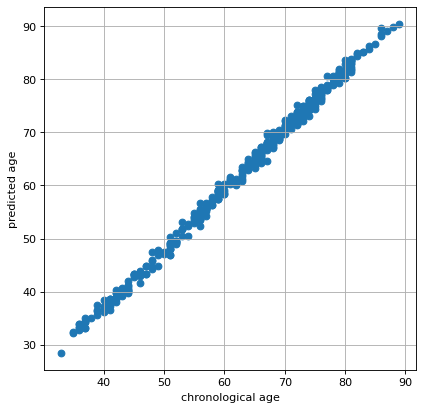

[[1.         0.99823486]
 [0.99823486 1.        ]]
r^2 train data:  0.9790933395389965


[[1.         0.65897174]
 [0.65897174 1.        ]]
r^2 val data:  0.426871394279679


切片: 38.28589184887173
傾き: 0.39691303012733953
Kfold: 2 ::: epoch: 100, loss: 0.021474429621146277, val loss: 0.5807770118117332
Kfold: 2 ::: epoch: 200, loss: 0.011075252237228246, val loss: 0.5455025276169181
Kfold: 2 ::: epoch: 300, loss: 0.011696118145034863, val loss: 0.5383674800395966
Kfold: 2 ::: epoch: 400, loss: 0.008640061920652023, val loss: 0.5487247742712498
Kfold: 2 ::: epoch: 500, loss: 0.006431553548631759, val loss: 0.5438374588266015
Kfold: 2 ::: epoch: 600, loss: 0.005148324560230741, val loss: 0.5386041384190321
Kfold: 2 ::: epoch: 700, loss: 0.006423972815705033, val loss: 0.5243580844253302
save_epochs:673


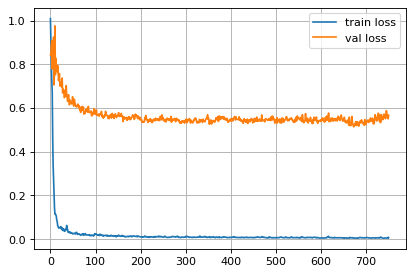

[[1.         0.99903988]
 [0.99903988 1.        ]]
r^2 train data:  0.9886874185263815


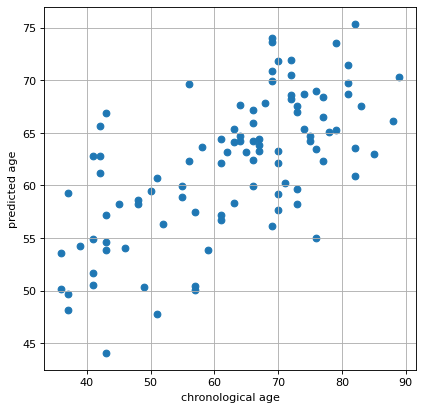

[[1.        0.6569607]
 [0.6569607 1.       ]]
r^2 val data:  0.3957486684578103


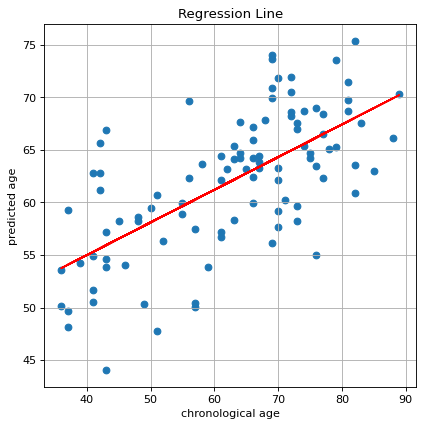

切片: 42.581379802644406
傾き: 0.31049534910684834
Kfold: 3 ::: epoch: 100, loss: 0.02464309449379261, val loss: 0.7689072340726852
Kfold: 3 ::: epoch: 200, loss: 0.01396170910447836, val loss: 0.8139074146747589
Kfold: 3 ::: epoch: 300, loss: 0.011653089600328643, val loss: 0.7867175042629242
Kfold: 3 ::: epoch: 400, loss: 0.007854198750395041, val loss: 0.7694440931081772
Kfold: 3 ::: epoch: 500, loss: 0.007159702408199127, val loss: 0.708461120724678
Kfold: 3 ::: epoch: 600, loss: 0.00649939334163299, val loss: 0.7348546534776688
Kfold: 3 ::: epoch: 700, loss: 0.006405929784075572, val loss: 0.7059705704450607
save_epochs:669


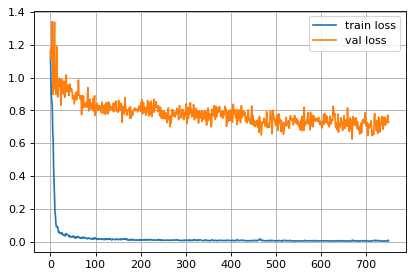

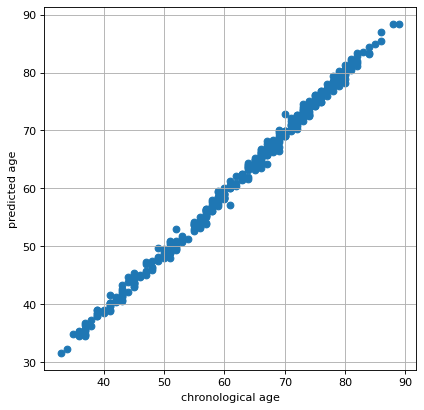

[[1.        0.9982515]
 [0.9982515 1.       ]]
r^2 train data:  0.9926975399482562


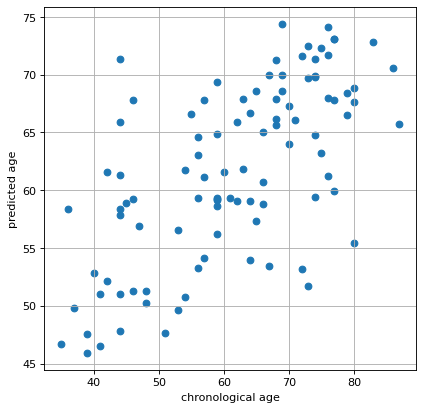

[[1.         0.64854004]
 [0.64854004 1.        ]]
r^2 val data:  0.4152013816570478


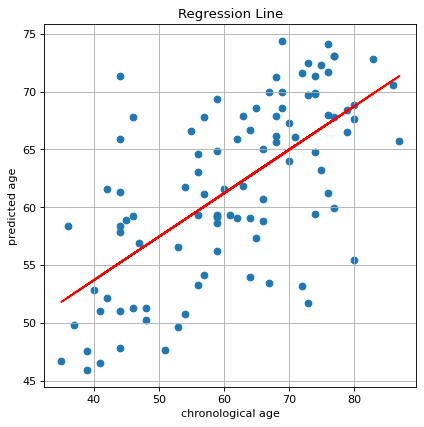

切片: 38.66215842318395
傾き: 0.37570701441631227
Kfold: 4 ::: epoch: 100, loss: 0.01933661876962735, val loss: 1.1226498484611511
Kfold: 4 ::: epoch: 200, loss: 0.014723002194212033, val loss: 1.0207616835832596
Kfold: 4 ::: epoch: 300, loss: 0.009601198351727082, val loss: 1.1073288917541504
Kfold: 4 ::: epoch: 400, loss: 0.009816279419912742, val loss: 1.0836488455533981
Kfold: 4 ::: epoch: 500, loss: 0.006542146456642793, val loss: 1.116032898426056
Kfold: 4 ::: epoch: 600, loss: 0.006221544087076416, val loss: 1.0470175296068192
Kfold: 4 ::: epoch: 700, loss: 0.005877339675162847, val loss: 1.1285915225744247
save_epochs:539


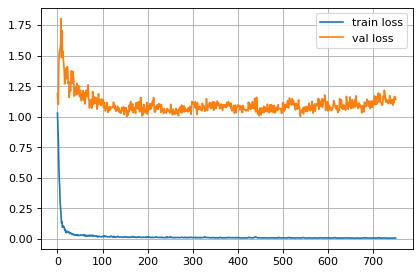

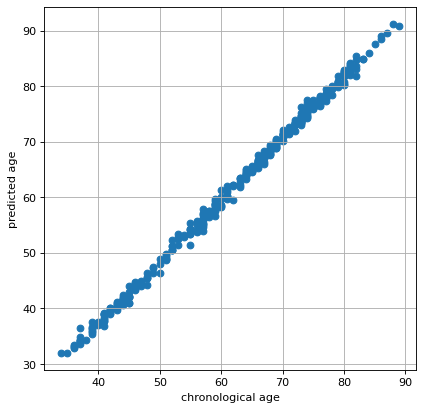

[[1.         0.99881266]
 [0.99881266 1.        ]]
r^2 train data:  0.9833671261434681


[[1.         0.60955802]
 [0.60955802 1.        ]]
r^2 val data:  0.3696706400983706


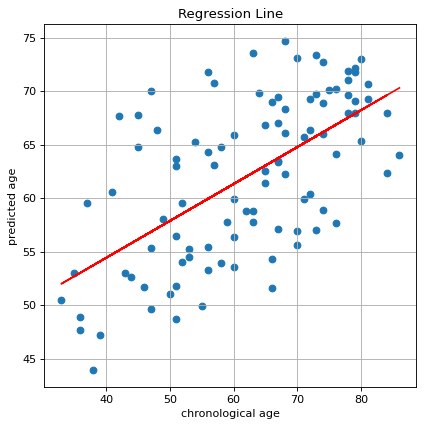

切片: 40.61941588006492
傾き: 0.3450653708888071
Kfold: 5 ::: epoch: 100, loss: 0.017507657157973602, val loss: 0.6694925352931023
Kfold: 5 ::: epoch: 200, loss: 0.01576501575226967, val loss: 0.645947678014636
Kfold: 5 ::: epoch: 300, loss: 0.00883277623842542, val loss: 0.6744737401604652
Kfold: 5 ::: epoch: 400, loss: 0.00739074401700726, val loss: 0.6336135268211365
Kfold: 5 ::: epoch: 500, loss: 0.006084818034791029, val loss: 0.6230724696069956
Kfold: 5 ::: epoch: 600, loss: 0.0053704920439766, val loss: 0.6207001376897097
Kfold: 5 ::: epoch: 700, loss: 0.004834099010062905, val loss: 0.5971256233751774
save_epochs:610


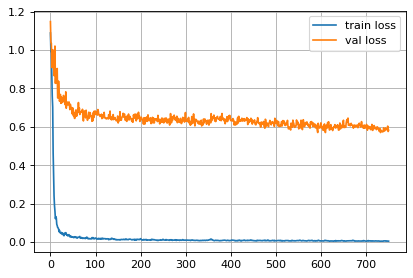

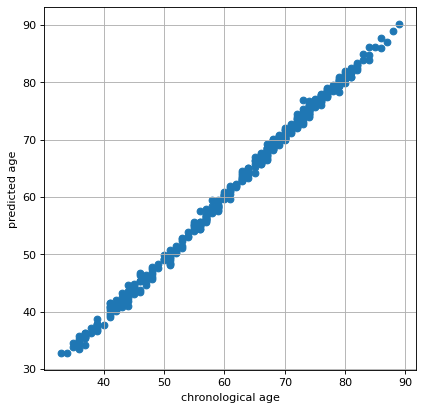

[[1.         0.99850651]
 [0.99850651 1.        ]]
r^2 train data:  0.992432075465937


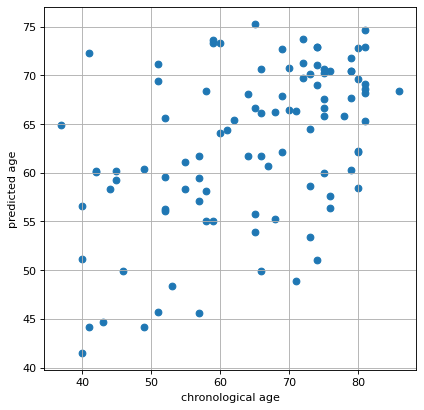

[[1.         0.48675112]
 [0.48675112 1.        ]]
r^2 val data:  0.1937631607706506


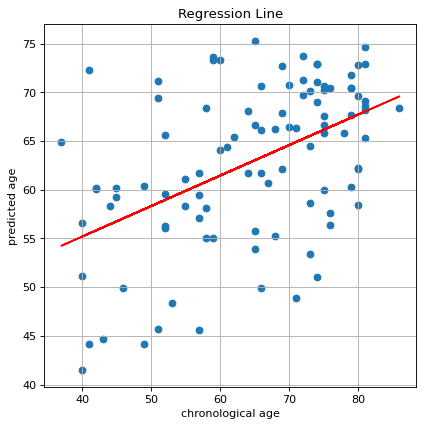

切片: 42.667738229397514
傾き: 0.3129969070217795
Nested Kfold ::: 4
Kfold: 1 ::: epoch: 100, loss: 0.017077940802734632, val loss: 0.6691727340221405
Kfold: 1 ::: epoch: 200, loss: 0.01081094815610693, val loss: 0.6517151817679405
Kfold: 1 ::: epoch: 300, loss: 0.012168832194919769, val loss: 0.6051660478115082
Kfold: 1 ::: epoch: 400, loss: 0.008271280783586778, val loss: 0.5552143380045891
Kfold: 1 ::: epoch: 500, loss: 0.009391715893378625, val loss: 0.5888169258832932
Kfold: 1 ::: epoch: 600, loss: 0.0073853430893415445, val loss: 0.5566207468509674
Kfold: 1 ::: epoch: 700, loss: 0.007049545108412321, val loss: 0.561707392334938
save_epochs:726


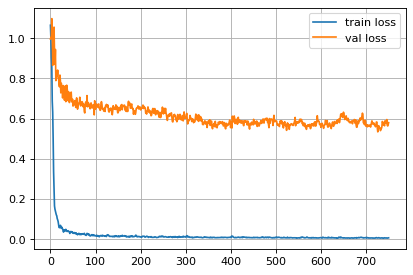

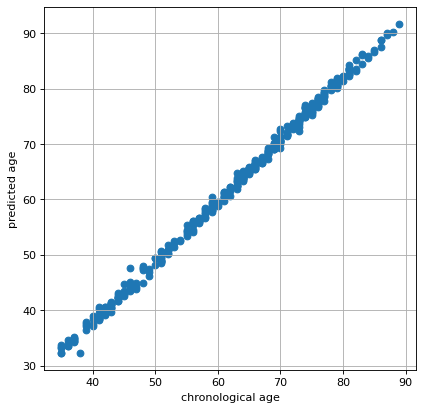

[[1.         0.99889153]
 [0.99889153 1.        ]]
r^2 train data:  0.9860191036403276


[[1.         0.67712009]
 [0.67712009 1.        ]]
r^2 val data:  0.4463083121981746


切片: 38.331297155917184
傾き: 0.3945602636336745
Kfold: 2 ::: epoch: 100, loss: 0.016453572907126866, val loss: 0.5249173194169998
Kfold: 2 ::: epoch: 200, loss: 0.011918859771237923, val loss: 0.5205811709165573
Kfold: 2 ::: epoch: 300, loss: 0.012769498647405552, val loss: 0.5445182099938393
Kfold: 2 ::: epoch: 400, loss: 0.010528767230705572, val loss: 0.5193577483296394
Kfold: 2 ::: epoch: 500, loss: 0.00788320959187471, val loss: 0.5085141211748123
Kfold: 2 ::: epoch: 600, loss: 0.007709128316491842, val loss: 0.5211410410702229
Kfold: 2 ::: epoch: 700, loss: 0.00643945954596767, val loss: 0.5242406874895096
save_epochs:518


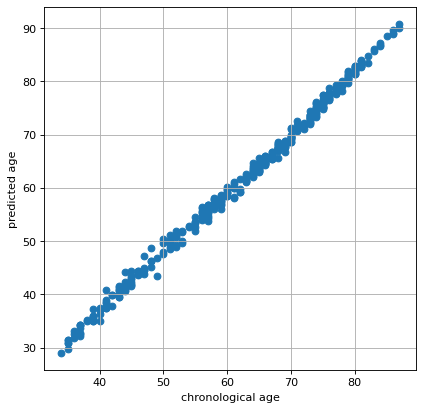

[[1.        0.9980458]
 [0.9980458 1.       ]]
r^2 train data:  0.9798162957562205


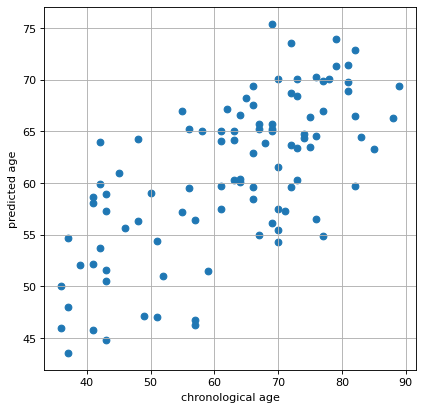

[[1.         0.67993307]
 [0.67993307 1.        ]]
r^2 val data:  0.4243412689264594


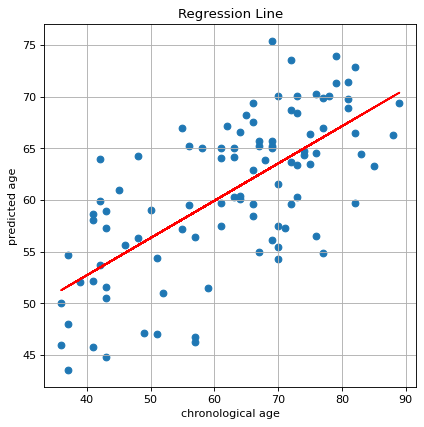

切片: 38.32123111002268
傾き: 0.3603227618380508
Kfold: 3 ::: epoch: 100, loss: 0.019704396478258647, val loss: 0.4974188655614853
Kfold: 3 ::: epoch: 200, loss: 0.0108157077875848, val loss: 0.45234545320272446
Kfold: 3 ::: epoch: 300, loss: 0.010128182573960377, val loss: 0.45201661065220833
Kfold: 3 ::: epoch: 400, loss: 0.009154933433120068, val loss: 0.43006567656993866
Kfold: 3 ::: epoch: 500, loss: 0.008110445959923359, val loss: 0.42675745859742165
Kfold: 3 ::: epoch: 600, loss: 0.006986728941018765, val loss: 0.4591904915869236
Kfold: 3 ::: epoch: 700, loss: 0.008284090588299127, val loss: 0.5025659799575806
save_epochs:369


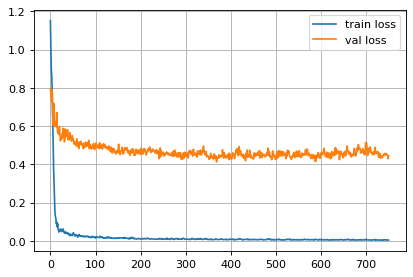

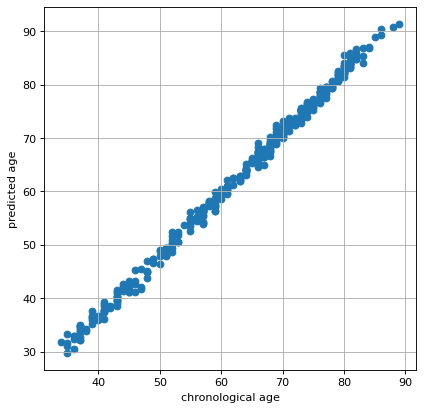

[[1.         0.99823943]
 [0.99823943 1.        ]]
r^2 train data:  0.9740608672876955


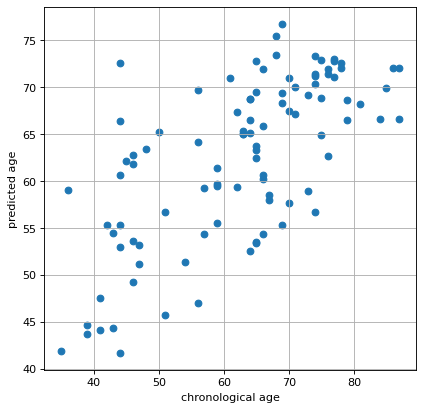

[[1.         0.68030516]
 [0.68030516 1.        ]]
r^2 val data:  0.4625112179156685


切片: 34.301227961762464
傾き: 0.4510182662806476
Kfold: 4 ::: epoch: 100, loss: 0.020266088728721324, val loss: 1.1611786633729935
Kfold: 4 ::: epoch: 200, loss: 0.01612036797003104, val loss: 1.12611623108387
Kfold: 4 ::: epoch: 300, loss: 0.010917815523078809, val loss: 1.1632327735424042
Kfold: 4 ::: epoch: 400, loss: 0.010644200616157971, val loss: 1.0861603021621704
Kfold: 4 ::: epoch: 500, loss: 0.007841670885682106, val loss: 1.1004872843623161
Kfold: 4 ::: epoch: 600, loss: 0.00668181090329129, val loss: 1.1113979518413544
Kfold: 4 ::: epoch: 700, loss: 0.006212838029918762, val loss: 1.1295204162597656
save_epochs:744


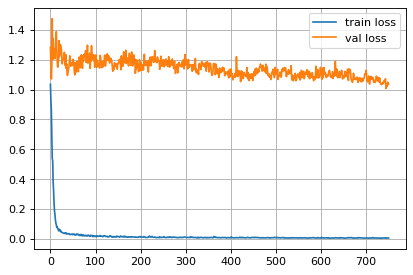

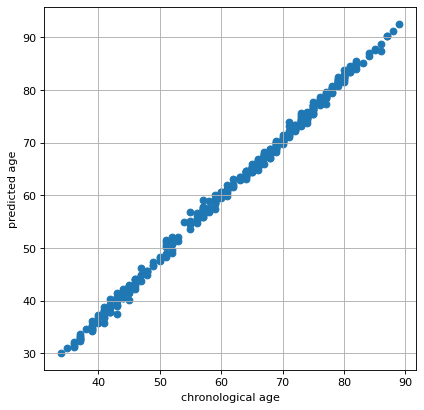

[[1.         0.99876878]
 [0.99876878 1.        ]]
r^2 train data:  0.9774479100712069


[[1.         0.58663655]
 [0.58663655 1.        ]]
r^2 val data:  0.341434508174542


切片: 41.73110501072529
傾き: 0.32219529796779833
Kfold: 5 ::: epoch: 100, loss: 0.017049203985012494, val loss: 0.8105395585298538
Kfold: 5 ::: epoch: 200, loss: 0.013308816875975866, val loss: 0.7587994933128357
Kfold: 5 ::: epoch: 300, loss: 0.008176647287865099, val loss: 0.7738668397068977
Kfold: 5 ::: epoch: 400, loss: 0.008662639973828426, val loss: 0.7397050559520721
Kfold: 5 ::: epoch: 500, loss: 0.006151144464428608, val loss: 0.7565245851874352
Kfold: 5 ::: epoch: 600, loss: 0.0074376061272162656, val loss: 0.7380912899971008
Kfold: 5 ::: epoch: 700, loss: 0.003525498824623915, val loss: 0.740868553519249
save_epochs:529


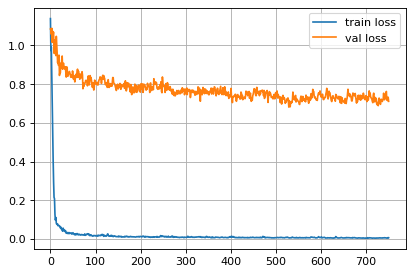

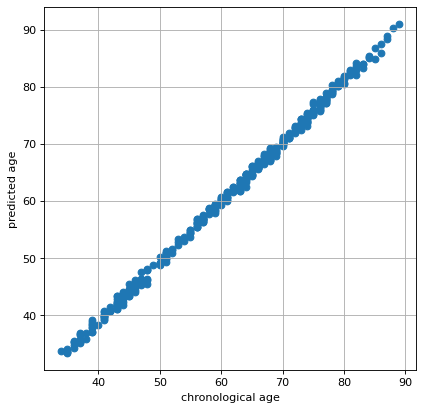

[[1.         0.99908498]
 [0.99908498 1.        ]]
r^2 train data:  0.9953585144272832


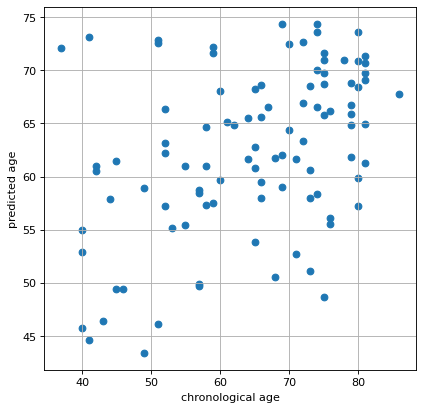

[[1.        0.4240428]
 [0.4240428 1.       ]]
r^2 val data:  0.11525315505040878


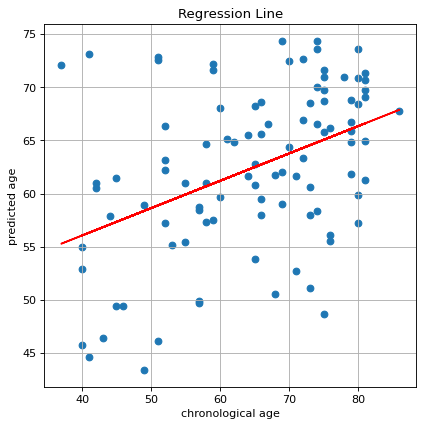

切片: 45.774045058405065
傾き: 0.25698126397654486
Nested Kfold ::: 5
Kfold: 1 ::: epoch: 100, loss: 0.015303289875961266, val loss: 0.6170289367437363
Kfold: 1 ::: epoch: 200, loss: 0.01113123450284967, val loss: 0.6086976081132889
Kfold: 1 ::: epoch: 300, loss: 0.008325068924862605, val loss: 0.5921262577176094
Kfold: 1 ::: epoch: 400, loss: 0.010595191270112991, val loss: 0.5607722997665405
Kfold: 1 ::: epoch: 500, loss: 0.007491465443028853, val loss: 0.5257934108376503
Kfold: 1 ::: epoch: 600, loss: 0.006857720651448919, val loss: 0.5347468554973602
Kfold: 1 ::: epoch: 700, loss: 0.005512652703775809, val loss: 0.5436333492398262
save_epochs:745


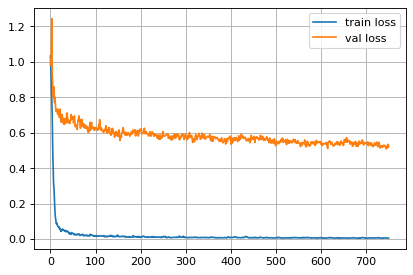

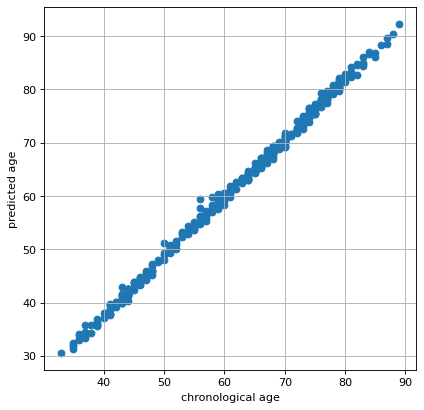

[[1.        0.9988373]
 [0.9988373 1.       ]]
r^2 train data:  0.9863633869882289


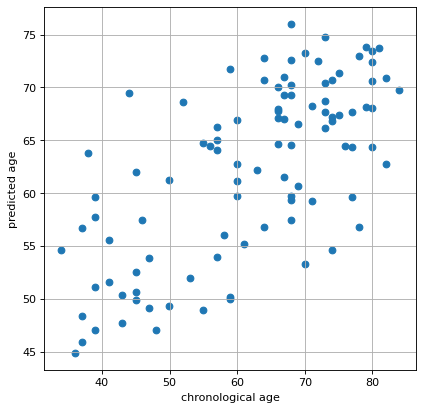

[[1.         0.68202729]
 [0.68202729 1.        ]]
r^2 val data:  0.4580002510764256


切片: 36.92767482524894
傾き: 0.4094099827315727
Kfold: 2 ::: epoch: 100, loss: 0.019226577920982472, val loss: 0.540005637332797
Kfold: 2 ::: epoch: 200, loss: 0.013346573803573847, val loss: 0.5342687293887138
Kfold: 2 ::: epoch: 300, loss: 0.00924125388981058, val loss: 0.551826111972332
Kfold: 2 ::: epoch: 400, loss: 0.009796076812423192, val loss: 0.5508681163191795
Kfold: 2 ::: epoch: 500, loss: 0.007423056397013939, val loss: 0.5734269842505455
Kfold: 2 ::: epoch: 600, loss: 0.006640526913822844, val loss: 0.5612829588353634
Kfold: 2 ::: epoch: 700, loss: 0.006820715999660583, val loss: 0.57020653039217
save_epochs:391


[[1.         0.99841307]
 [0.99841307 1.        ]]
r^2 train data:  0.9638110891641232


[[1.         0.63981907]
 [0.63981907 1.        ]]
r^2 val data:  0.3964262890746989


切片: 40.82740097279668
傾き: 0.34022211488078974
Kfold: 3 ::: epoch: 100, loss: 0.021059628576040268, val loss: 0.4584970958530903
Kfold: 3 ::: epoch: 200, loss: 0.012632984202355146, val loss: 0.4418100416660309
Kfold: 3 ::: epoch: 300, loss: 0.007727773466075842, val loss: 0.4289706237614155
Kfold: 3 ::: epoch: 400, loss: 0.008794715556387719, val loss: 0.38148305751383305
Kfold: 3 ::: epoch: 500, loss: 0.006134490840710127, val loss: 0.39023833721876144
Kfold: 3 ::: epoch: 600, loss: 0.005816532639213479, val loss: 0.3991191666573286
Kfold: 3 ::: epoch: 700, loss: 0.004622846931362381, val loss: 0.3988166991621256
save_epochs:442


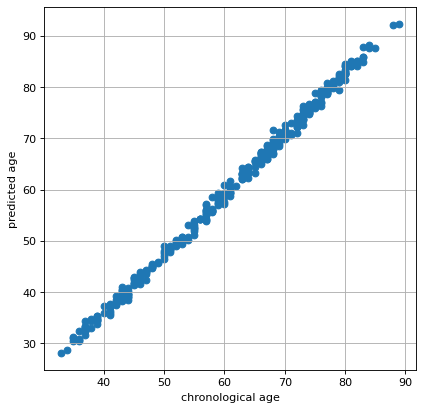

[[1.         0.99861282]
 [0.99861282 1.        ]]
r^2 train data:  0.9650452890743626


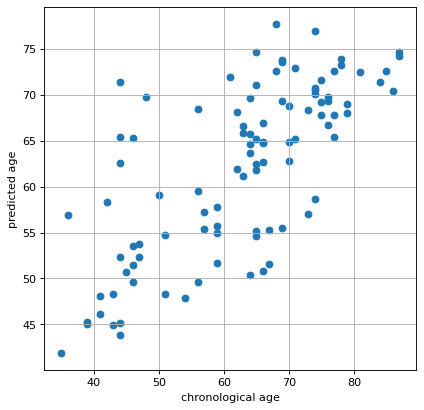

[[1.         0.71982939]
 [0.71982939 1.        ]]
r^2 val data:  0.5171345253854653


切片: 30.419203967723718
傾き: 0.506953433703241
Kfold: 4 ::: epoch: 100, loss: 0.017993328734659232, val loss: 0.6953657269477844
Kfold: 4 ::: epoch: 200, loss: 0.011180806045348827, val loss: 0.5806040391325951
Kfold: 4 ::: epoch: 300, loss: 0.010502184311357828, val loss: 0.5368072018027306
Kfold: 4 ::: epoch: 400, loss: 0.007895104121416807, val loss: 0.5368193313479424
Kfold: 4 ::: epoch: 500, loss: 0.007729058440488119, val loss: 0.4988316521048546
Kfold: 4 ::: epoch: 600, loss: 0.004469340201467276, val loss: 0.49677619338035583
Kfold: 4 ::: epoch: 700, loss: 0.008045581491807332, val loss: 0.5020515099167824
save_epochs:665


[[1.         0.99886586]
 [0.99886586 1.        ]]
r^2 train data:  0.9769041453315787


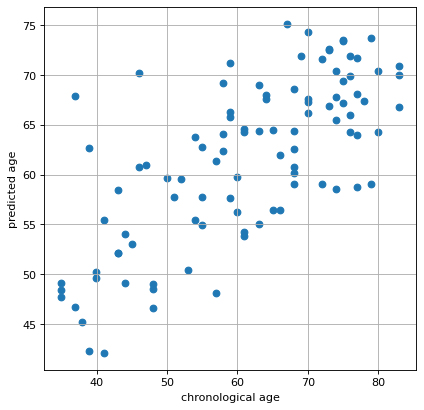

[[1.         0.71825473]
 [0.71825473 1.        ]]
r^2 val data:  0.5019464127003936


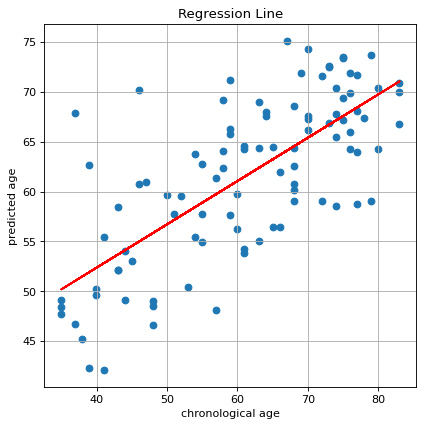

切片: 35.001911262507164
傾き: 0.4343295893402547
Kfold: 5 ::: epoch: 100, loss: 0.016416003712667868, val loss: 0.7502748072147369
Kfold: 5 ::: epoch: 200, loss: 0.010440911470840756, val loss: 0.7031183987855911
Kfold: 5 ::: epoch: 300, loss: 0.008679230948193716, val loss: 0.7540276050567627
Kfold: 5 ::: epoch: 400, loss: 0.008104183782751743, val loss: 0.7143085300922394
Kfold: 5 ::: epoch: 500, loss: 0.005842169119904821, val loss: 0.7197964787483215
Kfold: 5 ::: epoch: 600, loss: 0.006375426551900231, val loss: 0.7160960584878922
Kfold: 5 ::: epoch: 700, loss: 0.004840068116139334, val loss: 0.7330548763275146
save_epochs:655


[[1.         0.99830876]
 [0.99830876 1.        ]]
r^2 train data:  0.9880182787311252


[[1.         0.61492583]
 [0.61492583 1.        ]]
r^2 val data:  0.37434683617763287


切片: 35.992700678592584
傾き: 0.4154263723285948
CPU times: user 1h 15min 18s, sys: 7min 54s, total: 1h 23min 13s
Wall time: 1h 23min 12s


In [17]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_all_2  = []
test_label_all_2 = []

test_idx_all_2   = []
train_idx_all_2  = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_aal)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_label = train_model(data_aal,
                                       data_label,
                                       train_idx  = train_idx,
                                       test_idx   = test_idx,
                                       epochs     = 750,
                                       d_model    = 128,
                                       n_splits   = n_splits,
                                       hidden_dim = 128,
                                       nhead      = 32,
                                       hidden_dim_transformer = 2,
                                       pos_drop    = 0.1,
                                       trans_drop = 0.1,
                                       fc_drop = 0.1
                                      )
    test_pred_all_2.append(test_pred)
    test_label_all_2.append(test_label)
    test_idx_all_2.append(test_idx)
    train_idx_all_2.append(train_idx)

LinearRegression()

<Figure size 480x480 with 0 Axes>

Text(0.5, 1.0, 'Regression Line')

Text(0.5, 0, 'chronological age')

Text(0, 0.5, 'predicted age')

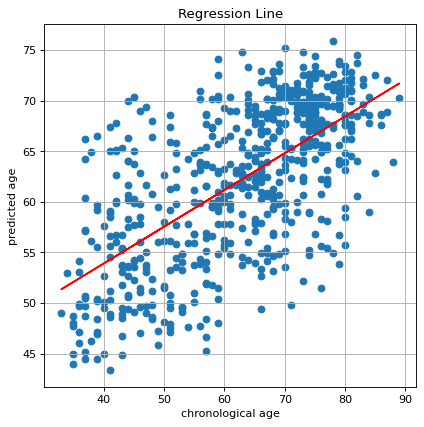

相関係数:  0.6454811318247734
r^2 test data:  0.40913603961535516
切片:  39.36751286480775
傾き:  0.36334863617378216


In [18]:
for i in range(n_splits):
    if not i:
        test_label = test_label_all_2[i]
    else:
        test_label = np.concatenate([test_label,test_label_all_2[i]])
        
for i in range(n_splits):
    if not i:
        test_pred = test_pred_all_2[i].mean(axis=0)
    else:
        test_pred = np.concatenate([test_pred,test_pred_all_2[i].mean(axis=0)])

lr = LinearRegression()
lr.fit(test_label*age_std+age_mean,test_pred[:,0]*age_std+age_mean)

plt.figure(figsize=(6, 6), dpi=80)
plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[:,0]*age_std+age_mean)#散布図をプロット
plt.plot(test_label[:,0]*age_std+age_mean,
         lr.predict(test_label*age_std+age_mean), color = 'red')#回帰直線をプロット

plt.title('Regression Line')   # 図のタイトル
plt.xlabel('chronological age')# x軸のラベル
plt.ylabel('predicted age')    # y軸のラベル
plt.grid()                     # グリッド線を表示
plt.show()                     # 図の表示

print('相関係数: ', np.corrcoef(test_label[:,0],test_pred[:,0])[0,1])
print('r^2 test data: ', r2_score(test_label[:,0],test_pred[:,0]))
print('切片: ', lr.intercept_)
print('傾き: ', lr.coef_[0])

In [19]:
diff = test_pred[:,0]*age_std + age_mean - lr.predict(test_label*age_std + age_mean)

plt.figure(figsize=(6, 6), dpi=80)
plt.scatter(diff,data_label[:,2])
plt.title('Regression Line')   # 図のタイトル
plt.xlabel('diff')    # x軸のラベル
plt.ylabel('apathy')  # y軸のラベル
plt.grid()                     # グリッド線を表示
plt.show()                     # 図の表示

corr,p = pearsonr(diff,data_label[:,2])
print("相関係数:", corr)
print("p値:", p)

<Figure size 480x480 with 0 Axes>

Text(0.5, 1.0, 'Regression Line')

Text(0.5, 0, 'diff')

Text(0, 0.5, 'apathy')

相関係数: 0.052048191263147386
p値: 0.19739773217672243


## Data定義(dynamic FC)

In [14]:
%%time
df_dynamic_aal = pd.read_csv('../02_data_analysis/dynamic_FC/dynamic_aal.csv')
df_dynamic_ho = pd.read_csv('../02_data_analysis/dynamic_FC/dynamic_ho.csv')

data_dynamic_aal = make_data(df_dynamic_aal)
data_dynamic_ho = make_data(df_dynamic_ho)

data_dynamic_aal.shape
data_dynamic_ho.shape

CPU times: user 5min 57s, sys: 9.87 s, total: 6min 7s
Wall time: 6min 8s


(615, 123, 5995)

### 学習 dynamic FC 1

Nested Kfold ::: 1
Kfold: 1 ::: epoch: 100, loss: 0.019100113055453852, val loss: 0.4858563784509897
Kfold: 1 ::: epoch: 200, loss: 0.011814686004072428, val loss: 0.4411537009291351
Kfold: 1 ::: epoch: 300, loss: 0.00796483621860926, val loss: 0.4407604783773422
Kfold: 1 ::: epoch: 400, loss: 0.007339666382624553, val loss: 0.43956645485013723
Kfold: 1 ::: epoch: 500, loss: 0.008512998143067727, val loss: 0.4707405548542738
Kfold: 1 ::: epoch: 600, loss: 0.010755958787810344, val loss: 0.5938113629817963
Kfold: 1 ::: epoch: 700, loss: 0.006785835031993114, val loss: 0.5804933365434408
save_epochs:250


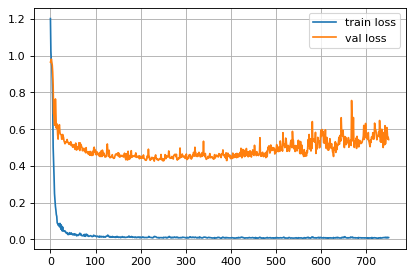

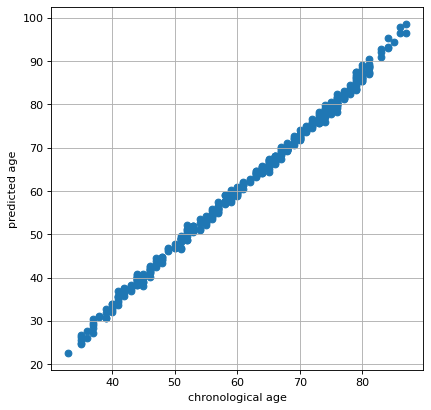

[[1.         0.99838318]
 [0.99838318 1.        ]]
r^2 train data:  0.8890442519176167


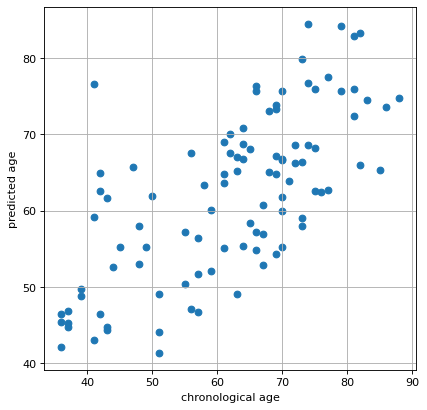

[[1.         0.69912362]
 [0.69912362 1.        ]]
r^2 val data:  0.4809022089303292


切片: 28.00261597244039
傾き: 0.5502428409856637
Kfold: 2 ::: epoch: 100, loss: 0.01768850040836976, val loss: 1.3337036073207855
Kfold: 2 ::: epoch: 200, loss: 0.012795228475274948, val loss: 1.1453390568494797
Kfold: 2 ::: epoch: 300, loss: 0.011303352012943763, val loss: 1.0910274684429169
Kfold: 2 ::: epoch: 400, loss: 0.015372237907006191, val loss: 1.0935754925012589
Kfold: 2 ::: epoch: 500, loss: 0.010019265634652514, val loss: 0.9484642297029495
Kfold: 2 ::: epoch: 600, loss: 0.009959206737291355, val loss: 0.8675808608531952
Kfold: 2 ::: epoch: 700, loss: 0.011464814368921977, val loss: 0.7307239323854446
save_epochs:710


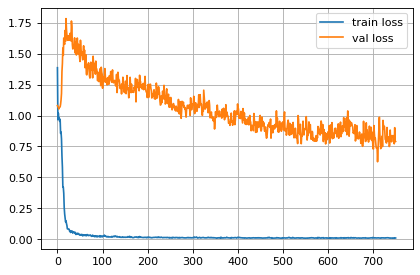

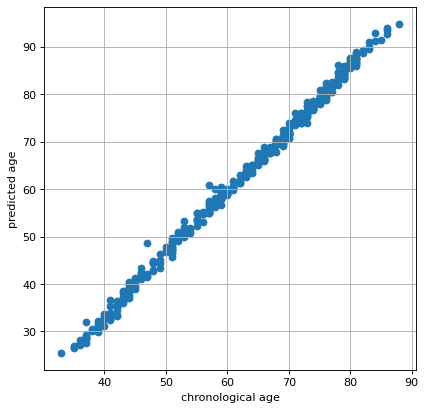

[[1.         0.99820292]
 [0.99820292 1.        ]]
r^2 train data:  0.8973940539332088


[[1.         0.55734699]
 [0.55734699 1.        ]]
r^2 val data:  0.30815976863938344


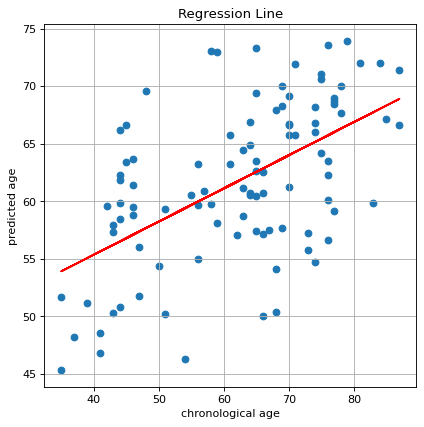

切片: 43.83189009200329
傾き: 0.28805231731076014
Kfold: 3 ::: epoch: 100, loss: 0.017835049531780757, val loss: 0.8943460583686829
Kfold: 3 ::: epoch: 200, loss: 0.00869631183405335, val loss: 0.8479012846946716
Kfold: 3 ::: epoch: 300, loss: 0.011235944389437254, val loss: 0.9233188480138779
Kfold: 3 ::: epoch: 400, loss: 0.01120387132351215, val loss: 0.7616517245769501
Kfold: 3 ::: epoch: 500, loss: 0.008162147920721998, val loss: 0.7809723317623138
Kfold: 3 ::: epoch: 600, loss: 0.008908245282677503, val loss: 0.7413712441921234
Kfold: 3 ::: epoch: 700, loss: 0.008170790433023985, val loss: 0.7319376915693283
save_epochs:667


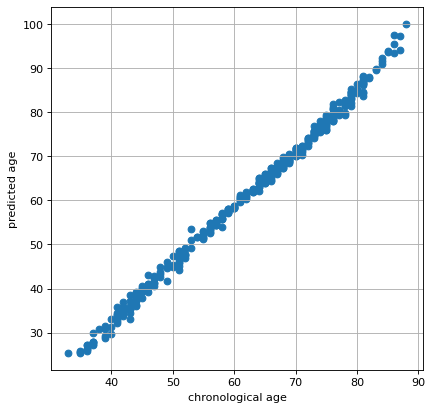

[[1.         0.99794088]
 [0.99794088 1.        ]]
r^2 train data:  0.8947330857066936


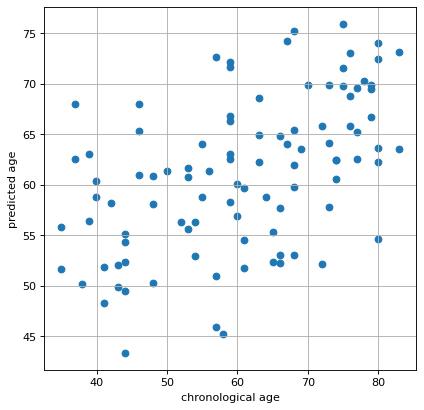

[[1.         0.51454314]
 [0.51454314 1.        ]]
r^2 val data:  0.2618650063348018


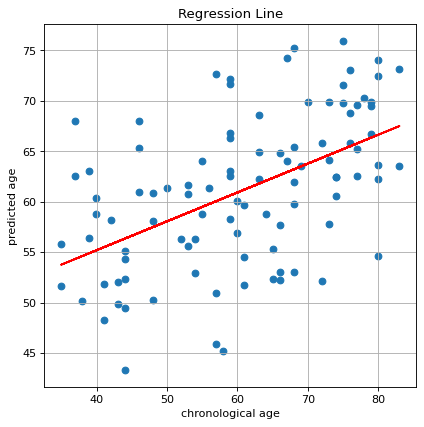

切片: 43.7519948310471
傾き: 0.28603822536768353
Kfold: 4 ::: epoch: 100, loss: 0.01717295705412443, val loss: 0.7739557176828384
Kfold: 4 ::: epoch: 200, loss: 0.009948538687939826, val loss: 0.657346099615097
Kfold: 4 ::: epoch: 300, loss: 0.010288790369836183, val loss: 0.6495357155799866
Kfold: 4 ::: epoch: 400, loss: 0.011315167451707216, val loss: 0.6963537782430649
Kfold: 4 ::: epoch: 500, loss: 0.005797162222174497, val loss: 0.6848901957273483
Kfold: 4 ::: epoch: 600, loss: 0.006947472440795257, val loss: 0.7852447032928467
Kfold: 4 ::: epoch: 700, loss: 0.008033582152655492, val loss: 0.927939161658287
save_epochs:270


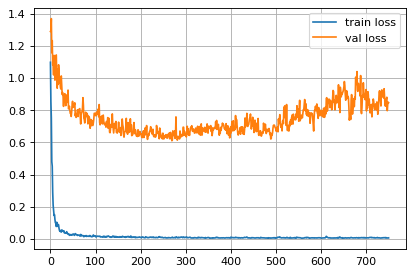

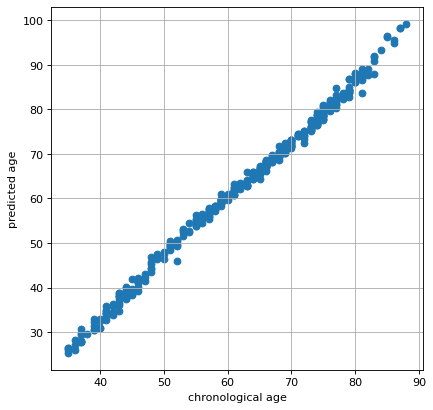

[[1.        0.9978123]
 [0.9978123 1.       ]]
r^2 train data:  0.8883019754525202


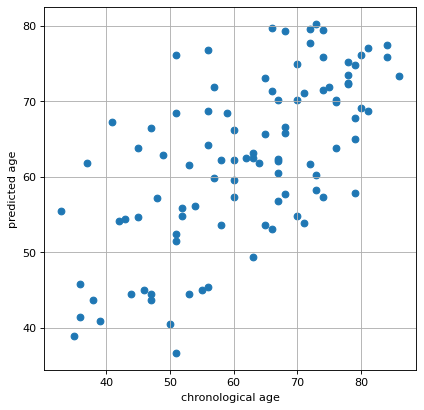

[[1.        0.6533945]
 [0.6533945 1.       ]]
r^2 val data:  0.3962547601826616


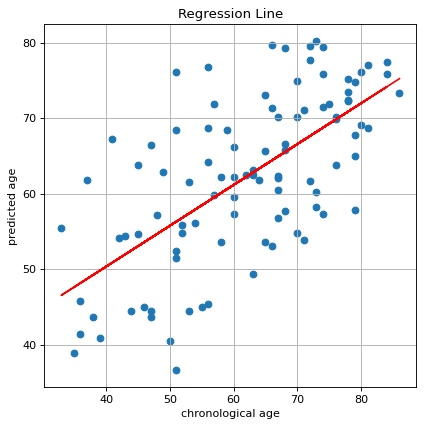

切片: 28.68598927116789
傾き: 0.5409124912178863
Kfold: 5 ::: epoch: 100, loss: 0.014433772374804203, val loss: 0.5978175704367459
Kfold: 5 ::: epoch: 200, loss: 0.016879521095408842, val loss: 0.61432697577402
Kfold: 5 ::: epoch: 300, loss: 0.009037800025768004, val loss: 0.5488499440252781
Kfold: 5 ::: epoch: 400, loss: 0.007467628635752659, val loss: 0.5415658950805664
Kfold: 5 ::: epoch: 500, loss: 0.008838878049013706, val loss: 0.5212296172976494
Kfold: 5 ::: epoch: 600, loss: 0.011343272170051932, val loss: 0.5443222094327211
Kfold: 5 ::: epoch: 700, loss: 0.008083712166318527, val loss: 0.5097424387931824
save_epochs:721


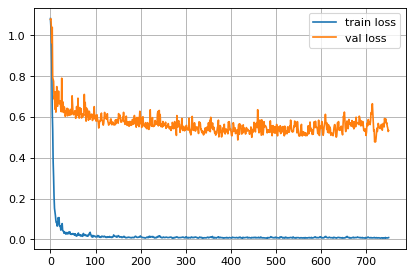

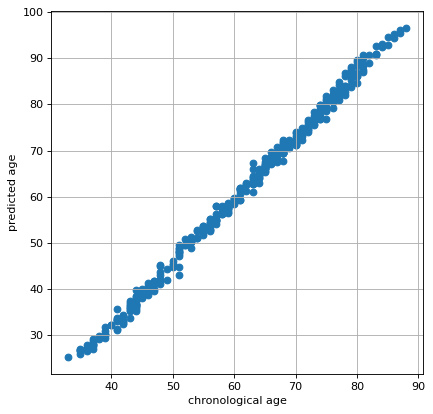

[[1.         0.99811552]
 [0.99811552 1.        ]]
r^2 train data:  0.8584106152736389


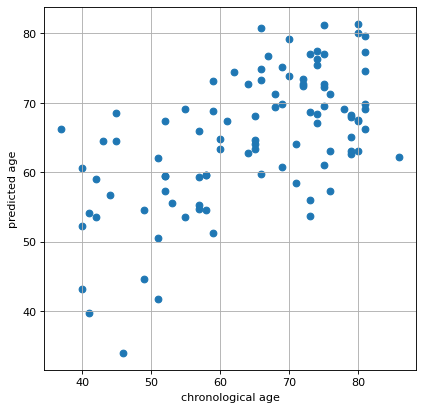

[[1.         0.59479325]
 [0.59479325 1.        ]]
r^2 val data:  0.32926917228967223


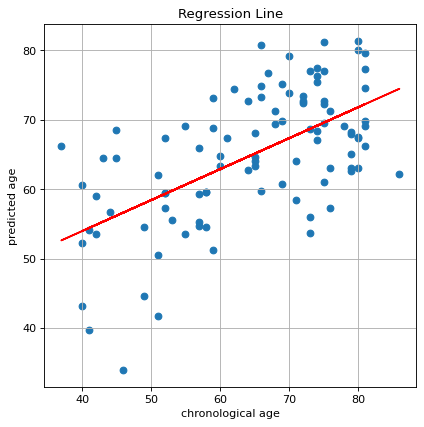

切片: 36.15009689056947
傾き: 0.44570601341214033
Nested Kfold ::: 2
Kfold: 1 ::: epoch: 100, loss: 0.020215409091458872, val loss: 0.5405563935637474
Kfold: 1 ::: epoch: 200, loss: 0.010893389869194765, val loss: 0.5713796317577362
Kfold: 1 ::: epoch: 300, loss: 0.008087751921266317, val loss: 0.5975024551153183
Kfold: 1 ::: epoch: 400, loss: 0.007741012664225239, val loss: 0.608814463019371
Kfold: 1 ::: epoch: 500, loss: 0.011185110009347018, val loss: 0.7037936598062515
Kfold: 1 ::: epoch: 600, loss: 0.0077346048246209435, val loss: 0.618704192340374
Kfold: 1 ::: epoch: 700, loss: 0.007019024843779894, val loss: 0.7477418631315231
save_epochs:739


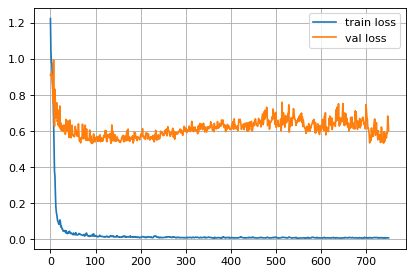

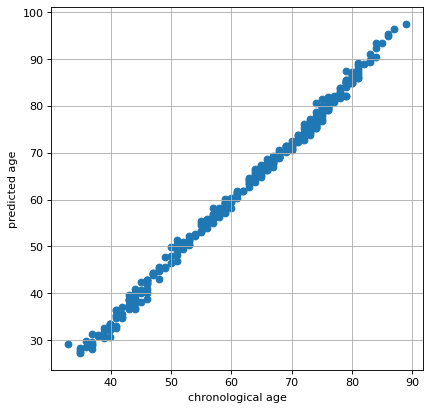

[[1.        0.9977887]
 [0.9977887 1.       ]]
r^2 train data:  0.9106066461063418


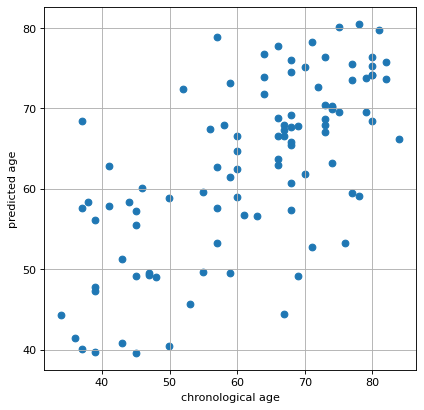

[[1.         0.67792462]
 [0.67792462 1.        ]]
r^2 val data:  0.44197344300009533


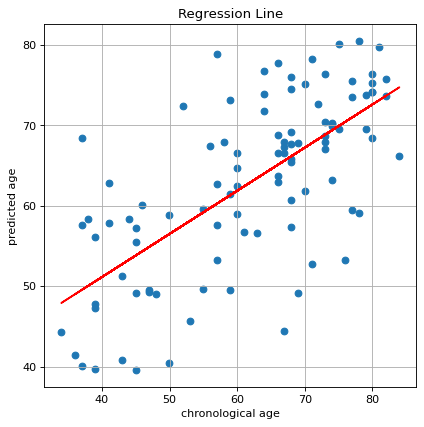

切片: 29.67240376114256
傾き: 0.5366568475533294
Kfold: 2 ::: epoch: 100, loss: 0.01734527379560929, val loss: 0.8203386068344116
Kfold: 2 ::: epoch: 200, loss: 0.012529392081957597, val loss: 0.6605626046657562
Kfold: 2 ::: epoch: 300, loss: 0.009563644774831258, val loss: 0.5809521377086639
Kfold: 2 ::: epoch: 400, loss: 0.01494145321731384, val loss: 0.5220788270235062
Kfold: 2 ::: epoch: 500, loss: 0.009219094466131467, val loss: 0.4647351037710905
Kfold: 2 ::: epoch: 600, loss: 0.008115293099903144, val loss: 0.5056918188929558
Kfold: 2 ::: epoch: 700, loss: 0.009957438728843745, val loss: 0.5587742701172829
save_epochs:508


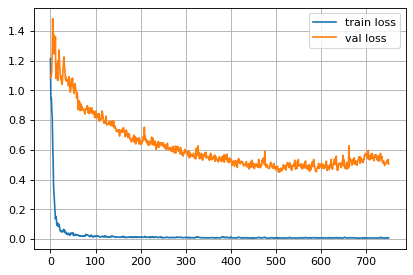

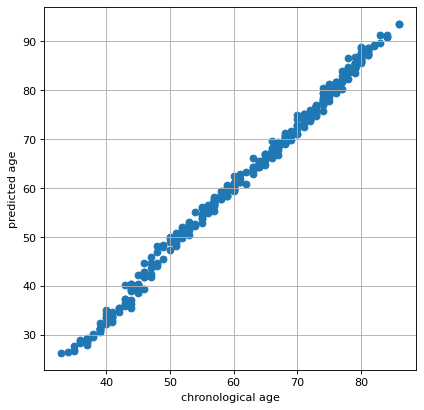

[[1.         0.99770072]
 [0.99770072 1.        ]]
r^2 train data:  0.895413860675515


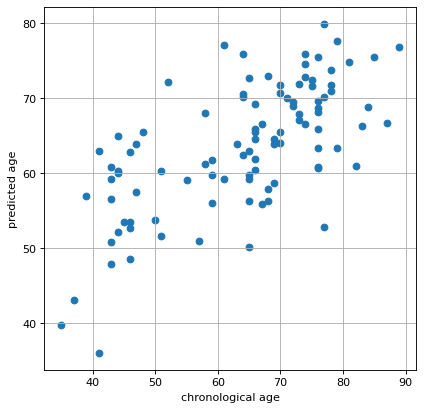

[[1.         0.66282126]
 [0.66282126 1.        ]]
r^2 val data:  0.4384133110084891


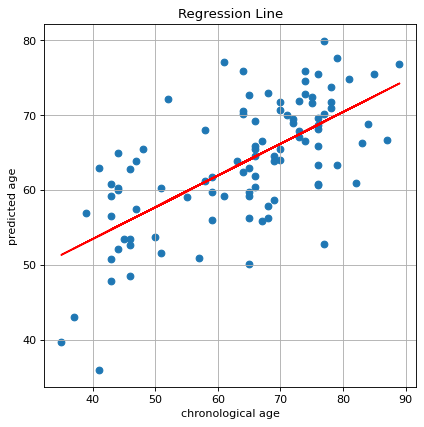

切片: 36.53951350439417
傾き: 0.4235402582705106
Kfold: 3 ::: epoch: 100, loss: 0.015816689307729784, val loss: 0.8496130928397179
Kfold: 3 ::: epoch: 200, loss: 0.008498392963352112, val loss: 0.8274731487035751
Kfold: 3 ::: epoch: 300, loss: 0.010239245262570106, val loss: 0.7967723906040192
Kfold: 3 ::: epoch: 400, loss: 0.009808319764068494, val loss: 0.7035034894943237
Kfold: 3 ::: epoch: 500, loss: 0.011768347977732237, val loss: 0.7117742598056793
Kfold: 3 ::: epoch: 600, loss: 0.008285685585668454, val loss: 0.7688388824462891
Kfold: 3 ::: epoch: 700, loss: 0.0074096695305063175, val loss: 0.7199804782867432
save_epochs:479


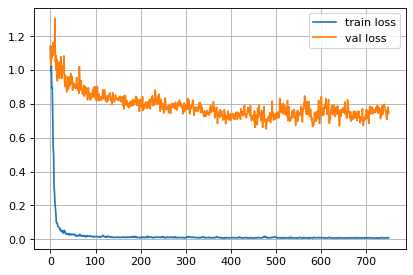

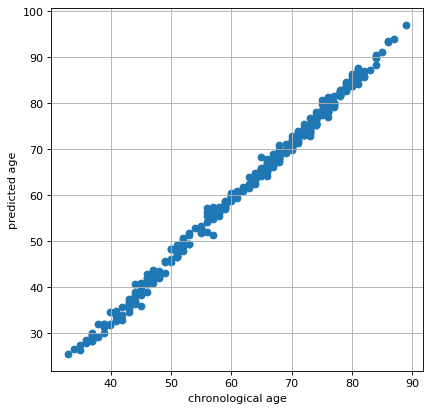

[[1.         0.99817734]
 [0.99817734 1.        ]]
r^2 train data:  0.9133341900043828


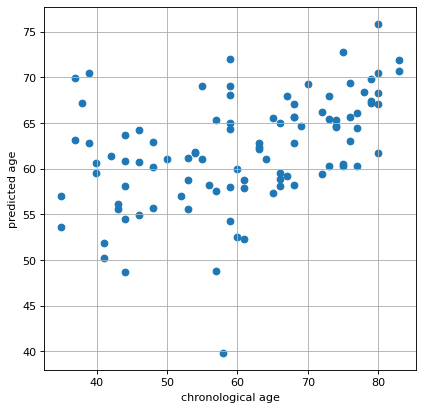

[[1.        0.4535534]
 [0.4535534 1.       ]]
r^2 val data:  0.19444890085866662


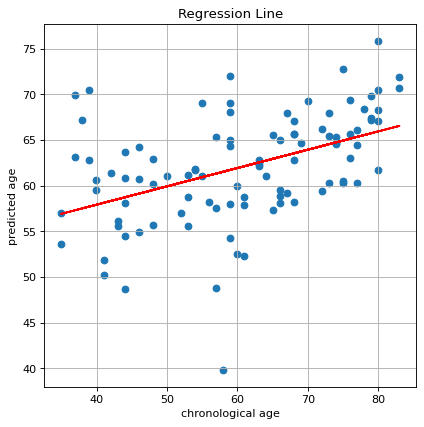

切片: 49.901680692036024
傾き: 0.2004590829535769
Kfold: 4 ::: epoch: 100, loss: 0.019674682918076333, val loss: 1.4142441898584366
Kfold: 4 ::: epoch: 200, loss: 0.01337912786178864, val loss: 1.2014838010072708
Kfold: 4 ::: epoch: 300, loss: 0.010937358897465926, val loss: 1.1147575825452805
Kfold: 4 ::: epoch: 400, loss: 0.011289983092305752, val loss: 1.0907790660858154
Kfold: 4 ::: epoch: 500, loss: 0.009411299225086203, val loss: 1.0501656383275986
Kfold: 4 ::: epoch: 600, loss: 0.009887777304706665, val loss: 1.00824373960495
Kfold: 4 ::: epoch: 700, loss: 0.008600616791787056, val loss: 0.9243334084749222
save_epochs:716


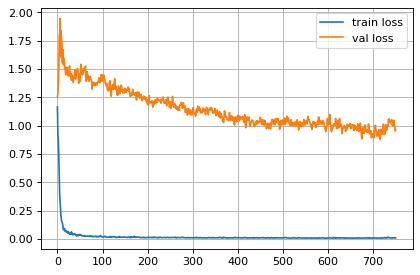

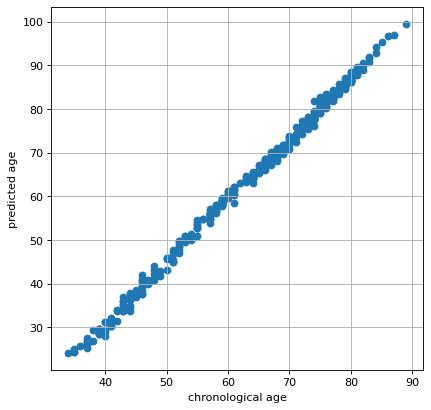

[[1.        0.9985055]
 [0.9985055 1.       ]]
r^2 train data:  0.8286874644665152


[[1.         0.46010922]
 [0.46010922 1.        ]]
r^2 val data:  0.20364403471599402


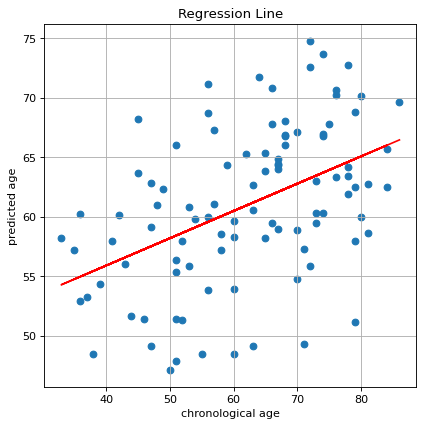

切片: 46.72448349831298
傾き: 0.22950152509602056
Kfold: 5 ::: epoch: 100, loss: 0.012477052290565692, val loss: 0.7789211869239807
Kfold: 5 ::: epoch: 200, loss: 0.009658670805108089, val loss: 0.7646309435367584
Kfold: 5 ::: epoch: 300, loss: 0.00739861811654499, val loss: 0.6888048946857452
Kfold: 5 ::: epoch: 400, loss: 0.006663932429196743, val loss: 0.7636900693178177
Kfold: 5 ::: epoch: 500, loss: 0.010607885089344703, val loss: 0.7419237494468689
Kfold: 5 ::: epoch: 600, loss: 0.010569935700354667, val loss: 1.034690260887146
Kfold: 5 ::: epoch: 700, loss: 0.009778957348316908, val loss: 0.8972652554512024
save_epochs:508


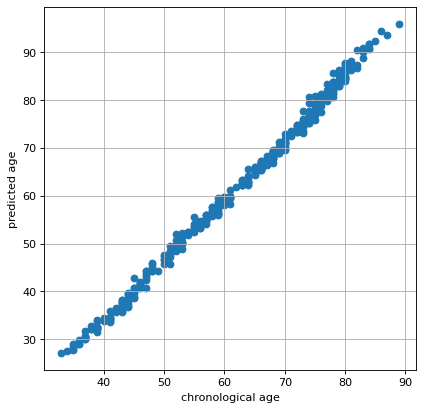

[[1.         0.99784761]
 [0.99784761 1.        ]]
r^2 train data:  0.9169952585112926


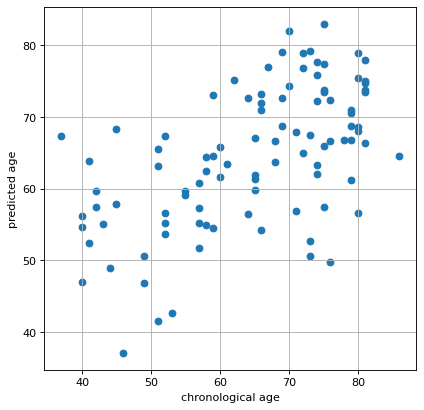

[[1.         0.57073416]
 [0.57073416 1.        ]]
r^2 val data:  0.2898821637662494


切片: 36.40003328362436
傾き: 0.4332977053394012
Nested Kfold ::: 3
Kfold: 1 ::: epoch: 100, loss: 0.02424546266691043, val loss: 0.7222906053066254
Kfold: 1 ::: epoch: 200, loss: 0.015325889671937777, val loss: 0.6656547039747238
Kfold: 1 ::: epoch: 300, loss: 0.01356342051608058, val loss: 0.6385466307401657
Kfold: 1 ::: epoch: 400, loss: 0.009875163400115875, val loss: 0.673354372382164
Kfold: 1 ::: epoch: 500, loss: 0.010785986382800799, val loss: 0.7037567049264908
Kfold: 1 ::: epoch: 600, loss: 0.007699630294854824, val loss: 0.7068746089935303
Kfold: 1 ::: epoch: 700, loss: 0.007270079625483889, val loss: 0.6695698499679565
save_epochs:474


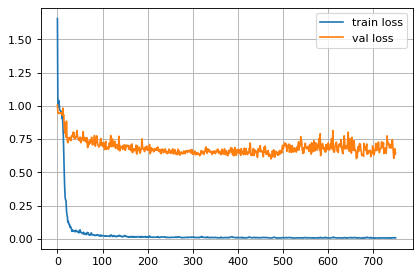

[[1.         0.99827323]
 [0.99827323 1.        ]]
r^2 train data:  0.9357087627570481


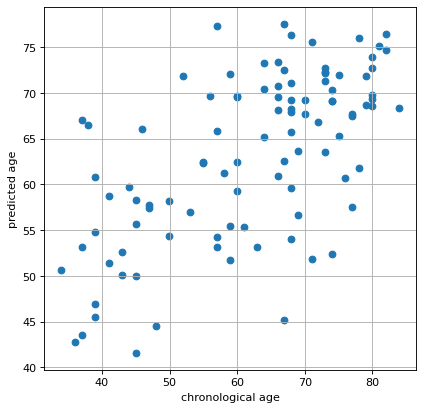

[[1.         0.62585275]
 [0.62585275 1.        ]]
r^2 val data:  0.38288888166139623


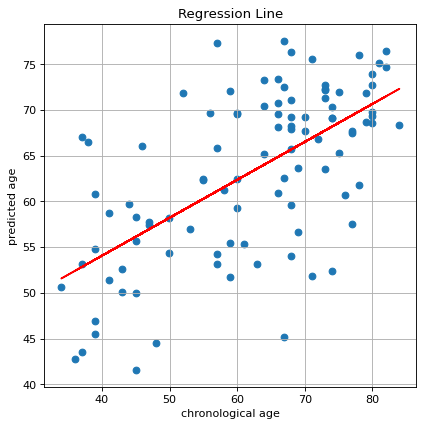

切片: 37.48118784639858
傾き: 0.41469579369145987
Kfold: 2 ::: epoch: 100, loss: 0.01517750727585875, val loss: 0.6794175952672958
Kfold: 2 ::: epoch: 200, loss: 0.010965084155591635, val loss: 0.6118608377873898
Kfold: 2 ::: epoch: 300, loss: 0.009445883906804599, val loss: 0.5934787876904011
Kfold: 2 ::: epoch: 400, loss: 0.01076874932130942, val loss: 0.5663851741701365
Kfold: 2 ::: epoch: 500, loss: 0.008648071044053022, val loss: 0.5868628658354282
Kfold: 2 ::: epoch: 600, loss: 0.008669144527700085, val loss: 0.5765811493620276
Kfold: 2 ::: epoch: 700, loss: 0.009655881171616225, val loss: 0.6568906828761101
save_epochs:373


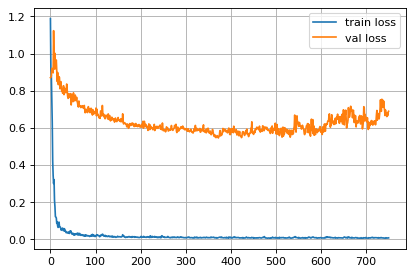

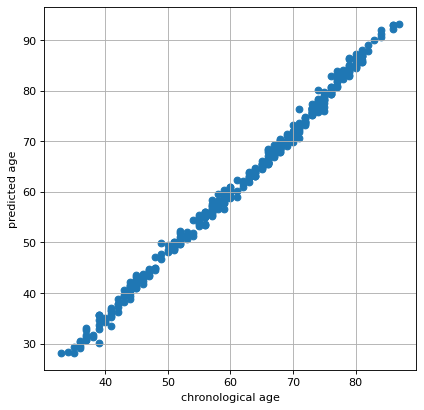

[[1.         0.99770997]
 [0.99770997 1.        ]]
r^2 train data:  0.9337497575325235


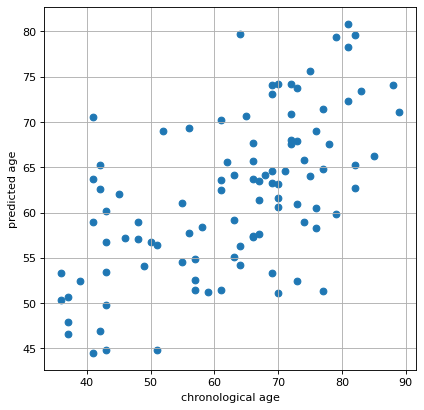

[[1.         0.60263229]
 [0.60263229 1.        ]]
r^2 val data:  0.3601991331674175


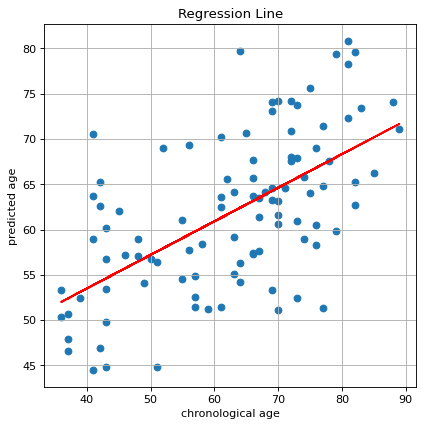

切片: 38.680262213655865
傾き: 0.37057349129099976
Kfold: 3 ::: epoch: 100, loss: 0.018936863383994654, val loss: 1.1063563525676727
Kfold: 3 ::: epoch: 200, loss: 0.012797087144393187, val loss: 0.9793599992990494
Kfold: 3 ::: epoch: 300, loss: 0.01227309311238619, val loss: 1.041210263967514
Kfold: 3 ::: epoch: 400, loss: 0.010860138859313268, val loss: 0.9615795463323593
Kfold: 3 ::: epoch: 500, loss: 0.009291712302141465, val loss: 0.9492431581020355
Kfold: 3 ::: epoch: 600, loss: 0.008740524474817973, val loss: 0.969564214348793
Kfold: 3 ::: epoch: 700, loss: 0.007922292615358647, val loss: 0.8036014288663864
save_epochs:700


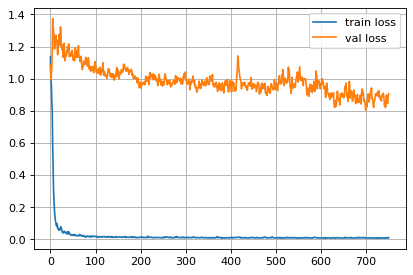

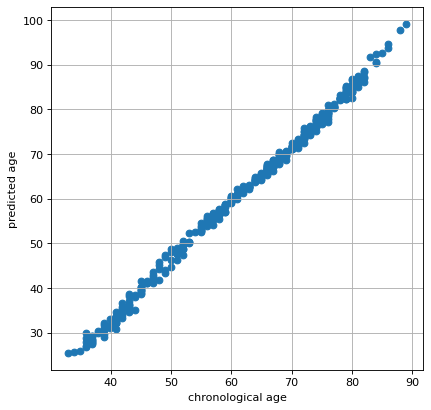

[[1.         0.99828277]
 [0.99828277 1.        ]]
r^2 train data:  0.904292118479504


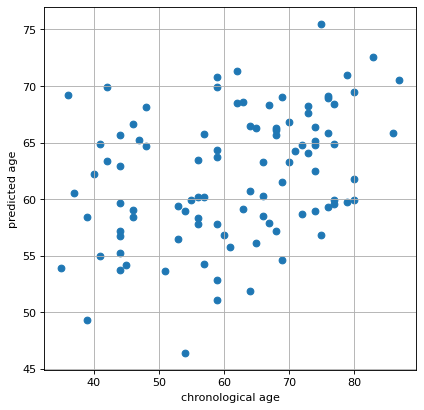

[[1.         0.35842152]
 [0.35842152 1.        ]]
r^2 val data:  0.12041008638803263


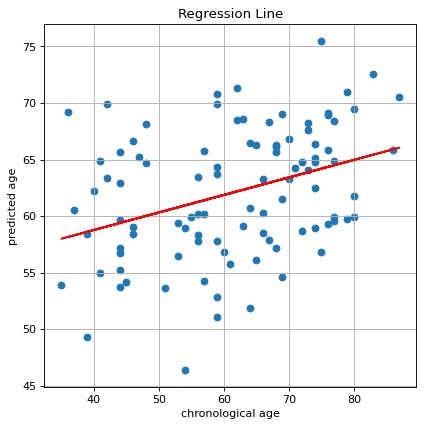

切片: 52.571350268931496
傾き: 0.1548912064029005
Kfold: 4 ::: epoch: 100, loss: 0.02302142820106103, val loss: 1.5552827417850494
Kfold: 4 ::: epoch: 200, loss: 0.01522101891728548, val loss: 1.4629294872283936
Kfold: 4 ::: epoch: 300, loss: 0.013731639223316541, val loss: 1.321694254875183
Kfold: 4 ::: epoch: 400, loss: 0.013916646739324698, val loss: 1.2716842293739319
Kfold: 4 ::: epoch: 500, loss: 0.009474591459505834, val loss: 1.1860913783311844
Kfold: 4 ::: epoch: 600, loss: 0.011628808059657995, val loss: 1.2194391191005707
Kfold: 4 ::: epoch: 700, loss: 0.011228430765466048, val loss: 1.1047842651605606
save_epochs:703


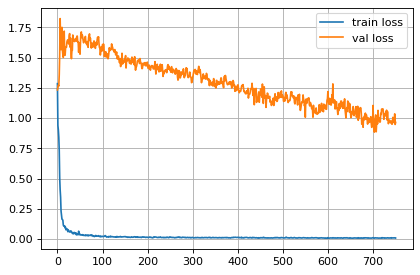

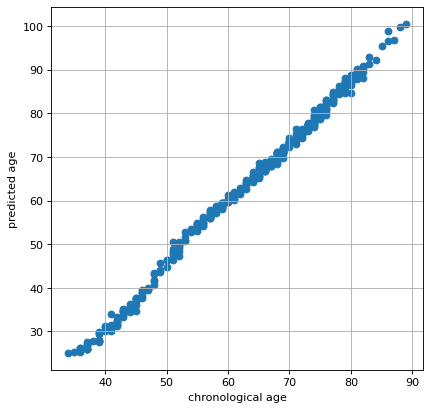

[[1.         0.99814522]
 [0.99814522 1.        ]]
r^2 train data:  0.8192606114029799


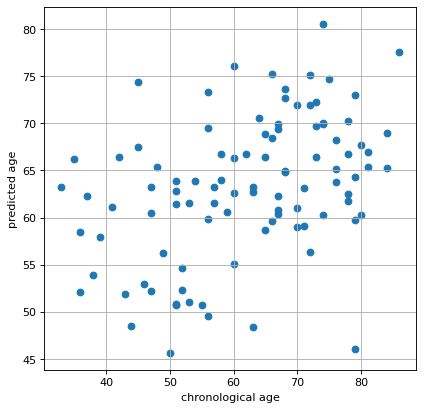

[[1.         0.41087139]
 [0.41087139 1.        ]]
r^2 val data:  0.13864957148360957


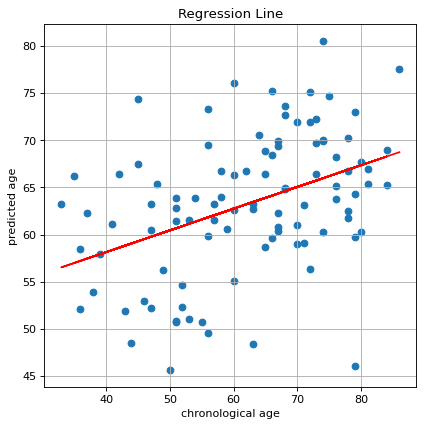

切片: 48.91559784956989
傾き: 0.23038560465371957
Kfold: 5 ::: epoch: 100, loss: 0.018938644144397516, val loss: 1.202729418873787
Kfold: 5 ::: epoch: 200, loss: 0.015939441939386036, val loss: 1.1436224281787872
Kfold: 5 ::: epoch: 300, loss: 0.011689820076124026, val loss: 1.0922411233186722
Kfold: 5 ::: epoch: 400, loss: 0.010721251547623139, val loss: 1.0456684678792953
Kfold: 5 ::: epoch: 500, loss: 0.011632050638302015, val loss: 0.9159396290779114
Kfold: 5 ::: epoch: 600, loss: 0.008496646160403123, val loss: 0.9525686204433441
Kfold: 5 ::: epoch: 700, loss: 0.009984261857775541, val loss: 0.8540144562721252
save_epochs:706


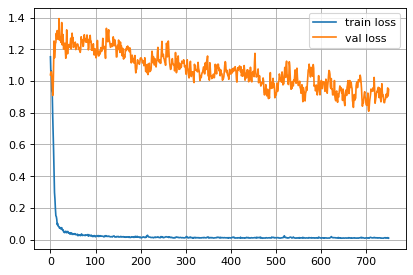

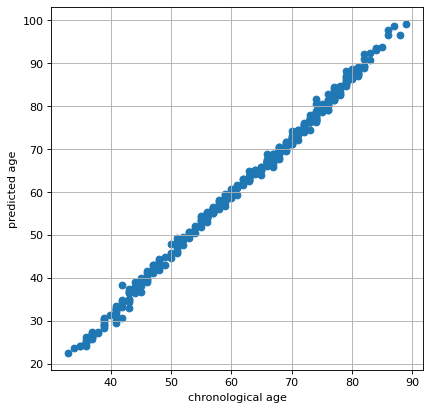

[[1.        0.9983069]
 [0.9983069 1.       ]]
r^2 train data:  0.8517608653975559


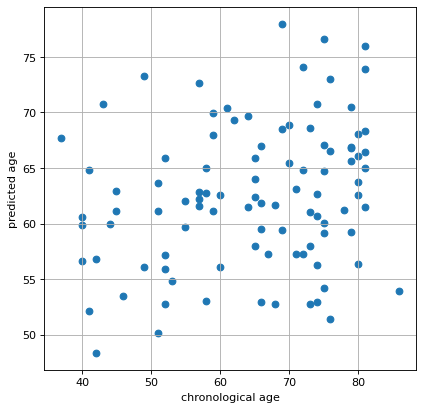

[[1.         0.23859434]
 [0.23859434 1.        ]]
r^2 val data:  -0.040696950820170885


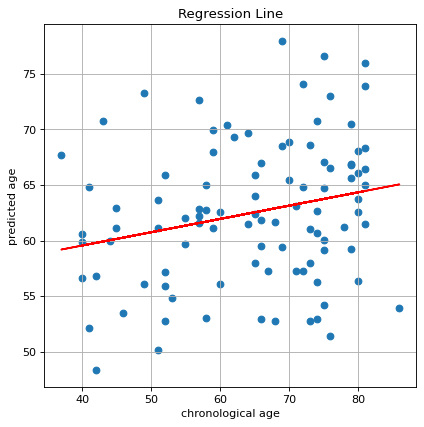

切片: 54.760437617200324
傾き: 0.11970669632427237
Nested Kfold ::: 4
Kfold: 1 ::: epoch: 100, loss: 0.020985666375893813, val loss: 0.558576725423336
Kfold: 1 ::: epoch: 200, loss: 0.014381018180686694, val loss: 0.4940866008400917
Kfold: 1 ::: epoch: 300, loss: 0.008527822756709961, val loss: 0.5107682049274445
Kfold: 1 ::: epoch: 400, loss: 0.008022470578837853, val loss: 0.5246919542551041
Kfold: 1 ::: epoch: 500, loss: 0.011531469698708791, val loss: 0.5637107715010643
Kfold: 1 ::: epoch: 600, loss: 0.008885513704556685, val loss: 0.5962634235620499
Kfold: 1 ::: epoch: 700, loss: 0.008412211417005612, val loss: 0.5788895785808563
save_epochs:467


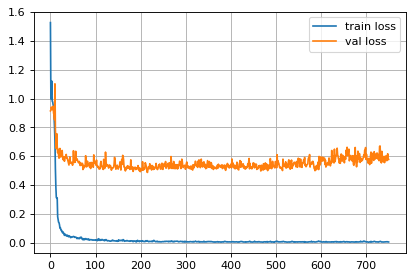

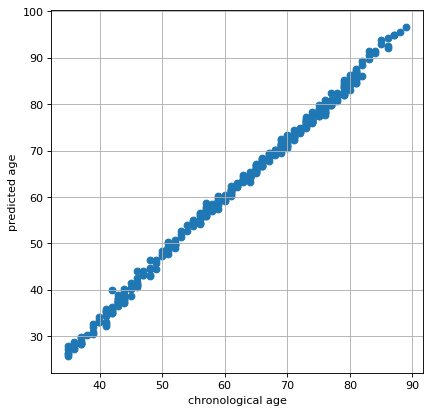

[[1.         0.99830164]
 [0.99830164 1.        ]]
r^2 train data:  0.9173124394552776


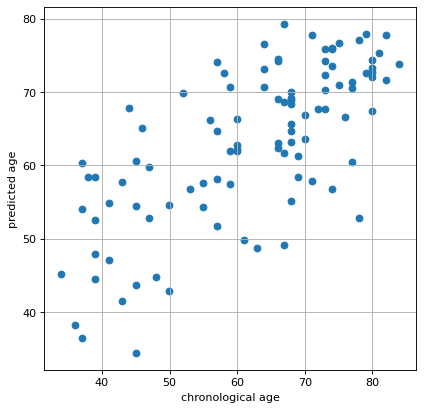

[[1.         0.70661977]
 [0.70661977 1.        ]]
r^2 val data:  0.4886777757693348


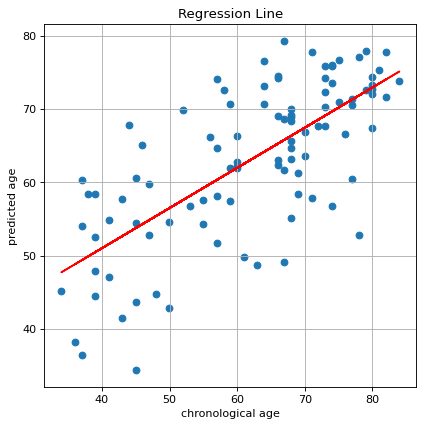

切片: 29.111875606681245
傾き: 0.5476273659918723
Kfold: 2 ::: epoch: 100, loss: 0.019021379474837046, val loss: 0.7698744833469391
Kfold: 2 ::: epoch: 200, loss: 0.009229214682888526, val loss: 0.7006141990423203
Kfold: 2 ::: epoch: 300, loss: 0.011820757009375554, val loss: 0.7096980065107346
Kfold: 2 ::: epoch: 400, loss: 0.00942698006446545, val loss: 0.6737878322601318
Kfold: 2 ::: epoch: 500, loss: 0.008559523830906702, val loss: 0.6490812823176384
Kfold: 2 ::: epoch: 600, loss: 0.006979425276557987, val loss: 0.7094566971063614
Kfold: 2 ::: epoch: 700, loss: 0.00978844491048501, val loss: 0.7637581527233124
save_epochs:473


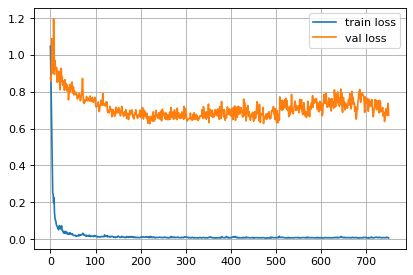

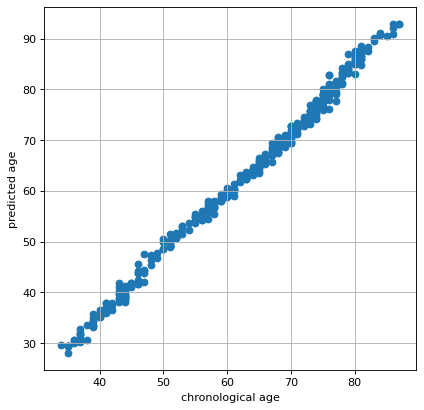

[[1.         0.99730422]
 [0.99730422 1.        ]]
r^2 train data:  0.9421848566203377


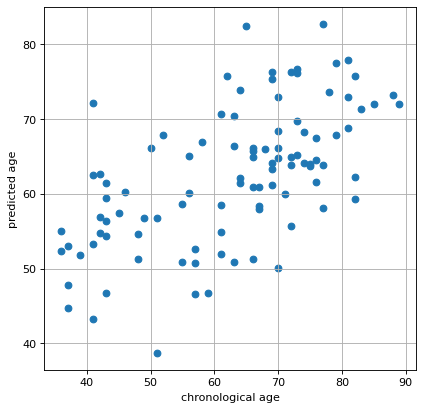

[[1.         0.60109965]
 [0.60109965 1.        ]]
r^2 val data:  0.35851387178856675


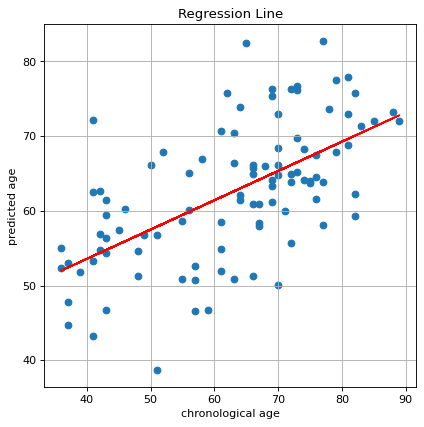

切片: 37.88803925950144
傾き: 0.3921812065157332
Kfold: 3 ::: epoch: 100, loss: 0.013414973464722816, val loss: 0.7727904468774796
Kfold: 3 ::: epoch: 200, loss: 0.011602567652097115, val loss: 0.6510809808969498
Kfold: 3 ::: epoch: 300, loss: 0.010901624551759316, val loss: 0.6981237381696701
Kfold: 3 ::: epoch: 400, loss: 0.008649171688235723, val loss: 0.68845234811306
Kfold: 3 ::: epoch: 500, loss: 0.013462294896061603, val loss: 0.5570548474788666
Kfold: 3 ::: epoch: 600, loss: 0.007691087845999461, val loss: 0.6149367094039917
Kfold: 3 ::: epoch: 700, loss: 0.009863426264088888, val loss: 0.6410332471132278
save_epochs:720


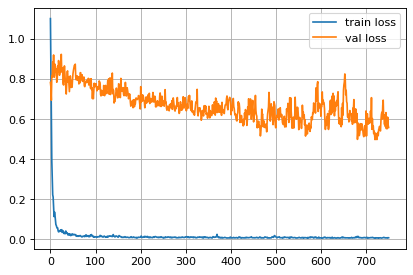

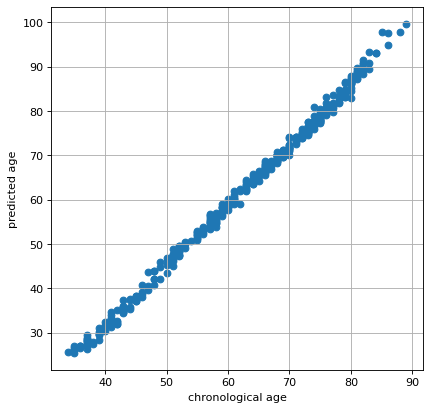

[[1.         0.99827783]
 [0.99827783 1.        ]]
r^2 train data:  0.8627010911243509


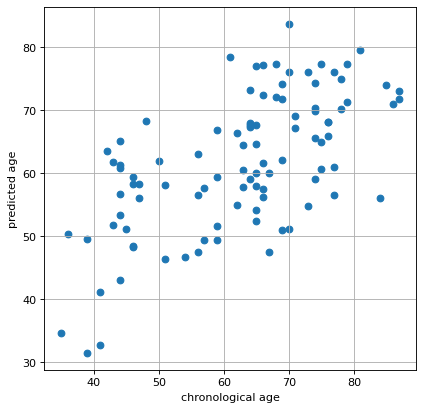

[[1.         0.63155352]
 [0.63155352 1.        ]]
r^2 val data:  0.36039658329135127


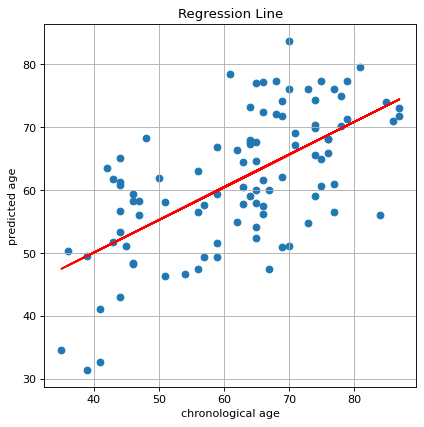

切片: 29.391535348112356
傾き: 0.5179924529085509
Kfold: 4 ::: epoch: 100, loss: 0.022159787253118478, val loss: 1.7546617984771729
Kfold: 4 ::: epoch: 200, loss: 0.017167503873889264, val loss: 1.636625051498413
Kfold: 4 ::: epoch: 300, loss: 0.013887138607410284, val loss: 1.5728294551372528
Kfold: 4 ::: epoch: 400, loss: 0.015104546999702087, val loss: 1.5064039528369904
Kfold: 4 ::: epoch: 500, loss: 0.011761965588308297, val loss: 1.6241010129451752
Kfold: 4 ::: epoch: 600, loss: 0.014320239782906495, val loss: 1.5134837627410889
Kfold: 4 ::: epoch: 700, loss: 0.012056361274937024, val loss: 1.518906369805336
save_epochs:748


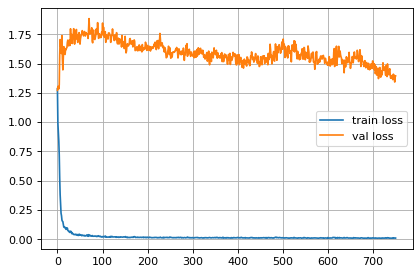

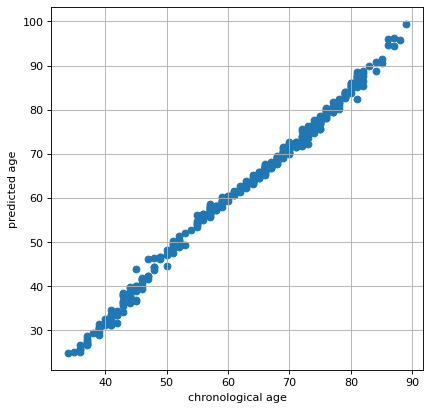

[[1.        0.9969058]
 [0.9969058 1.       ]]
r^2 train data:  0.9010199776205933


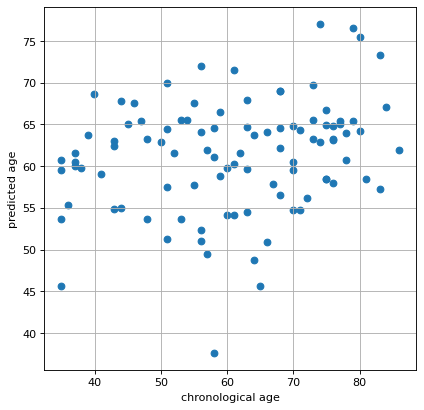

[[1.         0.24291034]
 [0.24291034 1.        ]]
r^2 val data:  0.0023895266797976378


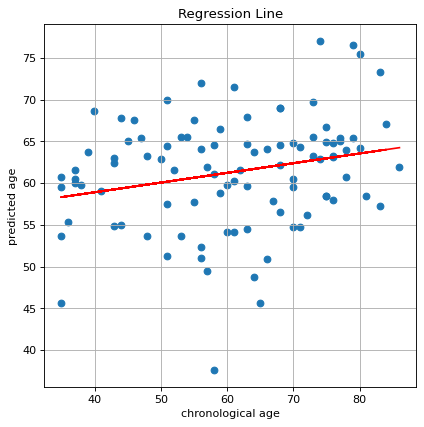

切片: 54.260461169340886
傾き: 0.11614236970540562
Kfold: 5 ::: epoch: 100, loss: 0.021802193485200405, val loss: 0.8759014904499054
Kfold: 5 ::: epoch: 200, loss: 0.009640058896575984, val loss: 0.7397512495517731
Kfold: 5 ::: epoch: 300, loss: 0.011521651445386501, val loss: 0.6490058526396751
Kfold: 5 ::: epoch: 400, loss: 0.007322064994906004, val loss: 0.5886256992816925
Kfold: 5 ::: epoch: 500, loss: 0.009928751199577864, val loss: 0.5517921522259712
Kfold: 5 ::: epoch: 600, loss: 0.007092839071097283, val loss: 0.5336775695905089
Kfold: 5 ::: epoch: 700, loss: 0.007634290314924259, val loss: 0.5740655139088631
save_epochs:512


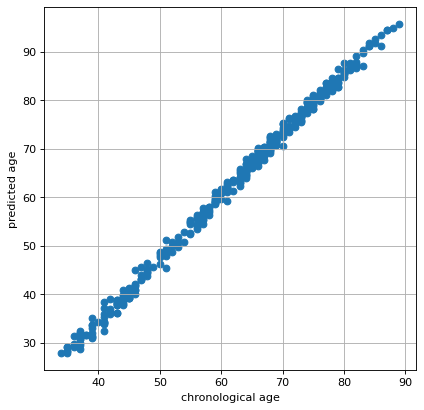

[[1.         0.99822732]
 [0.99822732 1.        ]]
r^2 train data:  0.9086400863232412


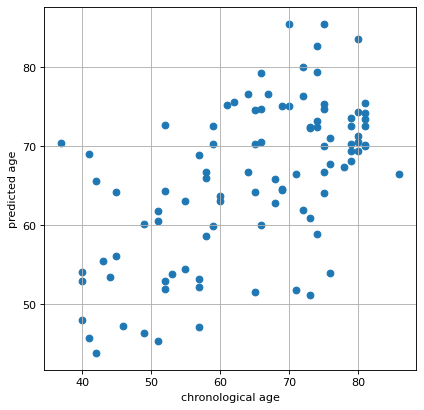

[[1.         0.58548029]
 [0.58548029 1.        ]]
r^2 val data:  0.3012993292251561


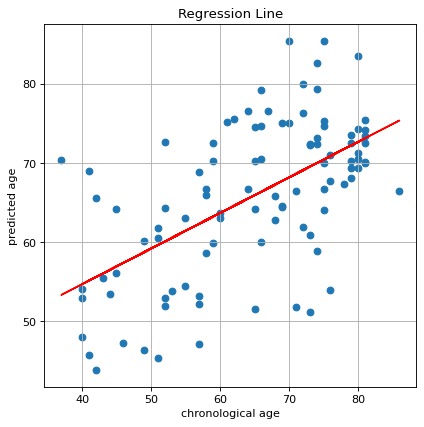

切片: 36.72767151417719
傾き: 0.44965836686503613
Nested Kfold ::: 5
Kfold: 1 ::: epoch: 100, loss: 0.017171490077789012, val loss: 0.6374091655015945
Kfold: 1 ::: epoch: 200, loss: 0.010026528464200405, val loss: 0.6542196124792099
Kfold: 1 ::: epoch: 300, loss: 0.016238200979737136, val loss: 0.7830462083220482
Kfold: 1 ::: epoch: 400, loss: 0.009717196906701876, val loss: 0.8029519096016884
Kfold: 1 ::: epoch: 500, loss: 0.008607374826589456, val loss: 0.8613807186484337
Kfold: 1 ::: epoch: 600, loss: 0.008154904362387382, val loss: 0.8200478702783585
Kfold: 1 ::: epoch: 700, loss: 0.012031409674539017, val loss: 0.8249645233154297
save_epochs:254


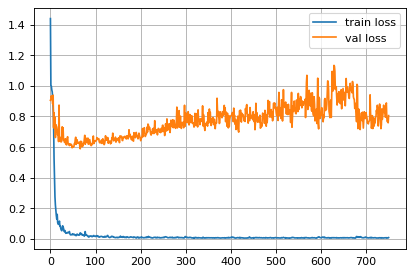

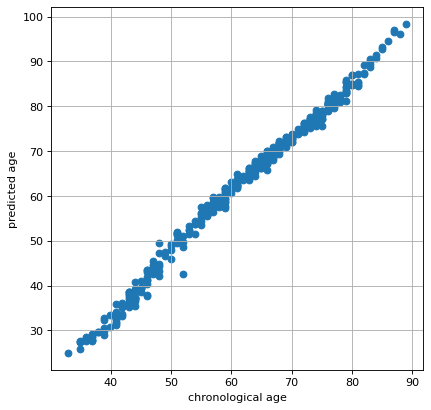

[[1.         0.99578763]
 [0.99578763 1.        ]]
r^2 train data:  0.8902984502321719


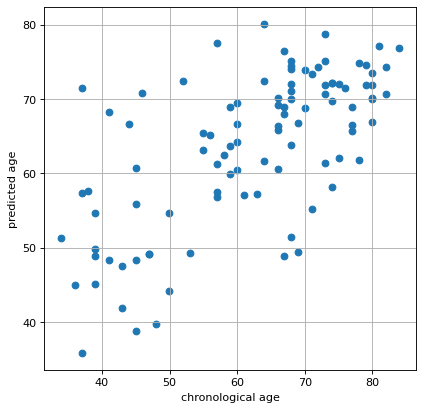

[[1.         0.66186081]
 [0.66186081 1.        ]]
r^2 val data:  0.416435549397007


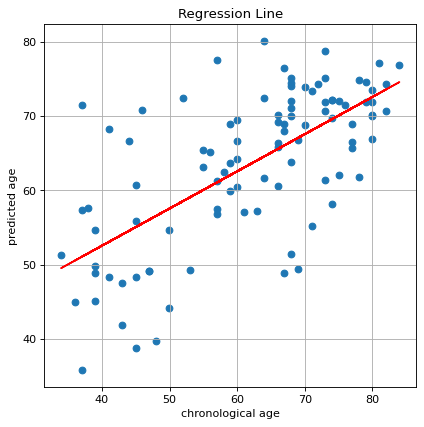

切片: 32.562006429858215
傾き: 0.49999176793681693
Kfold: 2 ::: epoch: 100, loss: 0.023524520345605336, val loss: 0.6870815604925156
Kfold: 2 ::: epoch: 200, loss: 0.0087645838323694, val loss: 0.6760304644703865
Kfold: 2 ::: epoch: 300, loss: 0.008213895158125805, val loss: 0.6749721989035606
Kfold: 2 ::: epoch: 400, loss: 0.007724653893651871, val loss: 0.6772351190447807
Kfold: 2 ::: epoch: 500, loss: 0.008458397279565152, val loss: 0.6838296949863434
Kfold: 2 ::: epoch: 600, loss: 0.006816737138881133, val loss: 0.7351734265685081
Kfold: 2 ::: epoch: 700, loss: 0.00938207065113462, val loss: 0.7513360530138016
save_epochs:529


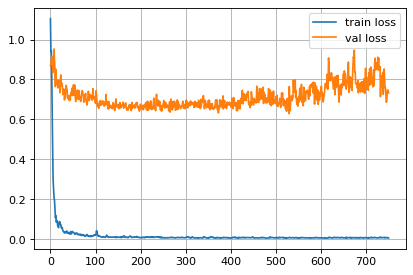

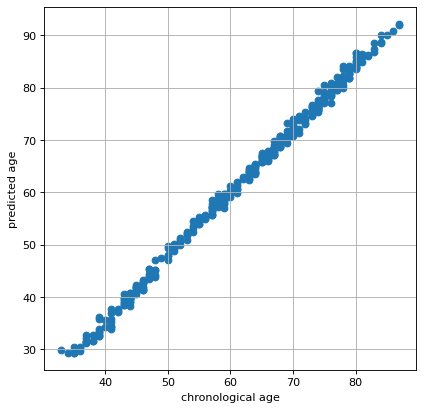

[[1.        0.9984997]
 [0.9984997 1.       ]]
r^2 train data:  0.9465562039780763


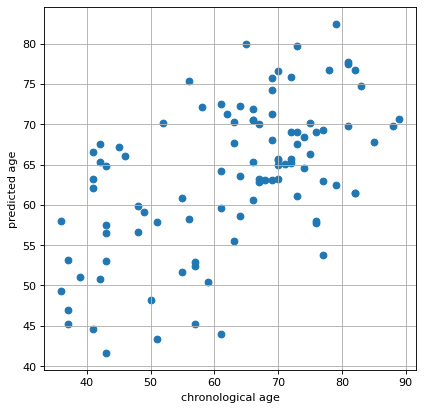

[[1.         0.56695795]
 [0.56695795 1.        ]]
r^2 val data:  0.30955383035967843


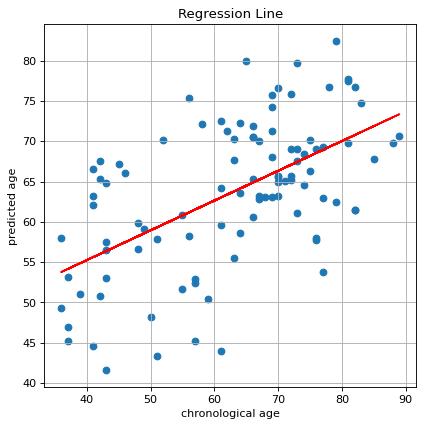

切片: 40.49876630663303
傾き: 0.36902825913124654
Kfold: 3 ::: epoch: 100, loss: 0.012024093562593827, val loss: 0.6638233214616776
Kfold: 3 ::: epoch: 200, loss: 0.010623840436052818, val loss: 0.5950373932719231
Kfold: 3 ::: epoch: 300, loss: 0.012302387183388839, val loss: 0.6006118059158325
Kfold: 3 ::: epoch: 400, loss: 0.010509247103562722, val loss: 0.5566277056932449
Kfold: 3 ::: epoch: 500, loss: 0.00815764726856007, val loss: 0.5738400965929031
Kfold: 3 ::: epoch: 600, loss: 0.008513583730046567, val loss: 0.5562878623604774
Kfold: 3 ::: epoch: 700, loss: 0.007092498618966112, val loss: 0.602828286588192
save_epochs:553


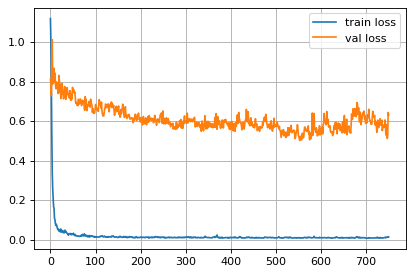

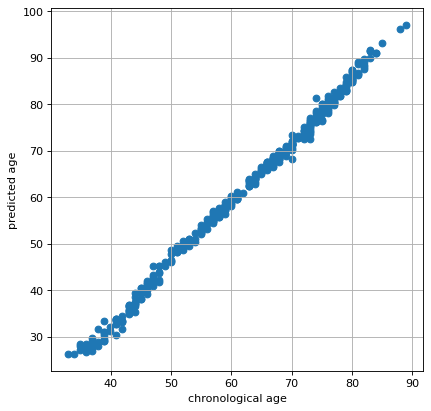

[[1.         0.99811229]
 [0.99811229 1.        ]]
r^2 train data:  0.8930775497672434


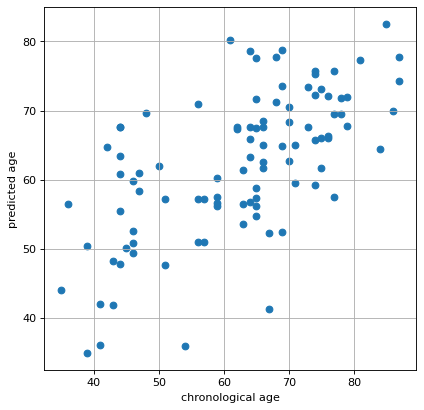

[[1.         0.63609784]
 [0.63609784 1.        ]]
r^2 val data:  0.3791160826202479


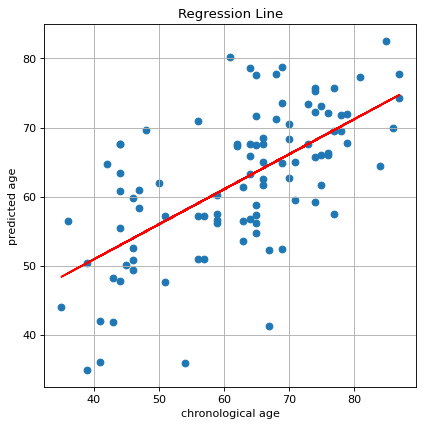

切片: 30.69443707667546
傾き: 0.5059284556629683
Kfold: 4 ::: epoch: 100, loss: 0.018537614673662644, val loss: 1.3805254995822906
Kfold: 4 ::: epoch: 200, loss: 0.016339873536848105, val loss: 1.0293636322021484
Kfold: 4 ::: epoch: 300, loss: 0.01181777692041718, val loss: 0.9938088804483414
Kfold: 4 ::: epoch: 400, loss: 0.01220999898102421, val loss: 0.8993649035692215
Kfold: 4 ::: epoch: 500, loss: 0.009447030543994445, val loss: 0.7085155099630356
Kfold: 4 ::: epoch: 600, loss: 0.010048143619384903, val loss: 0.7594439089298248
Kfold: 4 ::: epoch: 700, loss: 0.00936424986530955, val loss: 0.7191521376371384
save_epochs:646


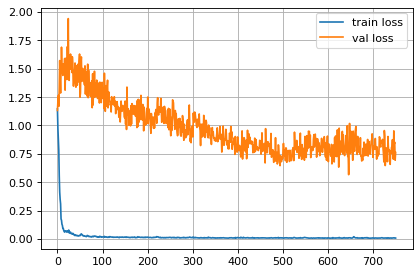

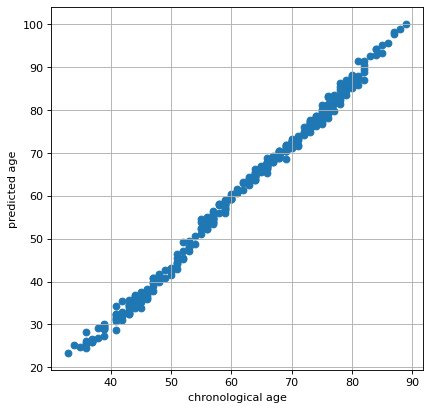

[[1.         0.99803925]
 [0.99803925 1.        ]]
r^2 train data:  0.8189532965666495


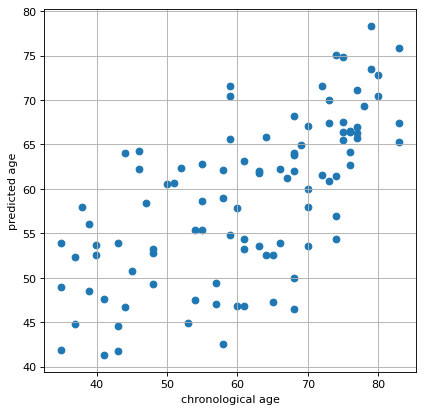

[[1.         0.66188483]
 [0.66188483 1.        ]]
r^2 val data:  0.4140306356625111


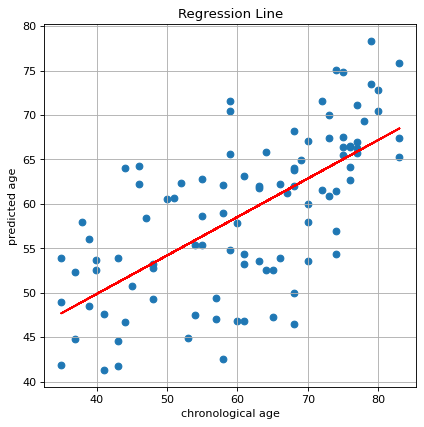

切片: 32.53268533021747
傾き: 0.43319765324118137
Kfold: 5 ::: epoch: 100, loss: 0.021562169305980206, val loss: 0.846196636557579
Kfold: 5 ::: epoch: 200, loss: 0.013001783894231686, val loss: 0.7854066789150238
Kfold: 5 ::: epoch: 300, loss: 0.012767931876274256, val loss: 0.7806971222162247
Kfold: 5 ::: epoch: 400, loss: 0.006791544827417686, val loss: 0.8009471595287323
Kfold: 5 ::: epoch: 500, loss: 0.008613723330199718, val loss: 0.8670425862073898
Kfold: 5 ::: epoch: 600, loss: 0.007168730685057549, val loss: 1.1129978746175766
Kfold: 5 ::: epoch: 700, loss: 0.007779078486447151, val loss: 0.7609543055295944
save_epochs:677


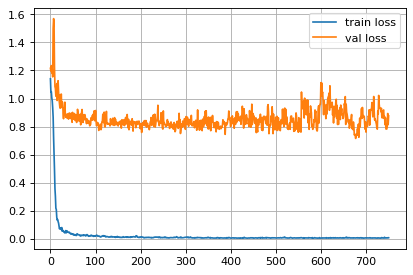

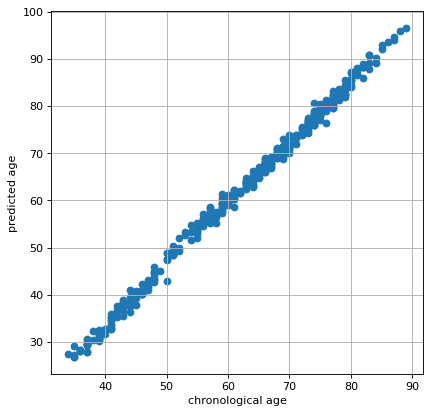

[[1.         0.99796653]
 [0.99796653 1.        ]]
r^2 train data:  0.9084952647874812


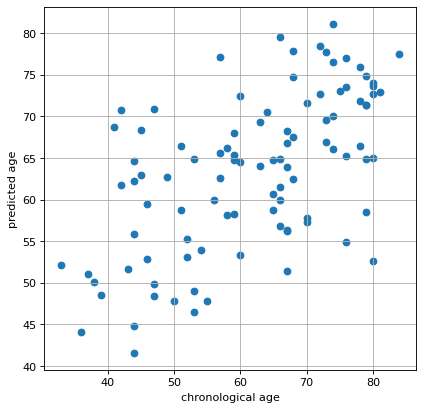

[[1.         0.58478357]
 [0.58478357 1.        ]]
r^2 val data:  0.3116603758869393


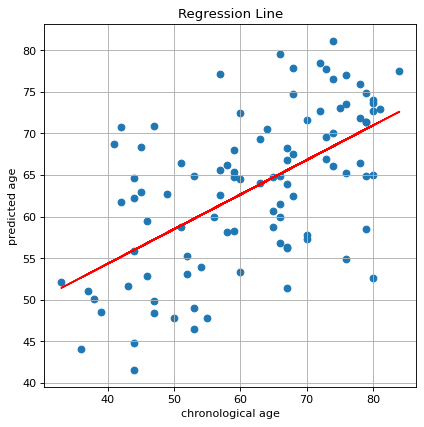

切片: 37.741332204876855
傾き: 0.41511033399494607
CPU times: user 1d 5h 17min 48s, sys: 1min 55s, total: 1d 5h 19min 44s
Wall time: 4h 13min 51s


In [21]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_all_dynamic_1  = []
test_label_all_dynamic_1 = []

test_idx_all_dynamic_1   = []
train_idx_all_dynamic_1  = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_dynamic_aal)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_label = train_model(data_dynamic_aal,
                                       data_label,
                                       train_idx  = train_idx,
                                       test_idx   = test_idx,
                                       epochs     = 750,
                                       d_model    = 64,
                                       n_splits   = n_splits,
                                       hidden_dim = 256,
                                       nhead      = 2,#4
                                       hidden_dim_transformer = 1,#2
                                       pos_drop    = 0.3,
                                       trans_drop = 0.5,
                                       fc_drop = 0.3
                                      )
    test_pred_all_dynamic_1.append(test_pred)
    test_label_all_dynamic_1.append(test_label)
    test_idx_all_dynamic_1.append(test_idx)
    train_idx_all_dynamic_1.append(train_idx)

LinearRegression()

<Figure size 480x480 with 0 Axes>

Text(0.5, 1.0, 'Regression Line')

Text(0.5, 0, 'chronological age')

Text(0, 0.5, 'predicted age')

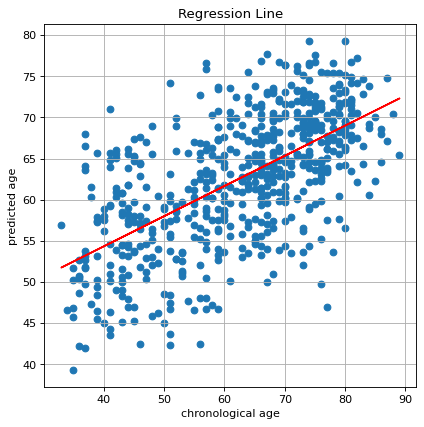

相関係数:  0.6168496231020755
r^2 test data:  0.37988613697185714
切片:  39.65887521332862
傾き:  0.36665996904217


In [22]:
for i in range(n_splits):
    if not i:
        test_label = test_label_all_dynamic_1[i]
    else:
        test_label = np.concatenate([test_label,test_label_all_dynamic_1[i]])
        
for i in range(n_splits):
    if not i:
        test_pred = test_pred_all_dynamic_1[i].mean(axis=0)
    else:
        test_pred = np.concatenate([test_pred,test_pred_all_dynamic_1[i].mean(axis=0)])

lr = LinearRegression()
lr.fit(test_label*age_std+age_mean,test_pred[:,0]*age_std+age_mean)

plt.figure(figsize=(6, 6), dpi=80)
plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[:,0]*age_std+age_mean)#散布図をプロット
plt.plot(test_label[:,0]*age_std+age_mean,
         lr.predict(test_label*age_std+age_mean), color = 'red')#回帰直線をプロット

plt.title('Regression Line')   # 図のタイトル
plt.xlabel('chronological age')# x軸のラベル
plt.ylabel('predicted age')    # y軸のラベル
plt.grid()                     # グリッド線を表示
plt.show()                     # 図の表示

print('相関係数: ', np.corrcoef(test_label[:,0],test_pred[:,0])[0,1])
print('r^2 test data: ', r2_score(test_label[:,0],test_pred[:,0]))
print('切片: ', lr.intercept_)
print('傾き: ', lr.coef_[0])

<Figure size 480x480 with 0 Axes>

Text(0.5, 1.0, 'Regression Line')

Text(0.5, 0, 'diff')

Text(0, 0.5, 'apathy')

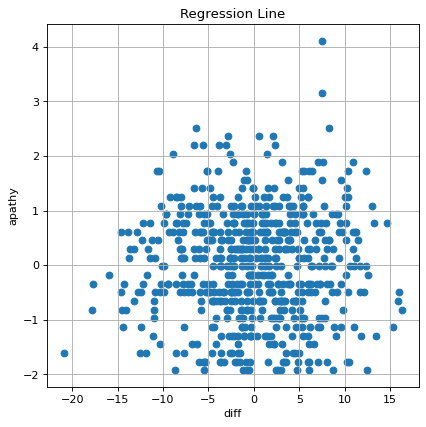

相関係数: 0.016879548408177587
p値: 0.6761099167892405


In [23]:
diff = test_pred[:,0]*age_std + age_mean - lr.predict(test_label*age_std + age_mean)

plt.figure(figsize=(6, 6), dpi=80)
plt.scatter(diff,data_label[:,2])
plt.title('Regression Line')   # 図のタイトル
plt.xlabel('diff')    # x軸のラベル
plt.ylabel('apathy')  # y軸のラベル
plt.grid()                     # グリッド線を表示
plt.show()                     # 図の表示

corr,p = pearsonr(diff,data_label[:,2])
print("相関係数:", corr)
print("p値:", p)

### 学習 dynamic FC 2

Nested Kfold ::: 1
Kfold: 1 ::: epoch: 100, loss: 0.013506033242895054, val loss: 0.5820982530713081
Kfold: 1 ::: epoch: 200, loss: 0.012641642063569564, val loss: 0.5438655074685812
Kfold: 1 ::: epoch: 300, loss: 0.009372528642416, val loss: 0.47499276674352586
Kfold: 1 ::: epoch: 400, loss: 0.00851410093645637, val loss: 0.505633550696075
Kfold: 1 ::: epoch: 500, loss: 0.01030860010247964, val loss: 0.521755738183856
Kfold: 1 ::: epoch: 600, loss: 0.012960801796557812, val loss: 0.5622810684144497
Kfold: 1 ::: epoch: 700, loss: 0.008651014551735269, val loss: 0.5820961184799671
save_epochs:439


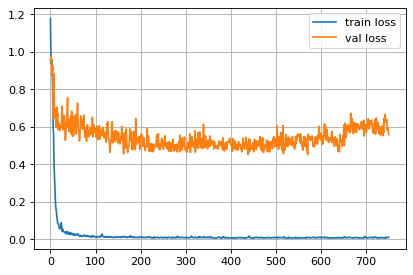

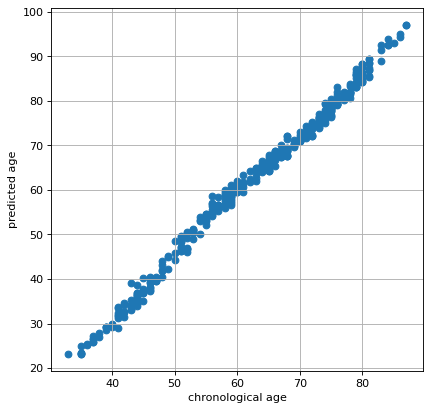

[[1.         0.99628035]
 [0.99628035 1.        ]]
r^2 train data:  0.852648699267383


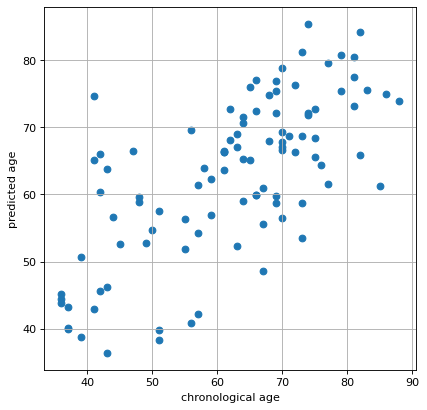

[[1.         0.69554689]
 [0.69554689 1.        ]]
r^2 val data:  0.4537273425286943


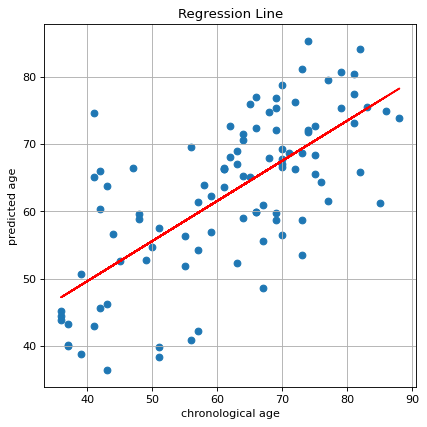

切片: 25.72423139803071
傾き: 0.5973542733286927
Kfold: 2 ::: epoch: 100, loss: 0.020735061942384794, val loss: 1.1391412168741226
Kfold: 2 ::: epoch: 200, loss: 0.013656666251615835, val loss: 0.8408260345458984
Kfold: 2 ::: epoch: 300, loss: 0.01375312816638213, val loss: 0.7104947865009308
Kfold: 2 ::: epoch: 400, loss: 0.015973872075287197, val loss: 0.5909543037414551
Kfold: 2 ::: epoch: 500, loss: 0.011613541569274206, val loss: 0.5148031711578369
Kfold: 2 ::: epoch: 600, loss: 0.009691378567367792, val loss: 0.49635274708271027
Kfold: 2 ::: epoch: 700, loss: 0.009654270198482733, val loss: 0.486386276781559
save_epochs:710


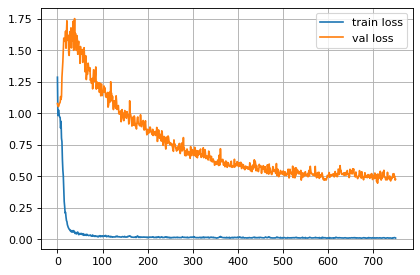

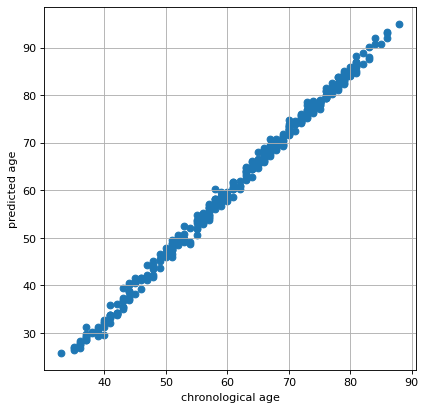

[[1.         0.99828834]
 [0.99828834 1.        ]]
r^2 train data:  0.9011350555246442


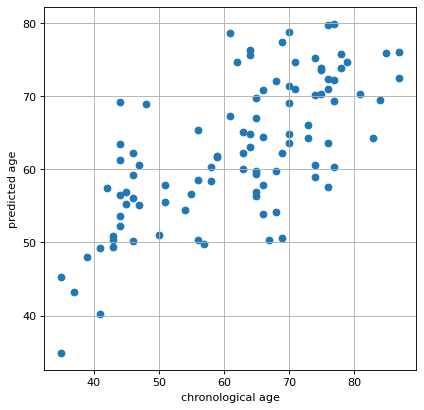

[[1.         0.69949446]
 [0.69949446 1.        ]]
r^2 val data:  0.48718142919864627


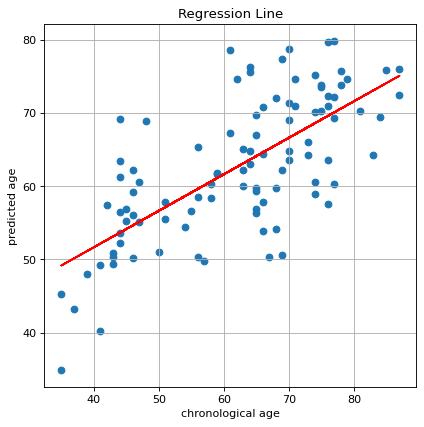

切片: 31.732470170657937
傾き: 0.4986067154125172
Kfold: 3 ::: epoch: 100, loss: 0.014145980589091778, val loss: 0.7313875779509544
Kfold: 3 ::: epoch: 200, loss: 0.013943718889584908, val loss: 0.7180705443024635
Kfold: 3 ::: epoch: 300, loss: 0.011506842807508431, val loss: 0.6710789874196053
Kfold: 3 ::: epoch: 400, loss: 0.009889688486090073, val loss: 0.6718288064002991
Kfold: 3 ::: epoch: 500, loss: 0.012506694461290654, val loss: 0.6078347414731979
Kfold: 3 ::: epoch: 600, loss: 0.011416731402277946, val loss: 0.6573461890220642
Kfold: 3 ::: epoch: 700, loss: 0.00925285559004316, val loss: 0.6887662336230278
save_epochs:567


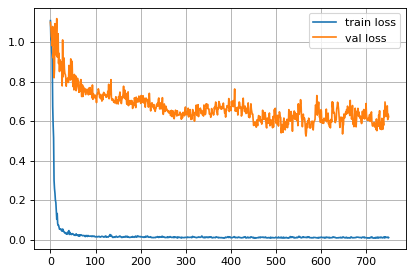

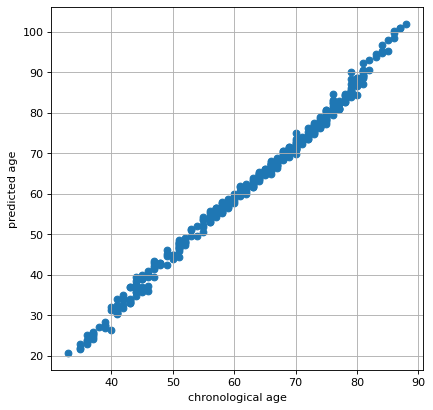

[[1.         0.99704976]
 [0.99704976 1.        ]]
r^2 train data:  0.81666869512679


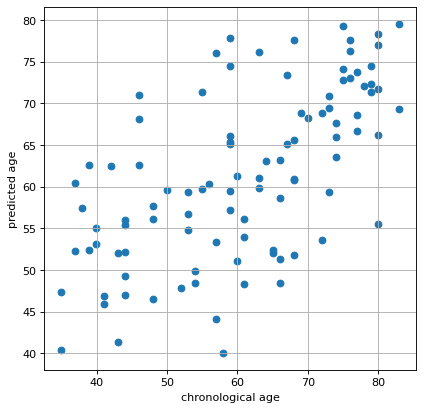

[[1.        0.6241209]
 [0.6241209 1.       ]]
r^2 val data:  0.3705077229655763


切片: 33.042129880234626
傾き: 0.46780432448265885
Kfold: 4 ::: epoch: 100, loss: 0.015968964936641548, val loss: 0.874262660741806
Kfold: 4 ::: epoch: 200, loss: 0.011287827188005814, val loss: 0.68132084608078
Kfold: 4 ::: epoch: 300, loss: 0.011006915906014351, val loss: 0.6868981420993805
Kfold: 4 ::: epoch: 400, loss: 0.012855027067976503, val loss: 0.5793541446328163
Kfold: 4 ::: epoch: 500, loss: 0.007673093368514226, val loss: 0.6054183766245842
Kfold: 4 ::: epoch: 600, loss: 0.00738918032640448, val loss: 0.5836452543735504
Kfold: 4 ::: epoch: 700, loss: 0.00962676888761612, val loss: 0.6849705874919891
save_epochs:420


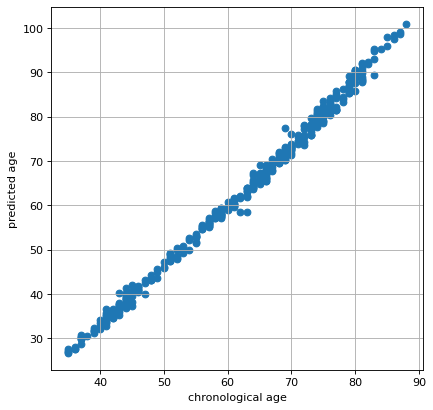

[[1.         0.99733871]
 [0.99733871 1.        ]]
r^2 train data:  0.8484215385257543


[[1.         0.67681285]
 [0.67681285 1.        ]]
r^2 val data:  0.40099669414021577


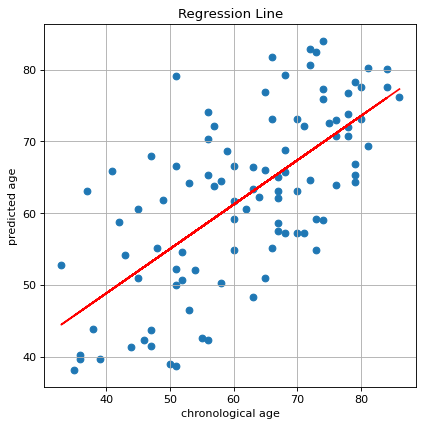

切片: 24.099246169466554
傾き: 0.6183477183245429
Kfold: 5 ::: epoch: 100, loss: 0.023699250573722217, val loss: 1.3904114663600922
Kfold: 5 ::: epoch: 200, loss: 0.01557965175463603, val loss: 1.2859141901135445
Kfold: 5 ::: epoch: 300, loss: 0.015519409297177425, val loss: 1.1745057478547096
Kfold: 5 ::: epoch: 400, loss: 0.012068086984352423, val loss: 1.0857186019420624
Kfold: 5 ::: epoch: 500, loss: 0.01260186878677744, val loss: 1.136703759431839
Kfold: 5 ::: epoch: 600, loss: 0.014055334819624057, val loss: 1.2214054465293884
Kfold: 5 ::: epoch: 700, loss: 0.011958766639089355, val loss: 1.1784173846244812
save_epochs:390


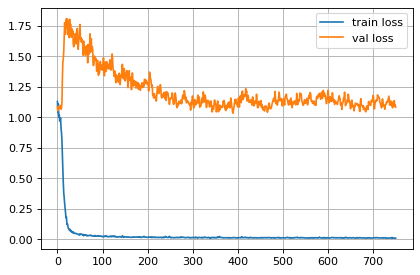

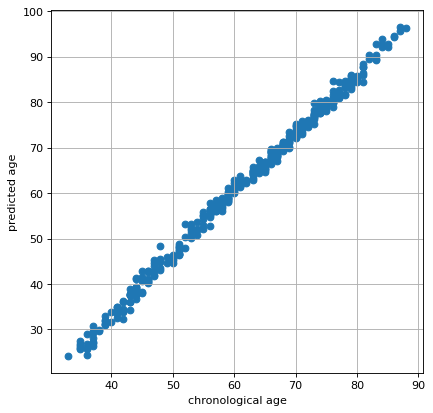

[[1.         0.99772095]
 [0.99772095 1.        ]]
r^2 train data:  0.8840870792937905


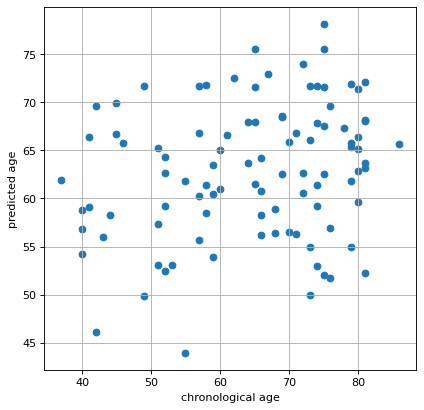

[[1.         0.24029027]
 [0.24029027 1.        ]]
r^2 val data:  -0.05568149569473002


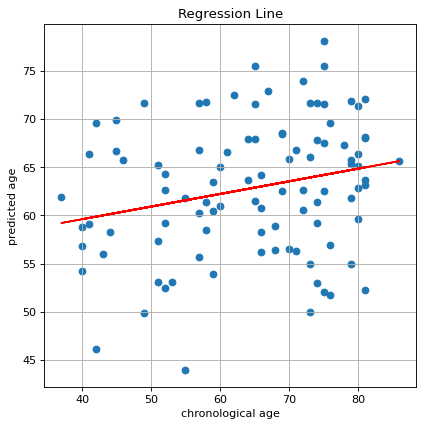

切片: 54.361934913179354
傾き: 0.13115601016465067
Nested Kfold ::: 2
Kfold: 1 ::: epoch: 100, loss: 0.015721039130137518, val loss: 0.7805300205945969
Kfold: 1 ::: epoch: 200, loss: 0.00972446663161883, val loss: 0.8103055357933044
Kfold: 1 ::: epoch: 300, loss: 0.007342364173382521, val loss: 0.7518400996923447
Kfold: 1 ::: epoch: 400, loss: 0.00996682053216948, val loss: 0.8054488599300385
Kfold: 1 ::: epoch: 500, loss: 0.00867914453220482, val loss: 0.8386111408472061
Kfold: 1 ::: epoch: 600, loss: 0.007957277138932394, val loss: 0.8487581014633179
Kfold: 1 ::: epoch: 700, loss: 0.01659042904010186, val loss: 0.7955848276615143
save_epochs:652


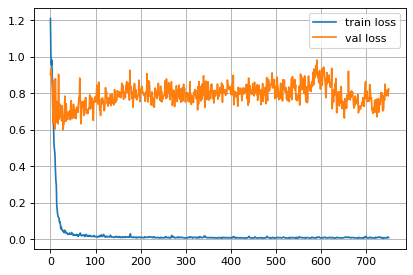

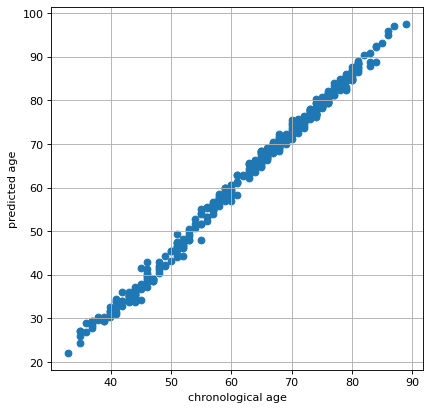

[[1.         0.99750953]
 [0.99750953 1.        ]]
r^2 train data:  0.85265884749845


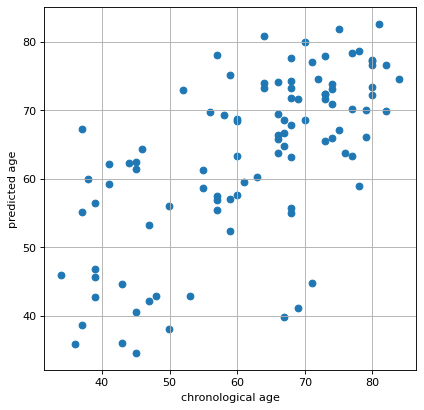

[[1.         0.65836365]
 [0.65836365 1.        ]]
r^2 val data:  0.36832401814798965


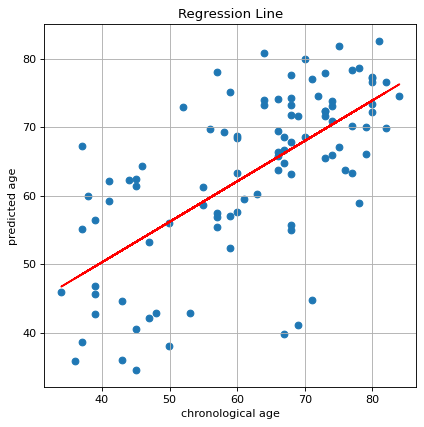

切片: 26.67052424602445
傾き: 0.5902064880379126
Kfold: 2 ::: epoch: 100, loss: 0.01757506116365011, val loss: 0.8048135489225388
Kfold: 2 ::: epoch: 200, loss: 0.009604004498284597, val loss: 0.6352511867880821
Kfold: 2 ::: epoch: 300, loss: 0.008240115990002569, val loss: 0.5996983423829079
Kfold: 2 ::: epoch: 400, loss: 0.015340198440333972, val loss: 0.5678506568074226
Kfold: 2 ::: epoch: 500, loss: 0.008568782466821946, val loss: 0.49840541929006577
Kfold: 2 ::: epoch: 600, loss: 0.00911564684401338, val loss: 0.4963505920022726
Kfold: 2 ::: epoch: 700, loss: 0.011352950384697089, val loss: 0.5172625854611397
save_epochs:750


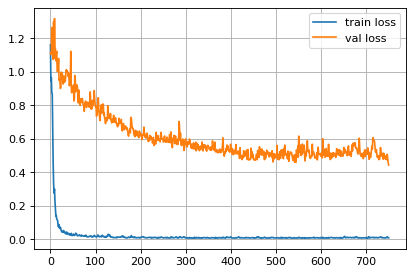

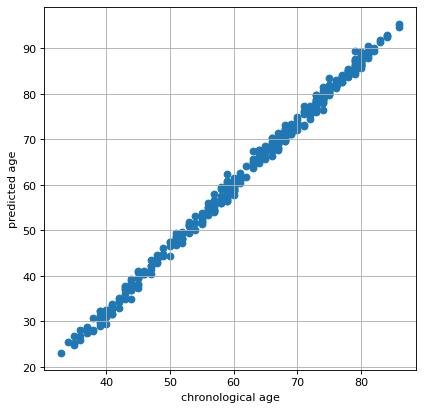

[[1.         0.99830689]
 [0.99830689 1.        ]]
r^2 train data:  0.8442268345108161


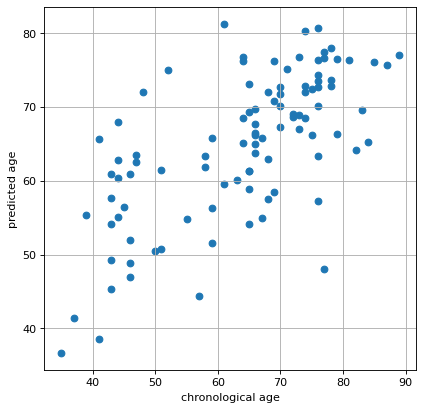

[[1.         0.66428875]
 [0.66428875 1.        ]]
r^2 val data:  0.4298660478618308


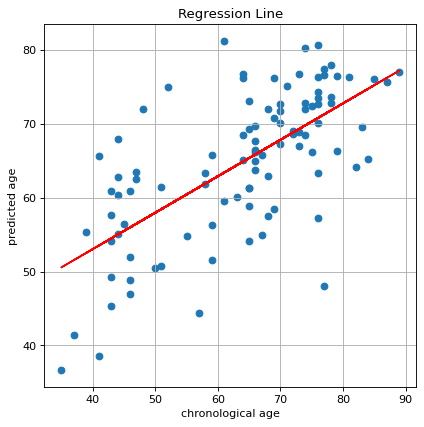

切片: 33.29965363269372
傾き: 0.4933738239553423
Kfold: 3 ::: epoch: 100, loss: 0.01639754196199087, val loss: 0.7930865734815598
Kfold: 3 ::: epoch: 200, loss: 0.01071995271083254, val loss: 0.7284626662731171
Kfold: 3 ::: epoch: 300, loss: 0.010586714622779535, val loss: 0.7582773119211197
Kfold: 3 ::: epoch: 400, loss: 0.010075685120402621, val loss: 0.7252969592809677
Kfold: 3 ::: epoch: 500, loss: 0.01131613484512155, val loss: 0.6469500884413719
Kfold: 3 ::: epoch: 600, loss: 0.008688607396414647, val loss: 0.7173476442694664
Kfold: 3 ::: epoch: 700, loss: 0.010880041348103147, val loss: 0.7923148721456528
save_epochs:319


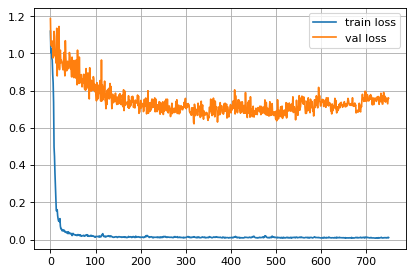

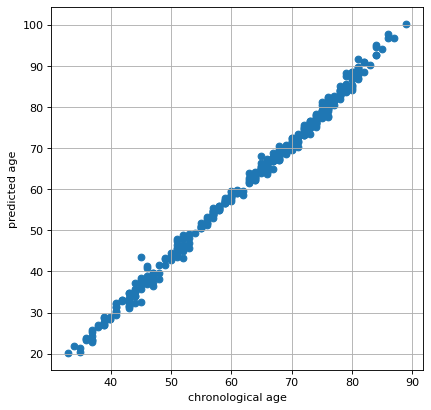

[[1.         0.99776986]
 [0.99776986 1.        ]]
r^2 train data:  0.8070799565693607


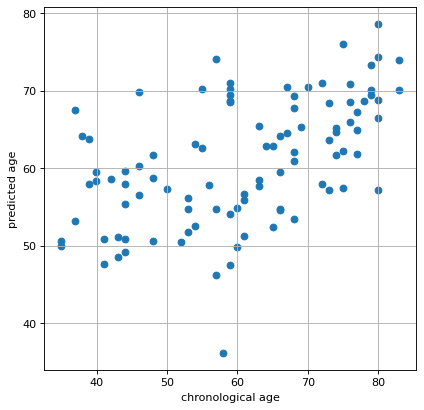

[[1.         0.52761455]
 [0.52761455 1.        ]]
r^2 val data:  0.27341751601937037


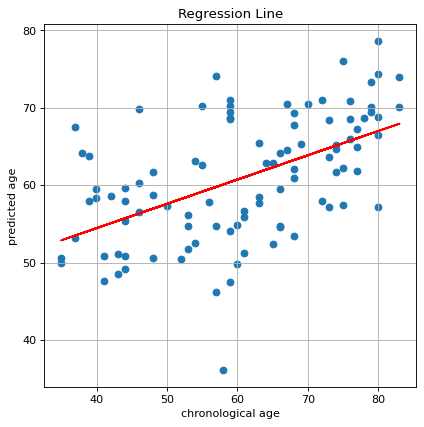

切片: 41.90083234144427
傾き: 0.31373923105126533
Kfold: 4 ::: epoch: 100, loss: 0.019174103481838338, val loss: 1.0172425359487534
Kfold: 4 ::: epoch: 200, loss: 0.0099998560304252, val loss: 0.8769736886024475
Kfold: 4 ::: epoch: 300, loss: 0.010139909895280233, val loss: 0.9035032391548157
Kfold: 4 ::: epoch: 400, loss: 0.009161410387605429, val loss: 0.8612313866615295
Kfold: 4 ::: epoch: 500, loss: 0.009633337469914785, val loss: 0.9227485954761505
Kfold: 4 ::: epoch: 600, loss: 0.010781453492549749, val loss: 0.9457550793886185
Kfold: 4 ::: epoch: 700, loss: 0.010287221234578352, val loss: 1.0437872558832169
save_epochs:398


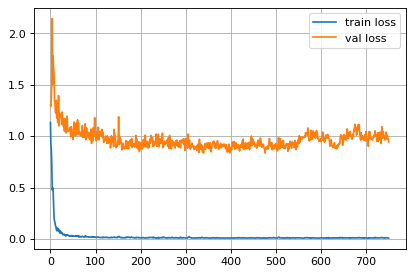

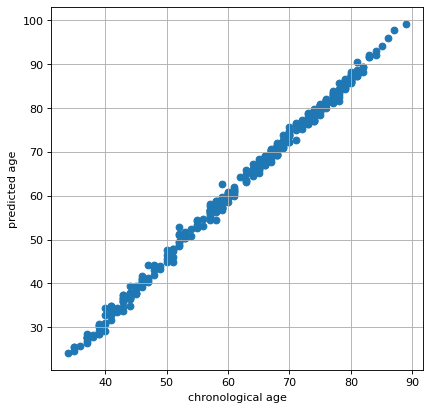

[[1.         0.99844818]
 [0.99844818 1.        ]]
r^2 train data:  0.8527603617148726


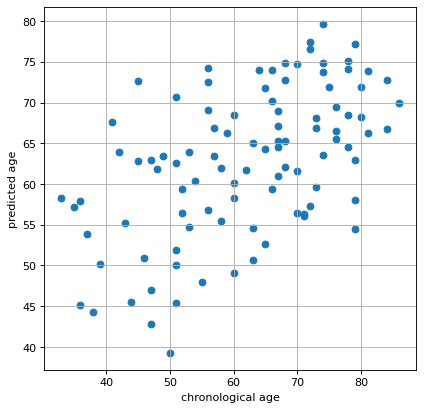

[[1.         0.54222235]
 [0.54222235 1.        ]]
r^2 val data:  0.272818409272632


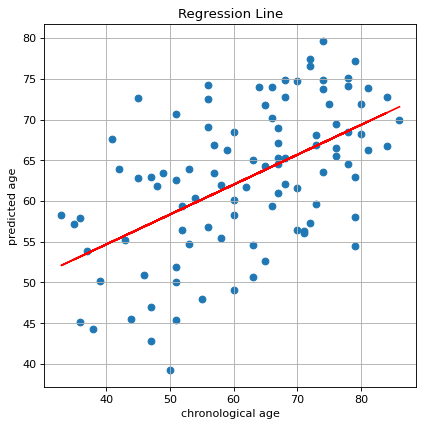

切片: 39.97976913697854
傾き: 0.3672316971837172
Kfold: 5 ::: epoch: 100, loss: 0.02090974051791888, val loss: 0.9004983752965927
Kfold: 5 ::: epoch: 200, loss: 0.013260316461897813, val loss: 0.8080588430166245
Kfold: 5 ::: epoch: 300, loss: 0.008834079301987704, val loss: 0.7488385438919067
Kfold: 5 ::: epoch: 400, loss: 0.00981150227240645, val loss: 0.7090553119778633
Kfold: 5 ::: epoch: 500, loss: 0.014492699948067848, val loss: 0.7095558196306229
Kfold: 5 ::: epoch: 600, loss: 0.011577491147013811, val loss: 0.7979319989681244
Kfold: 5 ::: epoch: 700, loss: 0.008930441744339008, val loss: 0.7436394542455673
save_epochs:441


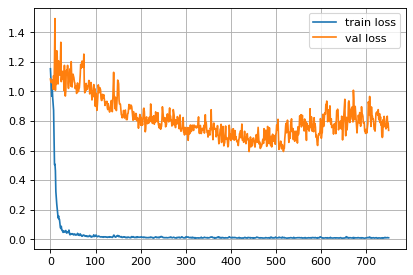

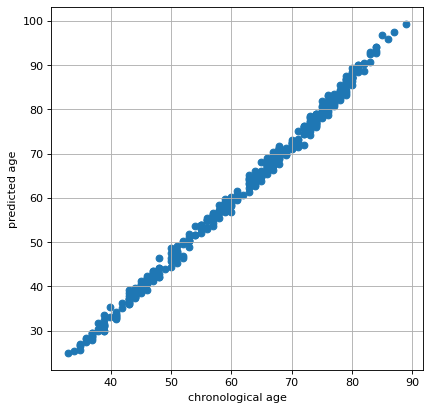

[[1.         0.99790267]
 [0.99790267 1.        ]]
r^2 train data:  0.8776222582511013


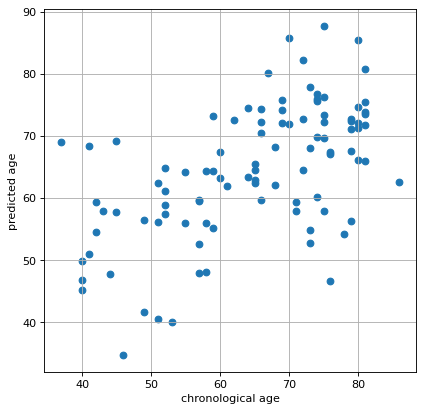

[[1.         0.57089036]
 [0.57089036 1.        ]]
r^2 val data:  0.2554528642324737


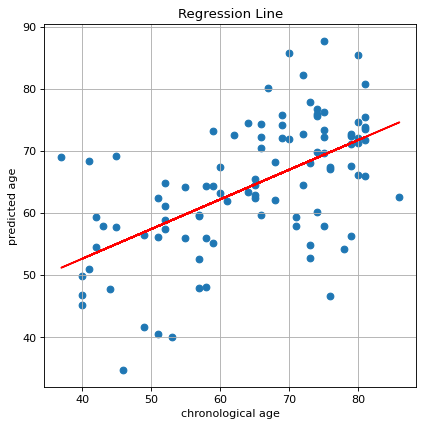

切片: 33.55918782624081
傾き: 0.47705458940454337
Nested Kfold ::: 3
Kfold: 1 ::: epoch: 100, loss: 0.024214006387270413, val loss: 0.845172256231308
Kfold: 1 ::: epoch: 200, loss: 0.016725582500489857, val loss: 0.8131931126117706
Kfold: 1 ::: epoch: 300, loss: 0.011623041417736273, val loss: 0.7877078950405121
Kfold: 1 ::: epoch: 400, loss: 0.010238407287173547, val loss: 0.7514831125736237
Kfold: 1 ::: epoch: 500, loss: 0.010217798873782158, val loss: 0.7320985198020935
Kfold: 1 ::: epoch: 600, loss: 0.007772440502706628, val loss: 0.763550728559494
Kfold: 1 ::: epoch: 700, loss: 0.008551023416937543, val loss: 0.6659239381551743
save_epochs:647


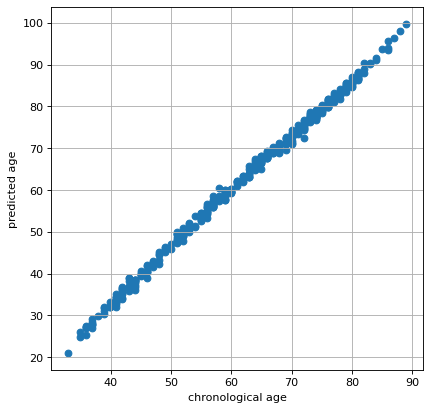

[[1.         0.99855947]
 [0.99855947 1.        ]]
r^2 train data:  0.8834431841974794


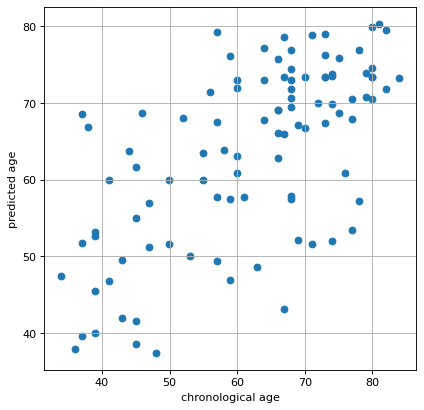

[[1.         0.64451063]
 [0.64451063 1.        ]]
r^2 val data:  0.3613403702607867


切片: 29.874180579906202
傾き: 0.5443977903703806
Kfold: 2 ::: epoch: 100, loss: 0.018832088376467045, val loss: 0.8687667548656464
Kfold: 2 ::: epoch: 200, loss: 0.008934902707831217, val loss: 0.7928417026996613
Kfold: 2 ::: epoch: 300, loss: 0.009490837916158713, val loss: 0.6793779656291008
Kfold: 2 ::: epoch: 400, loss: 0.011578343307169585, val loss: 0.6483197808265686
Kfold: 2 ::: epoch: 500, loss: 0.008501968955477843, val loss: 0.6651085577905178
Kfold: 2 ::: epoch: 600, loss: 0.008482109432896743, val loss: 0.709073081612587
Kfold: 2 ::: epoch: 700, loss: 0.01053678967918341, val loss: 0.7308172695338726
save_epochs:558


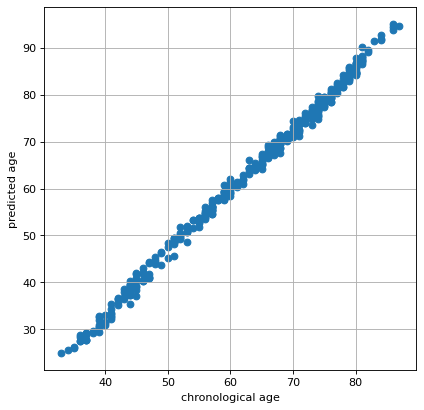

[[1.         0.99805991]
 [0.99805991 1.        ]]
r^2 train data:  0.8982109472013757


[[1.         0.57548099]
 [0.57548099 1.        ]]
r^2 val data:  0.3106115322292746


切片: 36.846918599238904
傾き: 0.4135736956092769
Kfold: 3 ::: epoch: 100, loss: 0.01976432429196743, val loss: 1.1986053586006165
Kfold: 3 ::: epoch: 200, loss: 0.01192402459967595, val loss: 1.086941808462143
Kfold: 3 ::: epoch: 300, loss: 0.014569927866642293, val loss: 1.0231885313987732
Kfold: 3 ::: epoch: 400, loss: 0.01215587778446766, val loss: 0.9912244826555252
Kfold: 3 ::: epoch: 500, loss: 0.010731278990323726, val loss: 0.9415253549814224
Kfold: 3 ::: epoch: 600, loss: 0.009423935714249428, val loss: 0.9986525028944016
Kfold: 3 ::: epoch: 700, loss: 0.008104877635979882, val loss: 0.9144146740436554
save_epochs:743


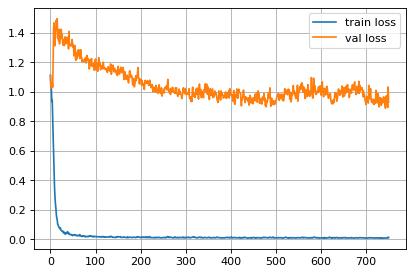

[[1.         0.99826907]
 [0.99826907 1.        ]]
r^2 train data:  0.9127208039720306


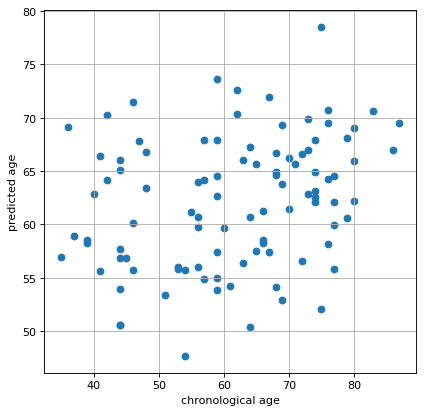

[[1.         0.28380629]
 [0.28380629 1.        ]]
r^2 val data:  0.046157921832454485


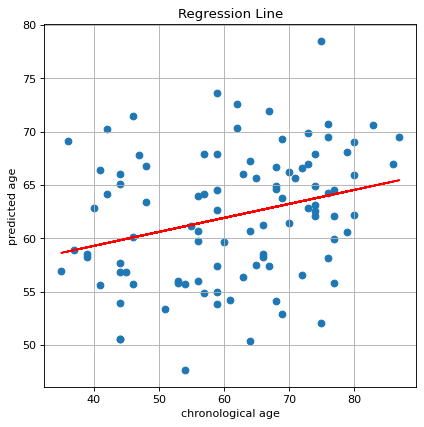

切片: 54.06597490500488
傾き: 0.13096880221366705
Kfold: 4 ::: epoch: 100, loss: 0.022158705414487764, val loss: 1.3204023092985153
Kfold: 4 ::: epoch: 200, loss: 0.013339234659304986, val loss: 1.1403473615646362
Kfold: 4 ::: epoch: 300, loss: 0.014243824013437215, val loss: 1.1248925477266312
Kfold: 4 ::: epoch: 400, loss: 0.010274789618471494, val loss: 1.0384800136089325
Kfold: 4 ::: epoch: 500, loss: 0.007801103513114727, val loss: 0.957278698682785
Kfold: 4 ::: epoch: 600, loss: 0.011884694811529838, val loss: 1.070885807275772
Kfold: 4 ::: epoch: 700, loss: 0.012632104496543225, val loss: 1.0574945360422134
save_epochs:505


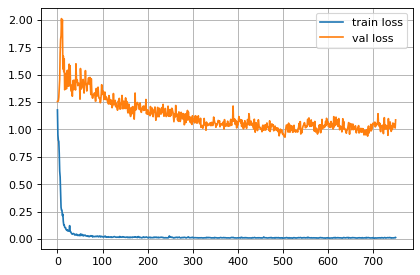

[[1.         0.99754396]
 [0.99754396 1.        ]]
r^2 train data:  0.8982787739412166


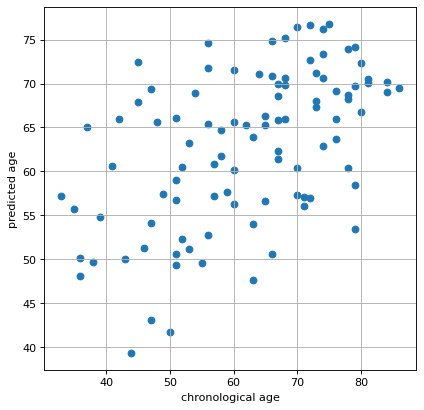

[[1.         0.52847757]
 [0.52847757 1.        ]]
r^2 val data:  0.26002833382001245


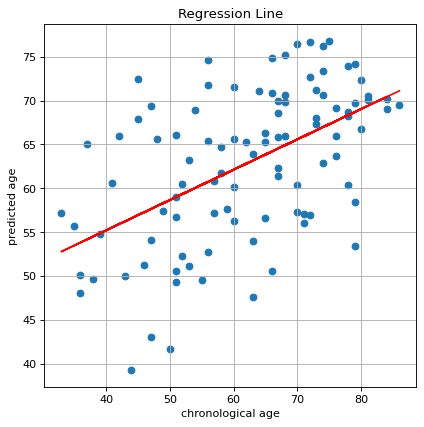

切片: 41.399332868190186
傾き: 0.3455039967291818
Kfold: 5 ::: epoch: 100, loss: 0.021914007786947947, val loss: 0.8350615352392197
Kfold: 5 ::: epoch: 200, loss: 0.0175833934559845, val loss: 0.7511000782251358
Kfold: 5 ::: epoch: 300, loss: 0.01020489944718205, val loss: 0.741251215338707
Kfold: 5 ::: epoch: 400, loss: 0.01049564485079967, val loss: 0.6524569317698479
Kfold: 5 ::: epoch: 500, loss: 0.010880218317302374, val loss: 0.6144154295325279
Kfold: 5 ::: epoch: 600, loss: 0.009218565618189482, val loss: 0.5980293792672455
Kfold: 5 ::: epoch: 700, loss: 0.009279446264442343, val loss: 0.5561253894120455
save_epochs:532


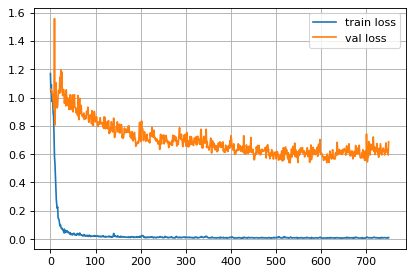

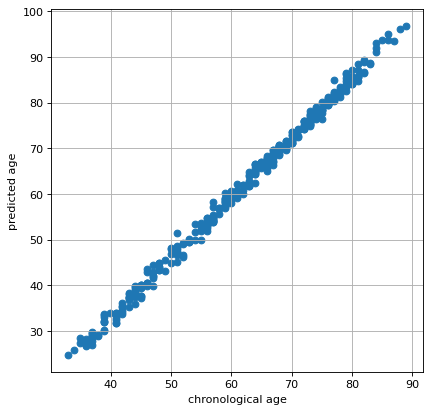

[[1.         0.99820036]
 [0.99820036 1.        ]]
r^2 train data:  0.8953121527191616


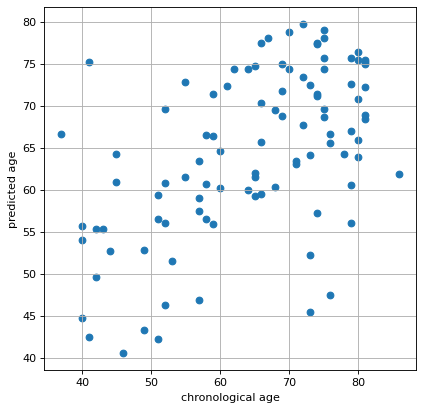

[[1.         0.54525144]
 [0.54525144 1.        ]]
r^2 val data:  0.24515120500023102


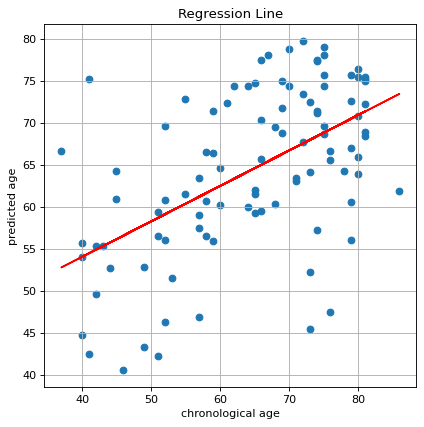

切片: 37.187854312791245
傾き: 0.42148757931110603
Nested Kfold ::: 4
Kfold: 1 ::: epoch: 100, loss: 0.021030822661347114, val loss: 0.8216567486524582
Kfold: 1 ::: epoch: 200, loss: 0.014463376253843307, val loss: 0.7427816838026047
Kfold: 1 ::: epoch: 300, loss: 0.009150349141026918, val loss: 0.6380116492509842
Kfold: 1 ::: epoch: 400, loss: 0.01215194921510724, val loss: 0.6709412187337875
Kfold: 1 ::: epoch: 500, loss: 0.009738790874297801, val loss: 0.6458608955144882
Kfold: 1 ::: epoch: 600, loss: 0.013536812379383124, val loss: 0.6754134148359299
Kfold: 1 ::: epoch: 700, loss: 0.010210685002116056, val loss: 0.6360685974359512
save_epochs:746


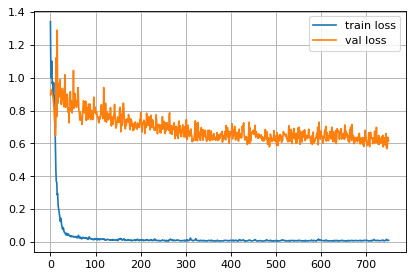

[[1.         0.99597265]
 [0.99597265 1.        ]]
r^2 train data:  0.7862268848416978


[[1.         0.70152323]
 [0.70152323 1.        ]]
r^2 val data:  0.43492587250153036


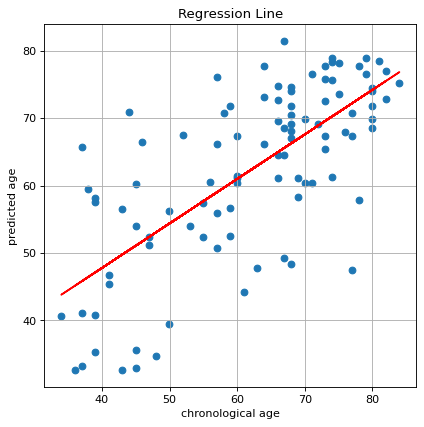

切片: 21.414708317398045
傾き: 0.6592938060052315
Kfold: 2 ::: epoch: 100, loss: 0.014710451619556317, val loss: 0.9303516894578934
Kfold: 2 ::: epoch: 200, loss: 0.01006703175461063, val loss: 0.8476595729589462
Kfold: 2 ::: epoch: 300, loss: 0.008949445703854928, val loss: 0.7902655303478241
Kfold: 2 ::: epoch: 400, loss: 0.012494173294936236, val loss: 0.7326819896697998
Kfold: 2 ::: epoch: 500, loss: 0.010488339269963594, val loss: 0.7253610640764236
Kfold: 2 ::: epoch: 600, loss: 0.007022214319127111, val loss: 0.7358333021402359
Kfold: 2 ::: epoch: 700, loss: 0.012100371657512508, val loss: 0.6929564923048019
save_epochs:721


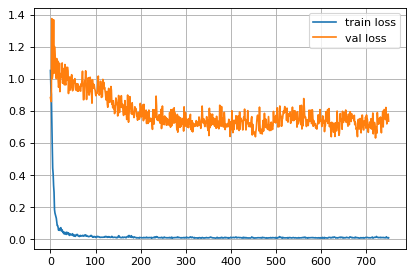

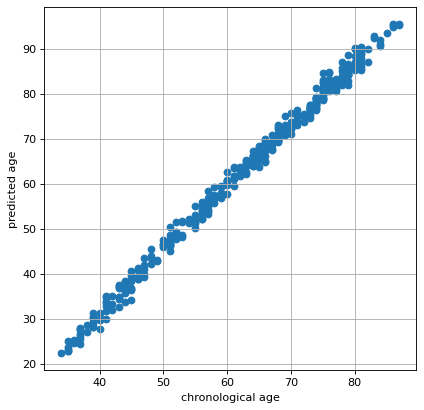

[[1.         0.99708813]
 [0.99708813 1.        ]]
r^2 train data:  0.8377461726325355


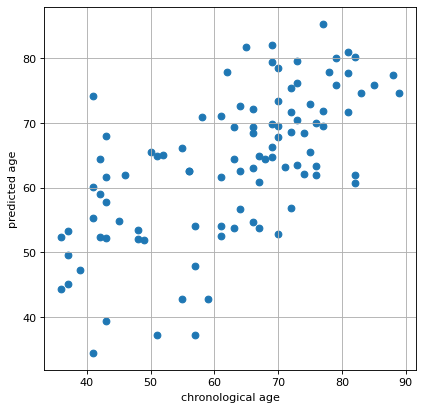

[[1.         0.64037268]
 [0.64037268 1.        ]]
r^2 val data:  0.37821139658095426


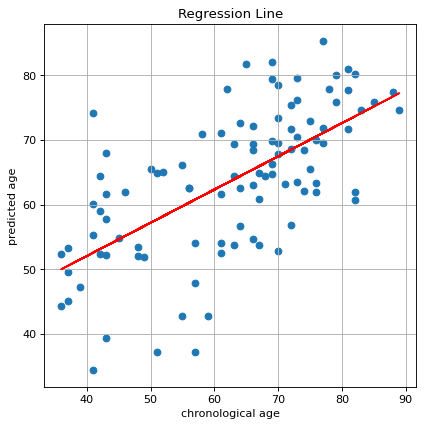

切片: 31.518698957175786
傾き: 0.5136957410981153
Kfold: 3 ::: epoch: 100, loss: 0.015802970227713767, val loss: 0.8493424579501152
Kfold: 3 ::: epoch: 200, loss: 0.0168304552968878, val loss: 0.734393022954464
Kfold: 3 ::: epoch: 300, loss: 0.01254063113950766, val loss: 0.7520592212677002
Kfold: 3 ::: epoch: 400, loss: 0.010283004492521286, val loss: 0.6659502908587456
Kfold: 3 ::: epoch: 500, loss: 0.010522711699685225, val loss: 0.6778912842273712
Kfold: 3 ::: epoch: 600, loss: 0.010678552306042267, val loss: 0.6142797097563744
Kfold: 3 ::: epoch: 700, loss: 0.008200154926341314, val loss: 0.6174570322036743
save_epochs:651


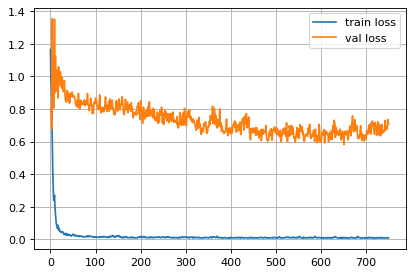

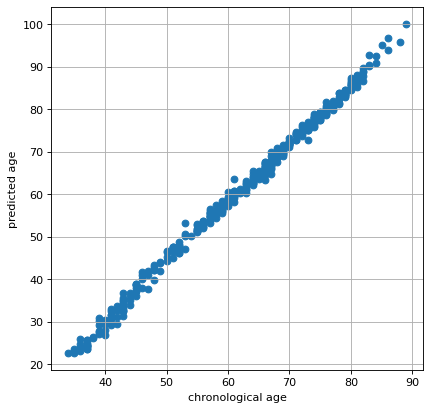

[[1.         0.99804142]
 [0.99804142 1.        ]]
r^2 train data:  0.8387563567119635


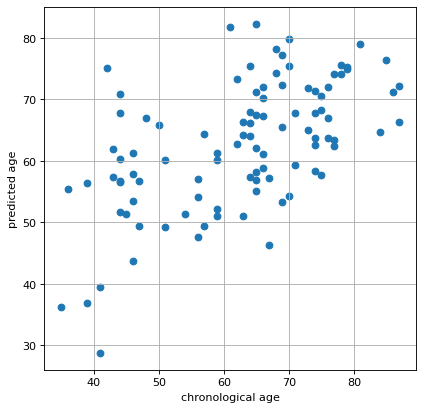

[[1.        0.5741426]
 [0.5741426 1.       ]]
r^2 val data:  0.2813012012290663


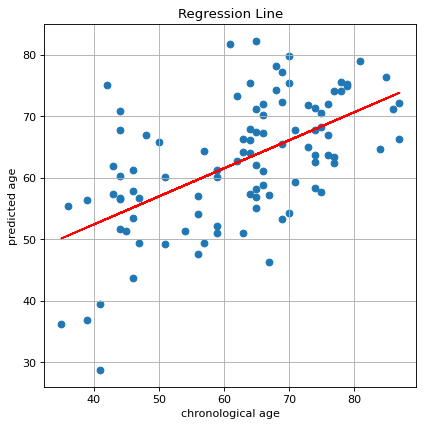

切片: 34.22550366957114
傾き: 0.4554816909816154
Kfold: 4 ::: epoch: 100, loss: 0.020351743468871482, val loss: 1.4228343963623047
Kfold: 4 ::: epoch: 200, loss: 0.01623349027851453, val loss: 1.2307309210300446
Kfold: 4 ::: epoch: 300, loss: 0.0133806335954712, val loss: 1.3160801231861115
Kfold: 4 ::: epoch: 400, loss: 0.013015648493399987, val loss: 1.153630554676056
Kfold: 4 ::: epoch: 500, loss: 0.008546212652268318, val loss: 1.1185716539621353
Kfold: 4 ::: epoch: 600, loss: 0.013734397872422751, val loss: 1.1771654933691025
Kfold: 4 ::: epoch: 700, loss: 0.0113602766695504, val loss: 1.0731499195098877
save_epochs:684


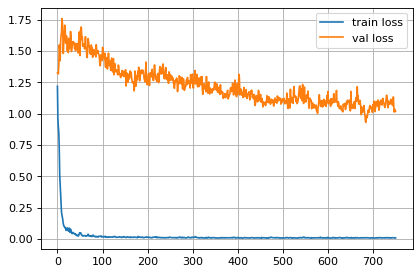

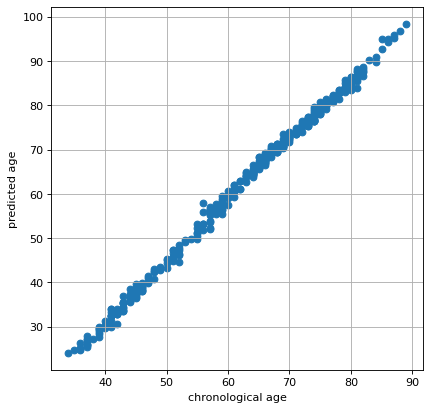

[[1.         0.99817563]
 [0.99817563 1.        ]]
r^2 train data:  0.8522525915540127


[[1.         0.57163562]
 [0.57163562 1.        ]]
r^2 val data:  0.27287029287482023


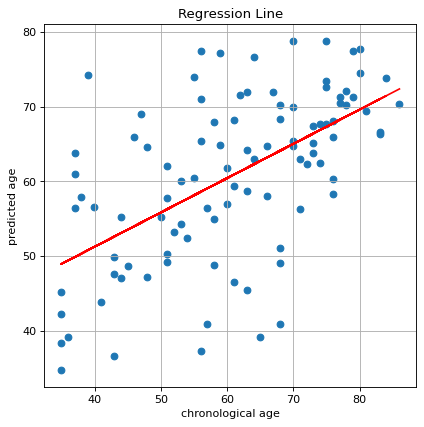

切片: 32.845865350391165
傾き: 0.4594701186972059
Kfold: 5 ::: epoch: 100, loss: 0.016120650089130953, val loss: 0.7974127978086472
Kfold: 5 ::: epoch: 200, loss: 0.013323638140438842, val loss: 0.6404032427817583
Kfold: 5 ::: epoch: 300, loss: 0.013073830793683346, val loss: 0.7427620105445385
Kfold: 5 ::: epoch: 400, loss: 0.012494491699796457, val loss: 0.6179197989404202
Kfold: 5 ::: epoch: 500, loss: 0.010196016635745764, val loss: 0.644038487225771
Kfold: 5 ::: epoch: 600, loss: 0.010337243465563426, val loss: 0.5508011638303287
Kfold: 5 ::: epoch: 700, loss: 0.009440120488691788, val loss: 0.5513860937207937
save_epochs:656


[[1.         0.99778493]
 [0.99778493 1.        ]]
r^2 train data:  0.8911086360829283


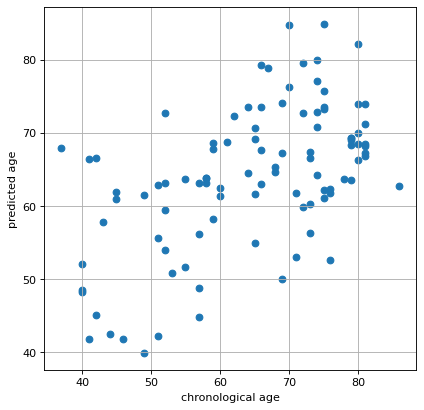

[[1.         0.55252618]
 [0.55252618 1.        ]]
r^2 val data:  0.2536400839727486


切片: 36.35879724036904
傾き: 0.4278801900558643
Nested Kfold ::: 5
Kfold: 1 ::: epoch: 100, loss: 0.01476322805795532, val loss: 0.7444510757923126
Kfold: 1 ::: epoch: 200, loss: 0.015338386480624858, val loss: 0.6831726431846619
Kfold: 1 ::: epoch: 300, loss: 0.011570055825779071, val loss: 0.7407414764165878
Kfold: 1 ::: epoch: 400, loss: 0.00966066881441153, val loss: 0.761398658156395
Kfold: 1 ::: epoch: 500, loss: 0.012074290846402828, val loss: 0.7626060247421265
Kfold: 1 ::: epoch: 600, loss: 0.009294544919752158, val loss: 0.7288581654429436
Kfold: 1 ::: epoch: 700, loss: 0.009446465410292149, val loss: 0.8011910617351532
save_epochs:397


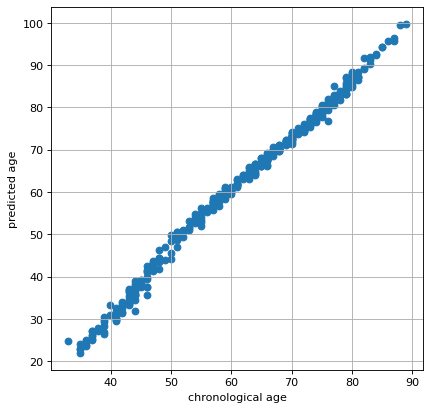

[[1.         0.99646844]
 [0.99646844 1.        ]]
r^2 train data:  0.8441843175851391


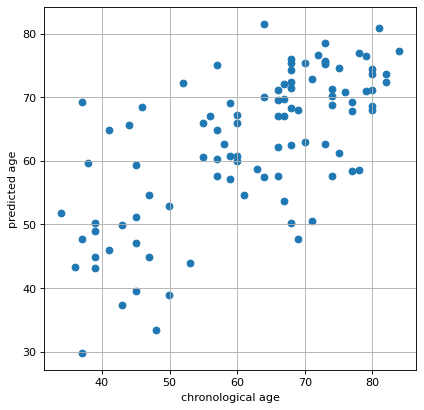

[[1.         0.67668552]
 [0.67668552 1.        ]]
r^2 val data:  0.42792779252242474


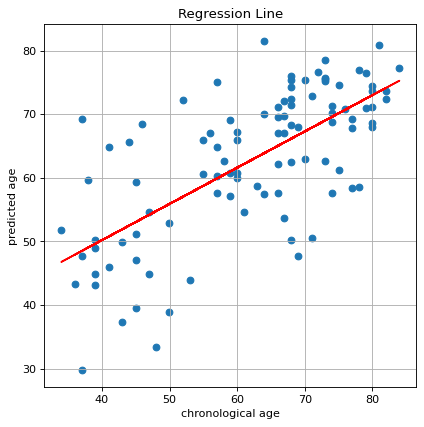

切片: 27.402647284851213
傾き: 0.5696416830955578
Kfold: 2 ::: epoch: 100, loss: 0.01943724065159376, val loss: 0.9979458749294281
Kfold: 2 ::: epoch: 200, loss: 0.009537696444357816, val loss: 0.8919122368097305
Kfold: 2 ::: epoch: 300, loss: 0.007989760165890822, val loss: 0.7501496374607086
Kfold: 2 ::: epoch: 400, loss: 0.008293199782761244, val loss: 0.7956277579069138
Kfold: 2 ::: epoch: 500, loss: 0.007688955869525671, val loss: 0.7059741020202637
Kfold: 2 ::: epoch: 600, loss: 0.007095577159466652, val loss: 0.7452083230018616
Kfold: 2 ::: epoch: 700, loss: 0.012779623556595582, val loss: 0.8035187423229218
save_epochs:631


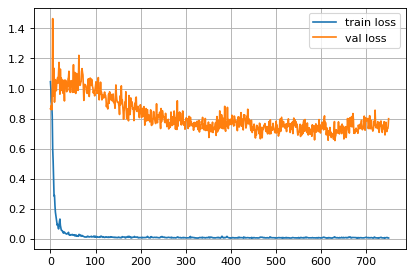

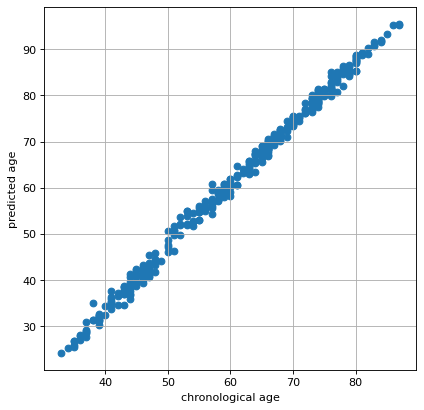

[[1.         0.99769176]
 [0.99769176 1.        ]]
r^2 train data:  0.8638471236672464


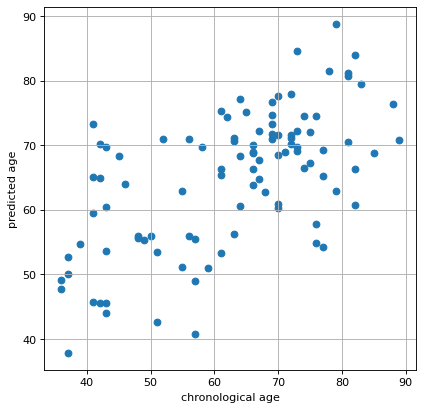

[[1.         0.61904362]
 [0.61904362 1.        ]]
r^2 val data:  0.33793883081281906


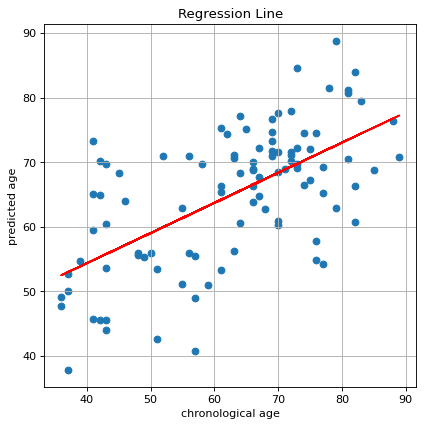

切片: 35.71055702348432
傾き: 0.466748387240558
Kfold: 3 ::: epoch: 100, loss: 0.01393565284804656, val loss: 0.8286351263523102
Kfold: 3 ::: epoch: 200, loss: 0.014135185557489213, val loss: 0.7734715491533279
Kfold: 3 ::: epoch: 300, loss: 0.017447112486339532, val loss: 0.7705981880426407
Kfold: 3 ::: epoch: 400, loss: 0.010231236174989205, val loss: 0.7335419803857803
Kfold: 3 ::: epoch: 500, loss: 0.009626573578526195, val loss: 0.7163323163986206
Kfold: 3 ::: epoch: 600, loss: 0.007989237299905373, val loss: 0.7296748757362366
Kfold: 3 ::: epoch: 700, loss: 0.009236350691375824, val loss: 0.7062977105379105
save_epochs:493


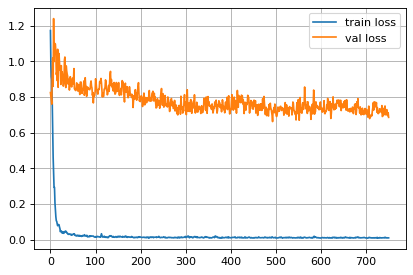

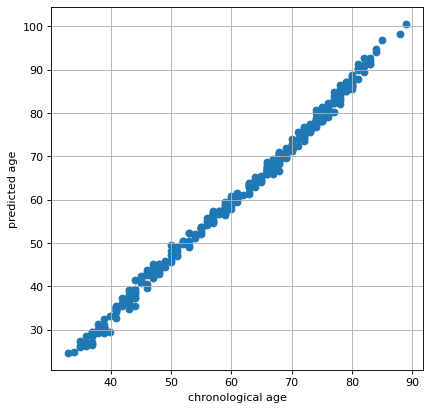

[[1.         0.99761469]
 [0.99761469 1.        ]]
r^2 train data:  0.8770071338214368


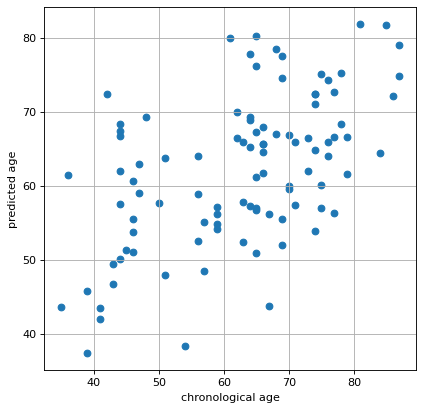

[[1.        0.5447461]
 [0.5447461 1.       ]]
r^2 val data:  0.2472008908695913


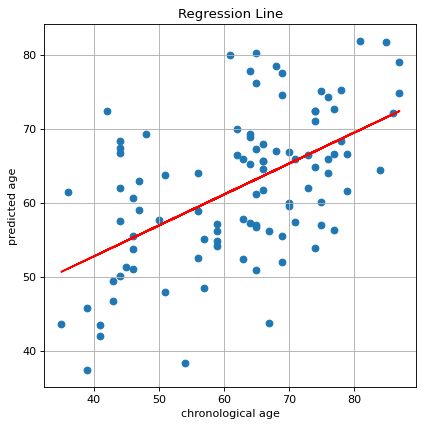

切片: 36.06989404772448
傾き: 0.41730829227782296
Kfold: 4 ::: epoch: 100, loss: 0.02028595770780857, val loss: 1.4691323935985565
Kfold: 4 ::: epoch: 200, loss: 0.01573142925134072, val loss: 1.0394247621297836
Kfold: 4 ::: epoch: 300, loss: 0.011693952246927299, val loss: 0.8342375457286835
Kfold: 4 ::: epoch: 400, loss: 0.011667534995537538, val loss: 0.843474492430687
Kfold: 4 ::: epoch: 500, loss: 0.01064005528146831, val loss: 0.5805366784334183
Kfold: 4 ::: epoch: 600, loss: 0.012930465038292684, val loss: 0.8908811658620834
Kfold: 4 ::: epoch: 700, loss: 0.009043101328783311, val loss: 0.7318603545427322
save_epochs:565


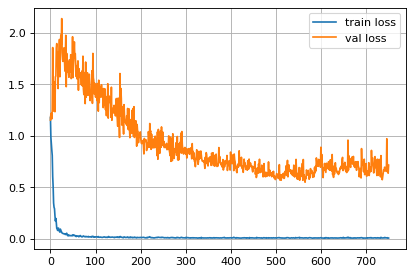

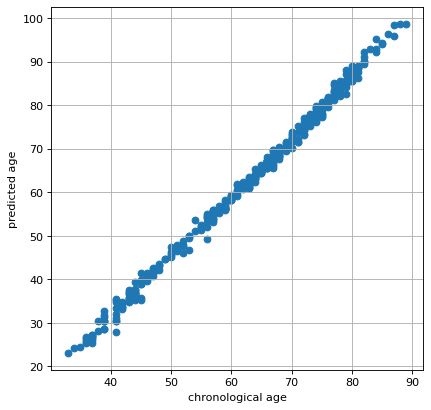

[[1.         0.99791063]
 [0.99791063 1.        ]]
r^2 train data:  0.8530960045908995


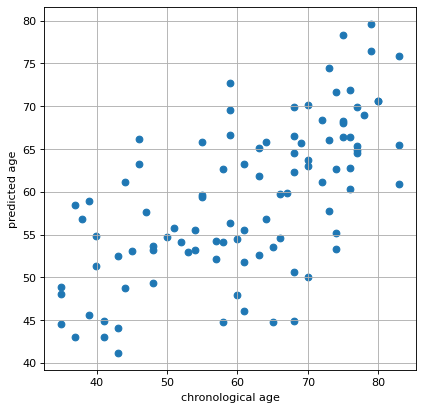

[[1.         0.64988921]
 [0.64988921 1.        ]]
r^2 val data:  0.4016902758474977


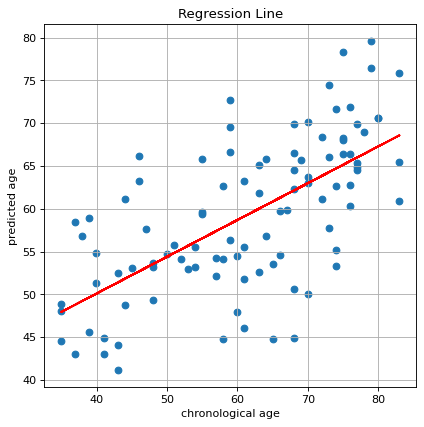

切片: 32.89947496608251
傾き: 0.4297755607393484
Kfold: 5 ::: epoch: 100, loss: 0.021661823615431786, val loss: 1.0817148834466934
Kfold: 5 ::: epoch: 200, loss: 0.01056378700125676, val loss: 0.9855203032493591
Kfold: 5 ::: epoch: 300, loss: 0.012525745273496095, val loss: 1.008248507976532
Kfold: 5 ::: epoch: 400, loss: 0.008786000544205308, val loss: 0.90913125872612
Kfold: 5 ::: epoch: 500, loss: 0.009835541606522523, val loss: 0.9988342374563217
Kfold: 5 ::: epoch: 600, loss: 0.009662052759757409, val loss: 1.0991792976856232
Kfold: 5 ::: epoch: 700, loss: 0.008802771245917449, val loss: 0.8931438624858856
save_epochs:659


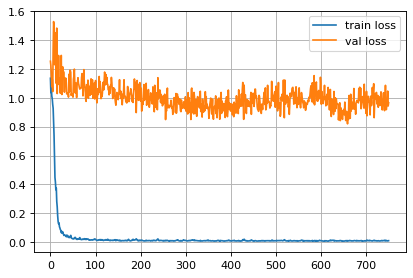

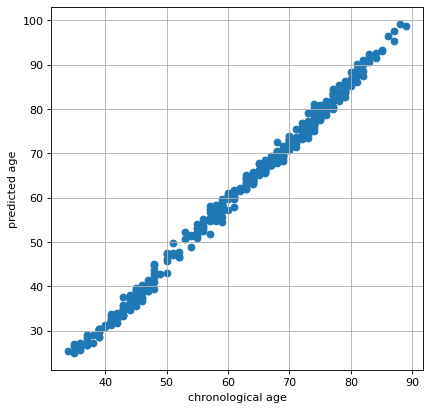

[[1.         0.99771646]
 [0.99771646 1.        ]]
r^2 train data:  0.8510452306314964


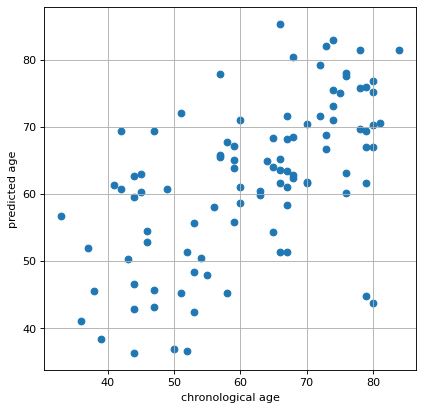

[[1.         0.59746356]
 [0.59746356 1.        ]]
r^2 val data:  0.2693181647075953


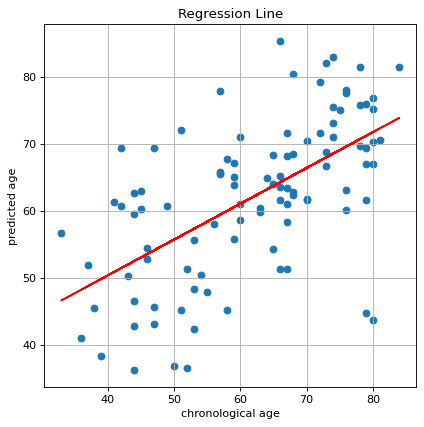

切片: 29.025271923581464
傾き: 0.5336078473285094
CPU times: user 1d 5h 31min 42s, sys: 1min 54s, total: 1d 5h 33min 36s
Wall time: 4h 14min 59s


In [24]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_all_dynamic_2  = []
test_label_all_dynamic_2 = []

test_idx_all_dynamic_2   = []
train_idx_all_dynamic_2  = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_dynamic_aal)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_label = train_model(data_dynamic_aal,
                                       data_label,
                                       train_idx  = train_idx,
                                       test_idx   = test_idx,
                                       epochs     = 750,
                                       d_model    = 64,
                                       n_splits   = n_splits,
                                       hidden_dim = 256,
                                       nhead      = 2,#4
                                       hidden_dim_transformer = 1,#2
                                       pos_drop    = 0.5,
                                       trans_drop = 0.5,
                                       fc_drop = 0.3
                                      )
    test_pred_all_dynamic_2.append(test_pred)
    test_label_all_dynamic_2.append(test_label)
    test_idx_all_dynamic_2.append(test_idx)
    train_idx_all_dynamic_2.append(train_idx)

In [ ]:
test_label_all_dynamic_2

LinearRegression()

<Figure size 480x480 with 0 Axes>

Text(0.5, 1.0, 'Regression Line')

Text(0.5, 0, 'chronological age')

Text(0, 0.5, 'predicted age')

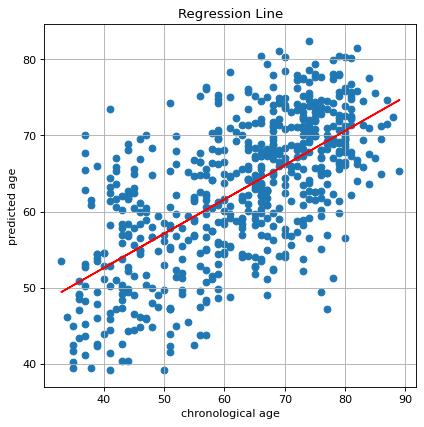

相関係数:  0.642094587698781
r^2 test data:  0.40833142048679694
切片:  34.550832566240935
傾き:  0.45055539342444084


In [25]:
for i in range(n_splits):
    if not i:
        test_label = test_label_all_dynamic_2[i]
    else:
        test_label = np.concatenate([test_label,test_label_all_dynamic_2[i]])
        
for i in range(n_splits):
    if not i:
        test_pred = test_pred_all_dynamic_2[i].mean(axis=0)
    else:
        test_pred = np.concatenate([test_pred,test_pred_all_dynamic_2[i].mean(axis=0)])

lr = LinearRegression()
lr.fit(test_label*age_std+age_mean,test_pred[:,0]*age_std+age_mean)

plt.figure(figsize=(6, 6), dpi=80)
plt.scatter(test_label[:,0]*age_std+age_mean,test_pred[:,0]*age_std+age_mean)#散布図をプロット
plt.plot(test_label[:,0]*age_std+age_mean,
         lr.predict(test_label*age_std+age_mean), color = 'red')#回帰直線をプロット

plt.title('Regression Line')   # 図のタイトル
plt.xlabel('chronological age')# x軸のラベル
plt.ylabel('predicted age')    # y軸のラベル
plt.grid()                     # グリッド線を表示
plt.show()                     # 図の表示

print('相関係数: ', np.corrcoef(test_label[:,0],test_pred[:,0])[0,1])
print('r^2 test data: ', r2_score(test_label[:,0],test_pred[:,0]))
print('切片: ', lr.intercept_)
print('傾き: ', lr.coef_[0])

<Figure size 480x480 with 0 Axes>

Text(0.5, 1.0, 'Regression Line')

Text(0.5, 0, 'diff')

Text(0, 0.5, 'apathy')

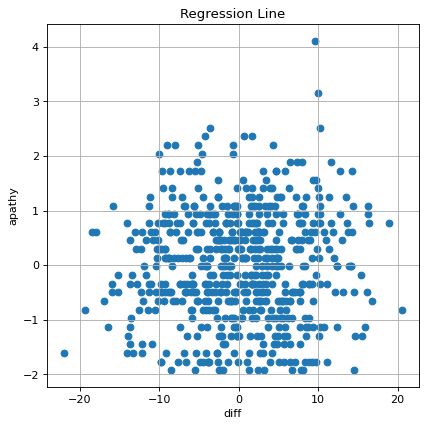

相関係数: 0.04304484830035685
p値: 0.286514128547462


In [26]:
diff = test_pred[:,0]*age_std + age_mean - lr.predict(test_label*age_std + age_mean)

plt.figure(figsize=(6, 6), dpi=80)
plt.scatter(diff,data_label[:,2])
plt.title('Regression Line')   # 図のタイトル
plt.xlabel('diff')    # x軸のラベル
plt.ylabel('apathy')  # y軸のラベル
plt.grid()                     # グリッド線を表示
plt.show()                     # 図の表示

corr,p = pearsonr(diff,data_label[:,2])
print("相関係数:", corr)
print("p値:", p)

## 相補性

In [ ]:
"""np.savez('../02_data_analysis/temp/all_1',
         test_pred_all_1,test_label_all_1,test_idx_all_1,train_idx_all_1)
np.savez('../02_data_analysis/temp/all_2',
         test_pred_all_2,test_label_all_2,test_idx_all_2,train_idx_all_2)
np.savez('../02_data_analysis/temp/all_dynamic_1',
         test_pred_all_dynamic_1,test_label_all_dynamic_1,test_idx_all_dynamic_1,train_idx_all_dynamic_1)
np.savez('../02_data_analysis/temp/all_dynamic_2',
         test_pred_all_dynamic_2,test_label_all_dynamic_2,test_idx_all_dynamic_2,train_idx_all_dynamic_2)"""

In [16]:
all_1 = np.load('../02_data_analysis/temp/all_1.npz')
all_2 = np.load('../02_data_analysis/temp/all_2.npz')
all_dynamic_1 = np.load('../02_data_analysis/temp/all_dynamic_1.npz')
all_dynamic_2 = np.load('../02_data_analysis/temp/all_dynamic_2.npz')

In [31]:
test_pred_all_1 = all_1['arr_0']
test_label_all_1 = all_1['arr_1']
test_idx_all_1 = all_1['arr_2']
train_idx_all_1 = all_1['arr_3']

test_pred_all_2 = all_2['arr_0']
test_label_all_2 = all_2['arr_1']
test_idx_all_2 = all_2['arr_2']
train_idx_all_2 = all_2['arr_3']

test_pred_all_dynamic_1 = all_dynamic_1['arr_0']
test_label_all_dynamic_1 = all_dynamic_1['arr_1']
test_idx_all_dynamic_1 = all_dynamic_1['arr_2']
train_idx_all_dynamic_1 = all_dynamic_1['arr_3']

test_pred_all_dynamic_2 = all_dynamic_2['arr_0']
test_label_all_dynamic_2 = all_dynamic_2['arr_1']
test_idx_all_dynamic_2 = all_dynamic_2['arr_2']
train_idx_all_dynamic_2 = all_dynamic_2['arr_3']

In [32]:
for i in range(n_splits):
    if not i:
        test_pred_1 = test_pred_all_1[i].mean(axis=0)
    else:
        test_pred_1 = np.concatenate([test_pred_1,test_pred_all_1[i].mean(axis=0)])

In [33]:
for i in range(n_splits):
    if not i:
        test_pred_2 = test_pred_all_2[i].mean(axis=0)
    else:
        test_pred_2 = np.concatenate([test_pred_2,test_pred_all_2[i].mean(axis=0)])

In [34]:
for i in range(n_splits):
    if not i:
        test_pred_dynamic_1 = test_pred_all_dynamic_1[i].mean(axis=0)
    else:
        test_pred_dynamic_1 = np.concatenate([test_pred_dynamic_1,test_pred_all_dynamic_1[i].mean(axis=0)])

In [35]:
for i in range(n_splits):
    if not i:
        test_pred_dynamic_2 = test_pred_all_dynamic_2[i].mean(axis=0)
    else:
        test_pred_dynamic_2 = np.concatenate([test_pred_dynamic_2,test_pred_all_dynamic_2[i].mean(axis=0)])

<Figure size 480x480 with 0 Axes>

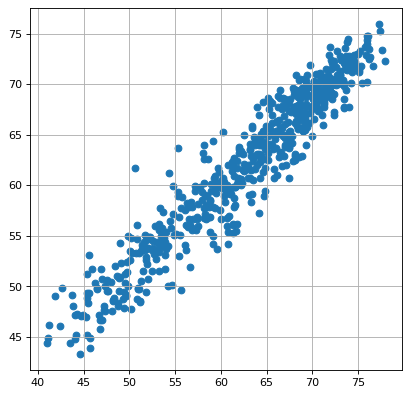

LinearRegression()

相関係数:  0.9584518010600448
r^2 data:  0.9066398130306221
切片:  9.689438
傾き:  0.8359178


In [36]:
plt.figure(figsize=(6, 6), dpi=80)
plt.scatter(test_pred_1[:,0]*age_std + age_mean,test_pred_2[:,0]*age_std + age_mean)
plt.grid()                     # グリッド線を表示
plt.show()                     # 図の表示

corr,p = pearsonr(test_pred_1[:,0]*age_std + age_mean,test_pred_2[:,0]*age_std + age_mean)

lr = LinearRegression()
lr.fit(test_pred_1*age_std + age_mean,test_pred_2[:,0]*age_std + age_mean)

print("相関係数: ", corr)
print('r^2 data: ', r2_score(test_pred_1[:,0],test_pred_2[:,0]))
print('切片: ', lr.intercept_)
print('傾き: ', lr.coef_[0])

<Figure size 480x480 with 0 Axes>

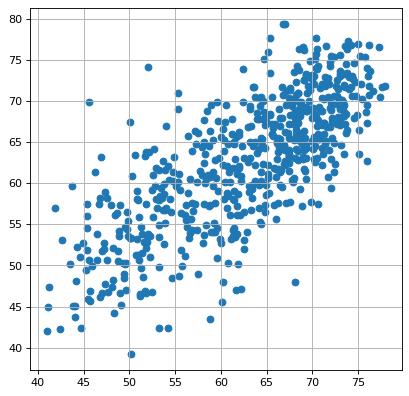

LinearRegression()

相関係数:  0.756964268048934
r^2 data:  0.5460001460150998
切片:  18.87886
傾き:  0.69712853


In [37]:
plt.figure(figsize=(6, 6), dpi=80)
plt.scatter(test_pred_1[:,0]*age_std + age_mean,test_pred_dynamic_1[:,0]*age_std + age_mean)
plt.grid()                     # グリッド線を表示
plt.show()                     # 図の表示

corr,p = pearsonr(test_pred_1[:,0]*age_std + age_mean,test_pred_dynamic_1[:,0]*age_std + age_mean)

lr = LinearRegression()
lr.fit(test_pred_1*age_std + age_mean,
       test_pred_dynamic_1[:,0]*age_std + age_mean)

print("相関係数: ", corr)
print('r^2 data: ', r2_score(test_pred_1[:,0],test_pred_dynamic_1[:,0]))
print('切片: ', lr.intercept_)
print('傾き: ', lr.coef_[0])

<Figure size 480x480 with 0 Axes>

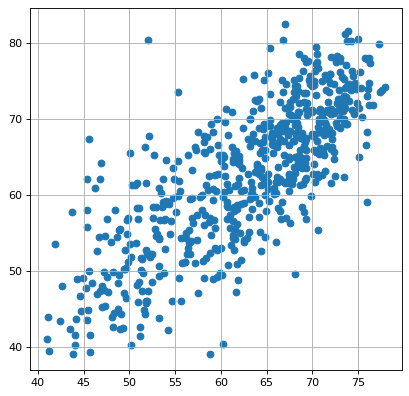

LinearRegression()

相関係数:  0.7782261763580556
r^2 data:  0.5101624714158534
切片:  9.677738
傾き:  0.8460739


In [38]:
plt.figure(figsize=(6, 6), dpi=80)
plt.scatter(test_pred_1[:,0]*age_std + age_mean,test_pred_dynamic_2[:,0]*age_std + age_mean)
plt.grid()                     # グリッド線を表示
plt.show()                     # 図の表示

corr,p = pearsonr(test_pred_1[:,0]*age_std + age_mean,test_pred_dynamic_2[:,0]*age_std + age_mean)

lr = LinearRegression()
lr.fit(test_pred_1*age_std + age_mean,
       test_pred_dynamic_2[:,0]*age_std + age_mean)

print("相関係数: ", corr)
print('r^2 data: ', r2_score(test_pred_1[:,0],test_pred_dynamic_2[:,0]))
print('切片: ', lr.intercept_)
print('傾き: ', lr.coef_[0])

<Figure size 480x480 with 0 Axes>

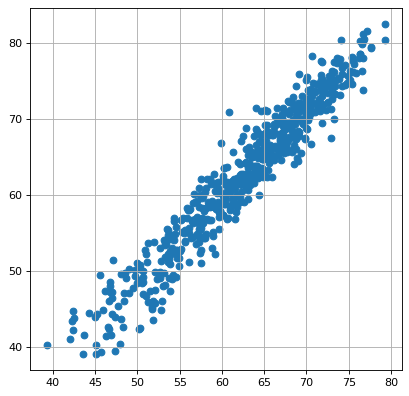

LinearRegression()

相関係数:  0.96554359527908
r^2 data:  0.8858203068586974
切片:  -8.617455
傾き:  1.1398215


In [39]:
plt.figure(figsize=(6, 6), dpi=80)
plt.scatter(test_pred_dynamic_1[:,0]*age_std + age_mean,test_pred_dynamic_2[:,0]*age_std + age_mean)
plt.grid()                     # グリッド線を表示
plt.show()                     # 図の表示

corr,p = pearsonr(test_pred_dynamic_1[:,0]*age_std + age_mean,test_pred_dynamic_2[:,0]*age_std + age_mean)

lr = LinearRegression()
lr.fit(test_pred_dynamic_1*age_std + age_mean,
       test_pred_dynamic_2[:,0]*age_std + age_mean)

print("相関係数: ", corr)
print('r^2 data: ', r2_score(test_pred_dynamic_1[:,0],test_pred_dynamic_2[:,0]))
print('切片: ', lr.intercept_)
print('傾き: ', lr.coef_[0])

(array([ 4.,  0.,  3.,  0.,  1.,  3.,  0.,  5.,  1.,  1.,  3.,  3.,  2.,
         4.,  2.,  4.,  3.,  1.,  6.,  3.,  4.,  4.,  5.,  6.,  6.,  5.,
         2.,  6.,  3.,  4.,  6.,  7.,  3.,  7.,  6., 10.,  9.,  6.,  3.,
         4., 12.,  8.,  3., 11., 10.,  9.,  8.,  7.,  7.,  8.,  7., 15.,
        12., 11., 13.,  4., 11.,  8.,  6., 15., 12., 13.,  9.,  9., 10.,
        11., 18.,  9., 10., 11.,  8., 12.,  6., 12., 13.,  6., 12.,  5.,
         5.,  9.,  8., 10.,  8.,  7.,  7.,  6.,  1.,  1.,  7.,  6.,  2.,
         1.,  1.,  1.,  3.,  3.,  1.,  1.,  0.,  1.]),
 array([39.121994, 39.55514 , 39.988293, 40.42144 , 40.854588, 41.28774 ,
        41.720886, 42.154037, 42.587185, 43.020332, 43.453484, 43.88663 ,
        44.31978 , 44.75293 , 45.186077, 45.619225, 46.052376, 46.485523,
        46.91867 , 47.35182 , 47.78497 , 48.21812 , 48.651268, 49.084415,
        49.517567, 49.950714, 50.38386 , 50.817013, 51.25016 , 51.683308,
        52.11646 , 52.549606, 52.982758, 53.415905, 53.849052, 5

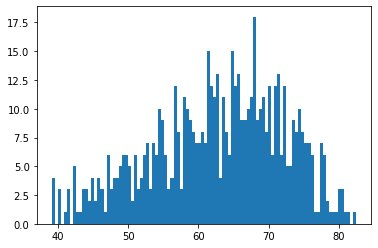

In [40]:
#dynamic 2の方が傾きを急に出すことができる
plt.hist(test_pred_dynamic_2[:,0]*age_std + age_mean,bins=100)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  4.,  0.,  0.,  1.,  1.,  1.,
         0.,  4.,  1.,  2.,  2.,  7.,  4.,  2.,  3.,  4.,  2.,  2.,  1.,
         4.,  6.,  6.,  4.,  2.,  8.,  1.,  6.,  7.,  9., 11.,  5.,  7.,
         5.,  5.,  3.,  8.,  7.,  8., 16., 10.,  5.,  8.,  8.,  8.,  9.,
        11.,  9.,  8., 14.,  6., 12.,  8., 16.,  9., 10., 13., 16., 12.,
        17., 10., 12.,  5., 17.,  9., 14.,  9., 11., 13., 10., 12., 11.,
         8.,  7.,  8., 13.,  5.,  7., 10.,  7.,  5.,  3.,  4.,  2.,  6.,
         1.,  4.,  7.,  1.,  2.,  0.,  0.,  0.,  2.]),
 array([39.274773, 39.674995, 40.07522 , 40.475437, 40.87566 , 41.275883,
        41.676105, 42.07633 , 42.47655 , 42.87677 , 43.276993, 43.677216,
        44.07744 , 44.47766 , 44.87788 , 45.278103, 45.678326, 46.07855 ,
        46.47877 , 46.878994, 47.279213, 47.679436, 48.07966 , 48.47988 ,
        48.880104, 49.280327, 49.680546, 50.08077 , 50.48099 , 50.881214,
        51.281437, 51.681656, 52.08188 , 52.4821  , 52.882324, 5

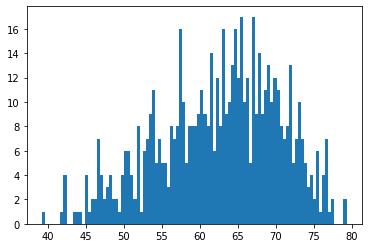

In [41]:
plt.hist(test_pred_dynamic_1[:,0]*age_std + age_mean,bins=100)